<a href="https://colab.research.google.com/github/SaKi1309/VoloGAN/blob/master/VoloGAN_AdversarialDomainAdaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Code Cleaning:
- [ ] comply with naming conventions! 
- [ ] for boolean use words like isBool, doBool, useBool, etc...
- [ ] Check that only required code is executed. e.g. no settings for hyper parameter tuning if training is selected! or model compilation step in training or hyperparameter tuning.
- [ ] unify wording of test and validation
- [ ] global variables are provided in parameterlists and not used within the function. in that way functions are indipendent of this notebook implementation! 

# Adversarial Domain Adaptation of Synthetic 3D Data to Train a Volumetric Video Generator Model

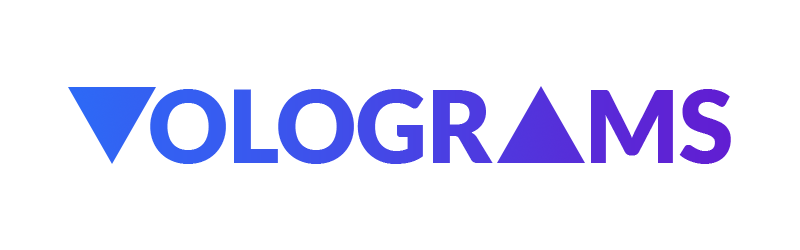

# Copyright (C) 2020-2021 Volograms Limited - All Rights Reserved

This file is part of VologramsAPI.

VologramsAPI can not be copied and/or distributed without the express
permission of Volograms Limited


In [ ]:
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l01c01_introduction_to_colab_and_python.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SaKi1309/VoloGAN/blob/master/Volograms_DomainAdaptation_Playground.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

<a name="0"></a>
# 0 - Initial steps

In [ ]:
!pip install tensorflow_addons

import tensorflow as tf         # Tensorflow framework
import numpy as np              # Tools for working with datastructures
import matplotlib.pyplot as plt # Plot data
import cv2                      # OpenCV for image processing
import tensorflow_addons as tfa # Aditional features for Tensorflow 
import seaborn as sns           # Visualize Data
import pandas as pd             # Organize datastructures
import keras.backend as K       # Aditional Functions for working with Tensors
from tensorflow.keras.callbacks import TensorBoard

#import gc                       #garbage collector
import os
import io
import imageio
import random
import time
from zipfile import ZipFile
import json

#from tqdm import tqdm
from sklearn.decomposition import PCA

# Print package version of available packages
print("Tensorflow version: \t\t" + tf.__version__)
print("Numpy version: \t\t\t" + np.__version__)
print("Open CV version: \t\t" + cv2.__version__)
print("Tensorflow Ad-Ons version: \t" + tfa.__version__)
print("Seaborn version: \t\t" + sns.__version__)
print("Pandas version: \t\t" + pd.__version__)
!python --version
#!cat /etc/*-release

<a name="0-x"></a>
## 0.x Distribution Strategy - HW Detection
Depending on the hardware available, different distribution strategies will be applied.

- If the TPU is available, the TPU Strategy is used.
Otherwise:
- If more than one GPU is available, then the Mirrored Strategy is applied
- If one GPU is available or if just the CPU is available, the default strategy is applied.

> Overview Distribution: https://www.tensorflow.org/api_docs/python/tf/distribute

> Tutorial of using td.distrubute on custom training: https://www.tensorflow.org/tutorials/distribute/custom_training

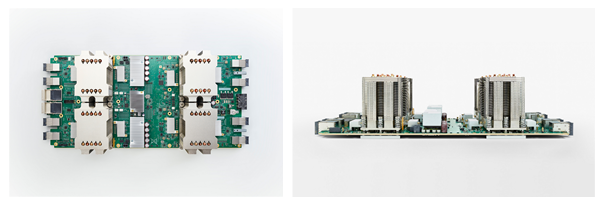

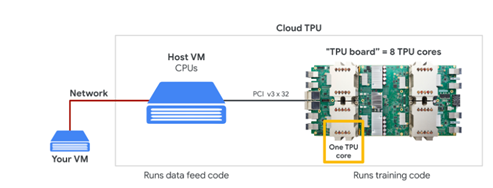

TODO:
- [ ] write assert function to check correct settings: especially regarding
  - padding of TPU
  - that both test and training set are dividable by 8 for TPU...
  - ....

In [ ]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  RUNTIME_ENVIRONMENT = "TPU"
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  RUNTIME_ENVIRONMENT = "GPU"
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  RUNTIME_ENVIRONMENT = "GPU"
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  RUNTIME_ENVIRONMENT = "CPU"
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

from tensorflow.python.client import device_lib
print("____________________________________________________________________________________")
print("Device List: ")
device_lib.list_local_devices()

In [ ]:
#@title ## 0.1 Notebook Settings
#@markdown The following Parameters can be adapted to influence the behavior of the notebook.

#@markdown ---

#@markdown ### 0.1.1 General:
#@markdown ---
RUN_NOTE = "Testing Grayscale on TPU after improving dropouts! " #@param {type:"string"}
NOTEBOOK_ENVIRONMENT = 'Google_Colab' #@param ["Google_Colab", "Kaggle"]
SAVE_LOCATION = 'local' #@param ["local", "drive"]
#@markdown *(Determines wheter logfiles, models and checkpoints are stored locally or on google drive)*

#@markdown ---
#@markdown ### 0.1.2 Model Architecture:
#@markdown ---
GENERATOR_DESIGN = 'UNet' #@param [ "ResNet", "UNet", "UNet_risidual_bottleneck","UNet_risidual_blocks"]
DISCRIMINATOR_DESIGN = 'OneShot_GAN' #@param ["PatchGAN", "UNet", "OneShot_GAN"]

USE_BIAS_NODES = False #@param {type:"boolean"}
PIXEL_DISTANCE = 'per_channel' #@param ["per_channel", "per_image"]
DSSIM_CALCULATION = 'per_channel' #@param ["per_channel", "per_image"]
LAMBDA_CYCLE = 10.0 #@param {type:"raw"}
LAMBDA_IDENTITY =  0.5#@param {type:"raw"}
LAMBDA_DSSIM =  1#@param {type:"raw"}
PADDING_TYPE = 'reflection' #@param ["zero", "reflection"]
GLOBAL_ACTIVATION = 'leaky_relu' #@param ["relu", "leaky_relu","elu","prelu"]

#@markdown > *Generator Related Options:*
GENERATOR_UP_DOWN_LEVELS = 4 #@param {type:"slider", min:1, max:10, step:1}
GENERATOR_CONV_FILTERS = 64 #@param [4, 8, 16, 32, 64, 128] {type:"raw"}
GENERATOR_CONV_KERNELS = 3 #@param [3, 5, 7] {type:"raw"}
GENERATOR_NUM_CONVS_PER_BLOCK = 1 #@param [1, 2, 3] {type:"raw"}
GENERATOR_SPLIT_KERNELS = False #@param {type:"boolean"}
GENERATOR_UPSAMPLING = 'depth_to_space' #@param ["2D_upsample_and_conv", "transpose_conv", "depth_to_space"]
GENERATOR_DOWNSAMPLING = 'conv_stride_2' #@param ["max_pooling", "conv_stride_2", "space_to_depth"]
FINAL_GENERATOR_ACTIVATION = 'hard_sigmoid'  #@param ["sigmoid", "tanh","hard_sigmoid"]

#@markdown > *Discriminator Related Options:*
DISCRIMINATOR_UP_DOWN_LEVELS = 3 #@param {type:"slider", min:1, max:10, step:1}
DISCRIMINATOR_CONV_FILTERS = 64 #@param [4, 8, 16, 32, 64, 128] {type:"raw"}
DISCRIMINATOR_CONV_KERNELS = 3 #@param [3, 5, 7] {type:"raw"}
DISCRIMINATOR_NUM_CONVS_PER_BLOCK = 1 #@param [1, 2, 3] {type:"raw"}
DISCRIMINATOR_SPLIT_KERNELS = False #@param {type:"boolean"}
DISCRIMINATOR_UPSAMPLING = 'depth_to_space' #@param ["2D_upsample_and_conv", "transpose_conv", "depth_to_space"]
DISCRIMINATOR_DOWNSAMPLING = 'conv_stride_2' #@param ["max_pooling", "conv_stride_2", "space_to_depth"]
DISCRIMINATOR_CUTMIX = True #@param {type:"boolean"}
CUTMIX_PROBABILITY = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}

#@markdown ---
#@markdown ### 0.1.3 Dataset:
#@markdown ---
#IMG_SIZE = (512, 512, 4)  #@param ["(512, 512, 4)","(512, 512, 2)"] {type:"raw"}
COLOR_MODE = 'Gray_Scale' #@param [ "RGB", "Gray_Scale"]
DATASOURCE = 'generated_from_drive' #@param [ "cloud_bucket", "generated_from_drive"]
DATA_DIRECTORY_NAME = 'training_set_selected_2048_v1' #@param ['training_synthetic_995_real_XXX','training_set_real_2452_synthetic_10000','training_set_real_2452_synthetic_11477_v4_2','training_set_selected_2048_v1','training_set_selected_2048_v1_grayscale'] {type:"string"}
DATASET_DATATYPE = 'float16' #@param ["float16", "float32"]
#@markdown > *Cloud Bucket Related Options:*
GCS_PATTERN = "gs://masterthesis-volograms-kirch" #@param {type:"string"}
GCS_PROJECT_ID = 'composite-shard-303117' #@param {type:"string"}
#@markdown > *Generated from Drive Related Options:*
DATASET_STORAGE_SCHEME = 'loaded_to_RAM' #@param ["binary_stream_disk", "loaded_to_RAM"]
RECORDS_PER_FILE = 16 #@param {type:"integer"} #8 per file (float32): 64Mbyte/file, 16 per file (float32): 128Mbyte/file
DOWNLOAD_GENERATED_FILES = True #@param {type:"boolean"}

#@markdown ---
#@markdown ### 0.1.4 Training Parameters:
#@markdown ---
TRAINING_MODE = 'Training' #@param ["Training", "Hyperparameter_Tuning", "Inference"]
EPOCHS =  50#@param {type:"integer"}
WARM_UP_EPOCHS =  15#@param {type:"integer"}
LR_DECAY =  "cosine" #@param [ "none", "linear","cosine","exponential"]
GEN_OPTIMIZER = "nadam" #@param [ "adam", "sgd","nadam","swats_adam","swats_nadam"]
GEN_LEARNING_RATE = 2e-4 #@param ['2e-4','6e-4','1e-3'] {type:"raw"}
DISC_OPTIMIZER = "sgd" #@param [ "adam", "sgd","nadam","swats_adam","swats_nadam"]
DISC_LEARNING_RATE = 6e-4 #@param ['2e-4','6e-4','1e-3'] {type:"raw"}
USE_AMSGRAD = False #@param {type:"boolean"}
DROPOUT_RATE = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
#@markdown batchsize of 128 is favorable due to TPU architecture (8cores * 128 batches = 1024samples!)
#@markdown the amount of samples per TPU must be dividable by 8 since there are 8 cores!!!
#@markdown good start for tpu is batch 1 and samples 480 and train_split 0,8
BATCH_SIZE_PER_REPLICA =  1#@param {type:"integer"}
NUM_SAMPLES_TO_LOAD =  40 #@param [40, 160, 480, 680, 960, 1360, 2040, 2200] {type:"raw"}
TRAIN_SPLIT = 0.8 #@param {type:"slider", min:0, max:1, step:0.05}
ADAPT_PIXEL_LOSS = True #@param {type:"boolean"}
TRAINING_START = 'Start from scratch' #@param ["Start from scratch", "Load checkpoint", "Load Model"]
CHECKPOINT_MODEL_FILEPATH = "checkpoint/<MODEL>/" #@param {type:"string"}

#@markdown ---
#@markdown ### 0.1.5 Validation:
#@markdown ---
TRAINING_VALIDATION = True #@param {type:"boolean"}
VALIDATION_EPOCH_FREQUENCY =  3#@param {type:"integer"}
PLOT_PCA = False #@param {type:"boolean"}
PLOT_VALIDATION_IMAGES = True #@param {type:"boolean"}
PLOT_HISTOGRAM = False #@param {type:"boolean"}
TENSORBOARD_TRAINING = True #@param {type:"boolean"}
TENSORBOARD_MODEL_GRAPH = False #@param {type:"boolean"}
TENSORBOARD_PERFORMANCE_PROFILE = False #@param {type:"boolean"}
EPOCH_TO_PROFILE =  1#@param {type:"integer"} 

#@markdown ---
#@markdown ### 0.1.6 Saving and Loading:
#@markdown ---
USE_CHECKPOINTS = False #@param {type:"boolean"}
CHECKPOINT_EPOCH_FREQUENCY =  1#@param {type:"integer"}
SAVE_MODELS = False #@param {type:"boolean"}

#@markdown ---
#@markdown ### 0.1.7 Post Training:
#@markdown ---
RUN_INFERENCE = False #@param {type:"boolean"}
# Check Inputs:

#check sample count is dividable by 8 for TPU
TRAIN_COUNT = int(NUM_SAMPLES_TO_LOAD * TRAIN_SPLIT)
TEST_COUNT = int(round(NUM_SAMPLES_TO_LOAD * (1 - TRAIN_SPLIT)))
assert TRAIN_COUNT % 8 == 0 and TEST_COUNT % 8 == 0, "Number of samples in either train or test set is not dividable by 8"

#Check that imgae size matches color_scheme
if COLOR_MODE == "Gray_Scale":
  IMG_SIZE = (512,512,2)
  #assert IMG_SIZE[2] == 2, "Gray scale images require IMG_SIZE with 2 Channels!"
elif COLOR_MODE == "RGB":
  IMG_SIZE = (512,512,4)
  #assert IMG_SIZE[2] == 4, "RGB images require IMG_SIZE with 4 Channels!"

#assert not (NOTEBOOK_ENVIRONMENT == "Kaggle" and SAVE_LOCATION == "drive"), "When using kaggle, drive is not available!"
assert not (NOTEBOOK_ENVIRONMENT=="Kaggle" and SAVE_LOCATION == "drive"), "Drive can only be accessed in read mode when using kaggle"
assert not (RUNTIME_ENVIRONMENT=="TPU" and PADDING_TYPE == "reflection"), "Reflection padding not supported on TPU"
assert not (RUNTIME_ENVIRONMENT=="TPU" and (GEN_OPTIMIZER == "adam" or DISC_OPTIMIZER == "adam") and USE_AMSGRAD == True), "Amsgrad not supported on TPU"
assert not (RUNTIME_ENVIRONMENT=="TPU" and DATASET_STORAGE_SCHEME =="binary_stream_disk" and DATASOURCE != "cloud_bucket"), "Loading data as binary stream from disk is not supported with TPU."

<a name="0-1"></a>
## 0.2 Mounting the Google Drive

Please run the next code cell and follow these steps to mount your Google Drive so that it can be accessed by this Colab.

Opt 1.
- Execute the code cell below. A web link will appear below the cell where the user can login to drive. **Drawback**: Has to be done with every run time


``` python
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
```


Opt 2.
- Permanently mount drive in the file system of the colab VM (Does not work when notbook is shared among different users!)

In [ ]:
if NOTEBOOK_ENVIRONMENT!="Kaggle" and (SAVE_LOCATION == "drive" or DATASOURCE = 'generated_from_drive'):
  from google.colab import drive
  drive.mount('/content/drive')

<a name="0-2"></a>
## 0.3 Prepare Real Time Datalogging on Phone

In order to review the output of destinct cells at any time, HyperDash can be used. It is a tool for iOS and Android to monitor cell outputs at real time.

> Link: https://hyperdash.io/ 

In order to track a cell, it needs to be marked with: 

%%monitor_cell “MasterThesis/PatchGAN” 

In [ ]:
#!pip install hyperdash && hyperdash login --github
#from hyperdash import monitor_cell

<a name="1"></a>
# 1 - Environment

<a name="1-3"></a>
## 1.3 Google Cloud Storage Authentification

In [ ]:
if DATASOURCE == 'cloud_bucket':
  if NOTEBOOK_ENVIRONMENT == 'Google_Colab':
    from google.colab import auth
    auth.authenticate_user()

    GCS_PROJECT_ID = 'composite-shard-303117'
    !gcloud config set project {GCS_PROJECT_ID}
    !gsutil ls
    !gsutil ls gs://masterthesis-volograms-kirch/
  else: #NOTEBOOK_ENVIRONMENT == 'Kaggle':
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    user_secrets.set_tensorflow_credential(user_credential)

<a name="1-4"></a>
## 1.4 Global Parameters

Initializer is crucial!!!!:
> he initializer paper: https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf 

> Explainaition for random, xavier and he initializer: https://adventuresinmachinelearning.com/weight-initialization-tutorial-tensorflow/

> another great source that also mentions uniform vs normal: https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404

In [ ]:
#BUGGY!!!!!
#class HeUniformLeakyRelu(tf.keras.initializers.Initializer):
#  def __init__(self,alpha = 0.3):
#    self.alpha = alpha#
#
#  def __call__(self, shape, dtype=None, **kwargs):
#    n = tf.math.reduce_prod(shape)
#    limit = tf.sqrt(6/((1+self.alpha**2)*n))
#    return tf.random.uniform( shape,-limit,limit, dtype=dtype)
#
#  def get_config(self):  # To support serialization
#    return {"alpha": self.alpha}

In [ ]:
#Seed is used to have comparability between runs while maintaining random behavior!
RANDOM_SEED = 10
random.seed(RANDOM_SEED)
np.random.seed(seed=RANDOM_SEED)

# The global batch size is the batch size per replica (1 in this case) times the number of replicas in the distribution strategy (In Colab: 8 for TPU, 1 for GPU and CPU).
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# Used for the data pipline to feed the data to the network
BUFFER_SIZE = NUM_SAMPLES_TO_LOAD

# Determines whether the tensorboard is required or not
USE_TENSORBOARD = TENSORBOARD_TRAINING or PLOT_PCA or PLOT_VALIDATION_IMAGES or PLOT_HISTOGRAM or TENSORBOARD_MODEL_GRAPH or TENSORBOARD_PERFORMANCE_PROFILE or TRAINING_MODE == "Hyperparameter_Tuning"

# Weights initializer for the layers.
#KERNEL_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
KERNEL_INIT = tf.keras.initializers.HeUniform(seed=RANDOM_SEED)

#last convolution before a sigmoid or a tanh activation gets the glorot initializer!!
if FINAL_GENERATOR_ACTIVATION == "tanh":
  LAST_KERNEL_INIT = tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)
else:
  LAST_KERNEL_INIT = tf.keras.initializers.HeUniform(seed=RANDOM_SEED)

# Gamma initializer for instance normalization.
#GAMMA_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
GAMMA_INIT = tf.keras.initializers.HeUniform(seed=RANDOM_SEED)

#autotune function for parallelism.
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Strategy for reducing the loss whan calculated over several replicas
REDUCTION_STRATEGY = tf.keras.losses.Reduction.NONE

# Name indication model architecture and timestamp. Can be used for saving unic progress. e.g. tensorboard or checkpoints
NAME = "{timestamp}_CycleGAN_{training_mode}".format(gen_design = GENERATOR_DESIGN, disc_design = DISCRIMINATOR_DESIGN, timestamp= int(time.time()), training_mode = TRAINING_MODE)

BASE_DRIVE_DIRECTORY = os.path.join("/content","drive","MyDrive","Master","Volograms")

if NOTEBOOK_ENVIRONMENT == "Google_Colab":
  BASE_VM_DIRECTORY = os.path.join("/content")
else: #NOTEBOOK_ENVIRONMENT == "Kaggle"
  BASE_VM_DIRECTORY = os.path.join("/kaggle","working")


if SAVE_LOCATION == 'drive':
  BASE_SAVE_DIRECTORY = BASE_DRIVE_DIRECTORY
else:
  BASE_SAVE_DIRECTORY = BASE_VM_DIRECTORY #local storage on VM

 # Create a dictionary describing the features.
IMAGE_FEATURE_DESCRIPTION = {
  'synthetic_image': tf.io.FixedLenFeature([], tf.string),
  'target_image': tf.io.FixedLenFeature([], tf.string)
}

MIXED_PRECISION = False
XLA_ACCELERATE = False

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')



<a name="2"></a>
# 2 - Utilities and Helper Functions

>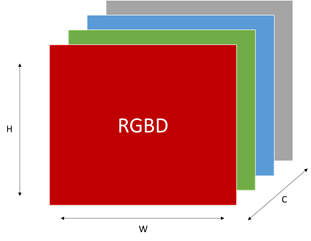


Param | Value
--- | ---
Height | 512
Width | 512
Channel | 4

<a name="2-1"></a>
## 2.1 Plotting RGBD

> matplotlib colormap refference: https://matplotlib.org/stable/gallery/color/colormap_reference.html

In [ ]:
def Plot_RGBD_Sample(rgbd, normalize = False, title = "RGBD Plot"):
  
  # local copy is requiered since rgbd is an array and therefore passed by refference. that means rgbd =/ 255, would change the array even outside the scope of thid function
  if normalize: # Only applicable ffor float 32
    rgbd = rgbd/255
  
  rgbd_local =  tf.cast(rgbd, tf.float32) # Matplotlib can not plot float16

  for i in range(rgbd_local.shape[2]):
    print("Dimension {0} - shape: {1} min: {2:.3f} max: {3:.3f} mean: {4:.3f} var: {5:.3f} std: {6:.3f} ".format(
        i,
        np.shape(rgbd_local[:,:,i]),
        np.min(rgbd_local[:,:,i]),
        np.max(rgbd_local[:,:,i]),
        np.mean(rgbd_local[:,:,i]),
        np.var(rgbd_local[:,:,i]),
        np.std(rgbd_local[:,:,i]))
    )

  fig = plt.figure()
  fig = plt.figure(figsize=[20,10])
  fig.suptitle(title, fontsize=20)
  
  ax = fig.add_subplot(2, 2, 1)

  if COLOR_MODE == "RGB":
    image = rgbd_local[:,:,0:3]
    imgplot = plt.imshow(image)
  else: # COLOR_MODE == "Gray_Scale"
    image = rgbd_local[:,:,0]
    imgplot = plt.imshow(image, cmap='gray', vmin=0, vmax=1)
  ax.set_title('Image (all channels)')

  ax = fig.add_subplot(2, 2, 2)
  #plt.hist(image.ravel(),256,[0,1],log=True)
  plt.hist(tf.experimental.numpy.ravel(image),256,log=True)
  ax.set_title('Histogram Image (all channels)')
  
  ax = fig.add_subplot(2, 2, 3)
  depth = rgbd_local[:,:,-1]
  imgplot = plt.imshow(depth, cmap='nipy_spectral', vmin=0, vmax=1) #-1 -> last dimension!
  ax.set_title('Depth')
  #plt.colorbar()

  ax = fig.add_subplot(2, 2, 4)
  plt.hist(tf.experimental.numpy.ravel(depth),256,log=True)
  ax.set_title('Histogram Depth')

  plt.show()

def Plot_Multiple_RGBD(images, rows, columns, plot_title = "RGBD Plot", writeToTensorboard = False,log_dir = None, save_str = None, model_name = NAME, epoch = None):
  images_to_show = rows * columns
  images = tf.cast(images, tf.float32)
  #pad if not enough images ar requiured
  while images_to_show > len(images):
    padd_image = np.ones_like(images[0:1])
    images = np.append(images, padd_image, axis = 0 )
  final_image = np.concatenate([ np.concatenate([images[(a+b*columns),...] for a in range(columns)], axis = 1) for b in range(rows) ],axis = 0)
    
  fig = plt.figure()
  fig = plt.figure(figsize=[20,10])
  fig.suptitle(plot_title, fontsize=20)

  ax = fig.add_subplot(2, 1, 1)
  ax.set_title('Image (all channels)')
  ax.axis("off")
    
  if COLOR_MODE == "RGB":
    image = final_image[:,:,0:3]
    plt.imshow(image)
  else: # COLOR_MODE == "Gray_Scale"
    image = final_image[:,:,0]
    plt.imshow(image, cmap='gray', vmin=0, vmax=1)
  
  ax = fig.add_subplot(2, 1, 2)
  ax.set_title('Depth')
  ax.axis("off")
  depth = final_image[:,:,-1]
  plt.imshow(depth, cmap='nipy_spectral', vmin=0, vmax=1) #-1 -> last dimension!

  if writeToTensorboard:
    with tf.device('/job:localhost'): 
      with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.image(save_str, plot_to_image(fig), step= epoch)
  else:
    plt.show()

def Plot_RGBD_Seperatly(rgbd, normalize = False, title = "RGBD Plot"):
  if normalize:
    rgbd = rgbd/255
  rgbd_local =  tf.cast(rgbd, tf.float32) # Matplotlib can not plot float16

  fig = plt.figure(figsize=[24,10])
  fig.suptitle(title, fontsize=20)

  ax = fig.add_subplot(2, 5, 1)
  imgplot = plt.imshow(rgbd_local[:,:,0:3])
  ax.set_title('RGB')

  hx = fig.add_subplot(2, 5, 6)
  #plt.hist(rgbd_local[:,:,0].ravel(),256,log=True)
  plt.hist(tf.experimental.numpy.ravel(rgbd_local[:,:,0:3]),256,log=True)
  hx.set_title('Histogram RGB')

  ar = fig.add_subplot(2, 5, 2)
  imgplot = plt.imshow(rgbd_local[:,:,0], cmap='Reds')
  ar.set_title('Red')

  hr = fig.add_subplot(2, 5, 7, sharey=hx)
  #plt.hist(rgbd_local[:,:,0].ravel(),256,log=True)
  plt.hist(tf.experimental.numpy.ravel(rgbd_local[:,:,0]),256,log=True)
  hr.set_title('Histogram Red')

  ag = fig.add_subplot(2, 5, 3)
  imgplot = plt.imshow(rgbd_local[:,:,1], cmap='Greens')
  ag.set_title('Green')

  hg = fig.add_subplot(2, 5, 8, sharey=hx)
  #plt.hist(rgbd_local[:,:,1].ravel(),256,log=True)
  plt.hist(tf.experimental.numpy.ravel(rgbd_local[:,:,1]),256,log=True)
  hg.set_title('Histogram Green')

  ab = fig.add_subplot(2, 5, 4)
  imgplot = plt.imshow(rgbd_local[:,:,2], cmap='Blues')
  ab.set_title('Blue')

  hb = fig.add_subplot(2, 5, 9, sharey=hx)
  #plt.hist(rgbd_local[:,:,2].ravel(),256,log=True)
  plt.hist(tf.experimental.numpy.ravel(rgbd_local[:,:,2]),256,log=True)
  hb.set_title('Histogram Blue')

  ad = fig.add_subplot(2, 5, 5)
  imgplot = plt.imshow(rgbd_local[:,:,3], cmap='nipy_spectral', vmin=0, vmax=1)
  ad.set_title('Depth')

  hd = fig.add_subplot(2, 5, 10, sharey=hx)
  #plt.hist(rgbd_local[:,:,3].ravel(),256,log=True)
  plt.hist(tf.experimental.numpy.ravel(rgbd_local[:,:,3]),256,log=True)
  hd.set_title('Histogram Depth')

  plt.show()

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def Plot_generator_prediction(input, prediction, plot_title, writeToTensorboard = False, log_dir = None, save_str = None, model_name = NAME, epoch = None):
    #input_local = input.astype(np.float32) # input from dataset might be float16

    # Kaggle has issues with tf.experimental.numpy.ravel(), which is required for raveling tensorflow tensors!!!
    if NOTEBOOK_ENVIRONMENT == "Kaggle":
      plot_histogram = False
      rows = 1
    else:
      plot_histogram = True
      rows = 2
      
    fig = plt.figure(figsize=[20,8])
    fig.suptitle(plot_title, fontsize=20)

    aix = fig.add_subplot(rows, 4, 1)
    if COLOR_MODE == "RGB":
      input_image = input[:,:,0:3]
      imgplot = plt.imshow(input_image)
    else: # COLOR_MODE == "Gray_Scale"
      input_image = input[:,:,0]
      imgplot = plt.imshow(input_image, cmap='gray', vmin=0, vmax=1)
    aix.set_title('Input Image')
    aix.axis("off")

    aid = fig.add_subplot(rows, 4, 2)
    input_depth = input[:,:,-1]
    imgplot = plt.imshow(input_depth, cmap='nipy_spectral', vmin=0, vmax=1)
    aid.set_title('Input Depth')
    aid.axis("off")

    aox = fig.add_subplot(rows, 4, 3)
    if COLOR_MODE == "RGB":
      predicted_image = prediction[:,:,0:3]
      imgplot = plt.imshow(predicted_image)
    else: # COLOR_MODE == "Gray_Scale"
      predicted_image = prediction[:,:,0]
      imgplot = plt.imshow(predicted_image, cmap='gray', vmin=0, vmax=1)
    aox.set_title('Output Image')
    aox.axis("off")

    aod = fig.add_subplot(rows, 4, 4)
    predicted_depth = prediction[:,:,-1]
    imgplot = plt.imshow(predicted_depth, cmap='nipy_spectral', vmin=0, vmax=1)
    aod.set_title('Output Depth')
    aod.axis("off")

    if plot_histogram:
      hix = fig.add_subplot(2, 4, 5)
      plt.hist(input_image.ravel(),256,[0,1],log=True)
      hix.set_title('Histogram Input Image')

      hid = fig.add_subplot(2, 4, 6, sharey=hix)
      plt.hist(input_depth.ravel(),256,[0,1],log=True)
      hid.set_title('Histogram Input Depth')

      hox = fig.add_subplot(2, 4, 7, sharey=hix)
      plt.hist(tf.experimental.numpy.ravel(predicted_image),256,[0,1],log=True)
      hox.set_title('Histogram Output Image')

      hod = fig.add_subplot(2, 4, 8, sharey=hix)
      plt.hist(tf.experimental.numpy.ravel(predicted_depth),256,[0,1],log=True)
      hod.set_title('Histogram Output Depth')

    if writeToTensorboard:
      with tf.device('/job:localhost'): 
        with tf.summary.create_file_writer(log_dir).as_default():
          tf.summary.image(save_str, plot_to_image(fig), step= epoch)
    else:
      plt.show()

    
def Plot_discriminator_prediction(input, prediction, plot_title, global_prediction = None, writeToTensorboard = False, log_dir = None, save_str = None, model_name = NAME, epoch = None):
  #input_local = input.astype(np.float32) # input from dataset might be float16
  
  fig = plt.figure(figsize=[12,6])
  fig.suptitle(plot_title, fontsize=20)
  ax = fig.add_subplot(1, 3, 1)
  
  if COLOR_MODE == "RGB":
    imgplot = plt.imshow(input[:,:,0:3])
  else: # COLOR_MODE == "Gray_Scale"
    imgplot = plt.imshow(input[:,:,0], cmap='gray', vmin=0, vmax=1)
  ax.set_title('Input Image')
  ax.axis("off")

  ax = fig.add_subplot(1, 3, 2)
  imgplot = plt.imshow(input[:,:,-1], cmap='nipy_spectral', vmin=0, vmax=1)
  ax.set_title('Input Depth')
  ax.axis("off")

  ax = fig.add_subplot(1, 3, 3)
  imgplot = plt.imshow(prediction[0,...,-1], cmap='RdBu_r')
  if global_prediction:
    ax.set_title("Prediction: {}".format(global_prediction))
  else:
    ax.set_title('Prediction')
  
  ax.axis("off")
  plt.colorbar()

  if writeToTensorboard:
    with tf.device('/job:localhost'): 
      with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.image(save_str, plot_to_image(fig), step= epoch)
  else:
    plt.show()

<a name="2-2"></a>
## 2.2 Misc

In [ ]:
def get_settings():
  setting = ""
  setting += "Param | Value\n"
  setting += "--- | ---\n" 
  setting += "RUN_NOTE | {}\n".format(RUN_NOTE)
  setting += "NOTEBOOK_ENVIRONMENT | {}\n".format(NOTEBOOK_ENVIRONMENT)
  setting += "RUNTIME_ENVIRONMENT | {}\n".format(RUNTIME_ENVIRONMENT)
  setting += "SAVE_LOCATION | {}\n".format(SAVE_LOCATION)
  setting += "GENERATOR_DESIGN | {}\n".format(GENERATOR_DESIGN)
  setting += "DISCRIMINATOR_DESIGN | {}\n".format(DISCRIMINATOR_DESIGN)
  setting += "USE_BIAS_NODES | {}\n".format(USE_BIAS_NODES)
  setting += "PIXEL_DISTANCE | {}\n".format(PIXEL_DISTANCE)
  setting += "DSSIM_CALCULATION | {}\n".format(DSSIM_CALCULATION)
  setting += "LAMBDA_CYCLE | {}\n".format(LAMBDA_CYCLE)
  setting += "LAMBDA_IDENTITY | {}\n".format(LAMBDA_IDENTITY)
  setting += "LAMBDA_DSSIM | {}\n".format(LAMBDA_DSSIM)
  setting += "PADDING_TYPE | {}\n".format(PADDING_TYPE)
  setting += "GLOBAL_ACTIVATION | {}\n".format(GLOBAL_ACTIVATION)
  setting += "GENERATOR_UP_DOWN_LEVELS | {}\n".format(GENERATOR_UP_DOWN_LEVELS)
  setting += "GENERATOR_CONV_FILTERS | {}\n".format(GENERATOR_CONV_FILTERS)
  setting += "GENERATOR_CONV_KERNELS | {}\n".format(GENERATOR_CONV_KERNELS)
  setting += "GENERATOR_NUM_CONVS_PER_BLOCK | {}\n".format(GENERATOR_NUM_CONVS_PER_BLOCK)
  setting += "GENERATOR_SPLIT_KERNELS | {}\n".format(GENERATOR_SPLIT_KERNELS)
  setting += "GENERATOR_UPSAMPLING | {}\n".format(GENERATOR_UPSAMPLING)
  setting += "GENERATOR_DOWNSAMPLING | {}\n".format(GENERATOR_DOWNSAMPLING) 
  setting += "FINAL_GENERATOR_ACTIVATION | {}\n".format(FINAL_GENERATOR_ACTIVATION)
  setting += "DISCRIMINATOR_UP_DOWN_LEVELS | {}\n".format(DISCRIMINATOR_UP_DOWN_LEVELS)
  setting += "DISCRIMINATOR_CONV_FILTERS | {}\n".format(DISCRIMINATOR_CONV_FILTERS)
  setting += "DISCRIMINATOR_CONV_KERNELS | {}\n".format(DISCRIMINATOR_CONV_KERNELS)
  setting += "DISCRIMINATOR_NUM_CONVS_PER_BLOCK | {}\n".format(DISCRIMINATOR_NUM_CONVS_PER_BLOCK)
  setting += "DISCRIMINATOR_SPLIT_KERNELS | {}\n".format(DISCRIMINATOR_SPLIT_KERNELS)
  setting += "DISCRIMINATOR_UPSAMPLING | {}\n".format(DISCRIMINATOR_UPSAMPLING)
  setting += "DISCRIMINATOR_DOWNSAMPLING | {}\n".format(DISCRIMINATOR_DOWNSAMPLING)
  setting += "DISCRIMINATOR_CUTMIX | {}\n".format(DISCRIMINATOR_CUTMIX)
  setting += "CUTMIX_PROBABILITY | {}\n".format(CUTMIX_PROBABILITY)
  setting += "DATASOURCE | {}\n".format(DATASOURCE)
  setting += "COLOR_MODE | {}\n".format(COLOR_MODE)
  setting += "DATASET_STORAGE_SCHEME | {}\n".format(DATASET_STORAGE_SCHEME)
  setting += "GCS_PATTERN | {}\n".format(GCS_PATTERN)
  setting += "GCS_PROJECT_ID | {}\n".format(GCS_PROJECT_ID)
  setting += "RECORDS_PER_FILE | {}\n".format(RECORDS_PER_FILE)
  setting += "DATA_DIRECTORY_NAME | {}\n".format(DATA_DIRECTORY_NAME)
  setting += "DATASET_DATATYPE | {}\n".format(DATASET_DATATYPE)
  setting += "DOWNLOAD_GENERATED_FILES | {}\n".format(DOWNLOAD_GENERATED_FILES)
  setting += "TRAINING_MODE | {}\n".format(TRAINING_MODE)
  setting += "EPOCHS | {}\n".format(EPOCHS)
  setting += "WARM_UP_EPOCHS | {}\n".format(WARM_UP_EPOCHS)
  setting += "LR_DECAY | {}\n".format(LR_DECAY)
  setting += "GEN_OPTIMIZER | {}\n".format(GEN_OPTIMIZER)
  setting += "GEN_LEARNING_RATE | {}\n".format(GEN_LEARNING_RATE)
  setting += "DISC_OPTIMIZER | {}\n".format(DISC_OPTIMIZER)
  setting += "DISC_LEARNING_RATE | {}\n".format(DISC_LEARNING_RATE)
  setting += "USE_AMSGRAD | {}\n".format(USE_AMSGRAD)
  setting += "DROPOUT_RATE | {}\n".format(DROPOUT_RATE)
  setting += "BATCH_SIZE_PER_REPLICA | {}\n".format(BATCH_SIZE_PER_REPLICA)
  setting += "NUM_SAMPLES_TO_LOAD | {}\n".format(NUM_SAMPLES_TO_LOAD)
  setting += "TRAIN_SPLIT | {}\n".format(TRAIN_SPLIT)
  setting += "ADAPT_PIXEL_LOSS | {}\n".format(ADAPT_PIXEL_LOSS)
  setting += "TRAINING_START | {}\n".format(TRAINING_START)
  setting += "CHECKPOINT_MODEL_FILEPATH | {}\n".format(CHECKPOINT_MODEL_FILEPATH)
  setting += "TRAINING_VALIDATION | {}\n".format(TRAINING_VALIDATION)
  setting += "VALIDATION_EPOCH_FREQUENCY | {}\n".format(VALIDATION_EPOCH_FREQUENCY)
  setting += "PLOT_PCA | {}\n".format(PLOT_PCA)
  setting += "PLOT_VALIDATION_IMAGES | {}\n".format(PLOT_VALIDATION_IMAGES)
  setting += "PLOT_HISTOGRAM | {}\n".format(PLOT_HISTOGRAM)
  setting += "TENSORBOARD_TRAINING | {}\n".format(TENSORBOARD_TRAINING)
  setting += "TENSORBOARD_MODEL_GRAPH | {}\n".format(TENSORBOARD_MODEL_GRAPH)
  setting += "TENSORBOARD_PERFORMANCE_PROFILE | {}\n".format(TENSORBOARD_PERFORMANCE_PROFILE)
  setting += "EPOCH_TO_PROFILE | {}\n".format(EPOCH_TO_PROFILE)
  setting += "USE_CHECKPOINTS | {}\n".format(USE_CHECKPOINTS)
  setting += "CHECKPOINT_EPOCH_FREQUENCY | {}\n".format(CHECKPOINT_EPOCH_FREQUENCY)
  setting += "SAVE_MODELS | {}\n".format(SAVE_MODELS)
  setting += "RUN_INFERENCE | {}\n".format(RUN_INFERENCE)
  setting += "GLOBAL_BATCH_SIZE | {}\n".format(GLOBAL_BATCH_SIZE)
  setting += "BUFFER_SIZE | {}\n".format(BUFFER_SIZE)
  setting += "IMG_SIZE | {}\n".format(IMG_SIZE)
  setting += "KERNEL_INIT | {}\n".format(KERNEL_INIT)
  setting += "LAST_KERNEL_INIT | {}\n".format(LAST_KERNEL_INIT)
  setting += "GAMMA_INIT | {}\n".format(GAMMA_INIT)
  setting += "AUTOTUNE | {}\n".format(AUTOTUNE)
  setting += "REDUCTION_STRATEGY | {}\n".format(REDUCTION_STRATEGY)
  setting += "NAME | {}\n".format(NAME)
  setting += "BASE_DRIVE_DIRECTORY | {}\n".format(BASE_DRIVE_DIRECTORY)
  setting += "BASE_VM_DIRECTORY | {}\n".format(BASE_VM_DIRECTORY)
  setting += "BASE_SAVE_DIRECTORY | {}\n".format(BASE_SAVE_DIRECTORY)

  #print(setting)
  return setting

In [ ]:
def read_json_file(directoryName):
  #Defeine paths

  unzipDirectory = os.path.join(BASE_VM_DIRECTORY, directoryName)
  jsonConfigFile = os.path.join(unzipDirectory, "training_paths.json")

  #Unzip data
  if os.path.isdir(unzipDirectory):
    print("Data already unzipped.")
  else: #Download and unzip
    if NOTEBOOK_ENVIRONMENT == "Google_Colab":
      zipFile = os.path.join(BASE_DRIVE_DIRECTORY, "Datasets", directoryName+".zip")
    else: #NOTEBOOK_ENVIRONMENT == "Kaggle"
      !pip install gdown
      import gdown

      if directoryName == "training_set_real_2452_synthetic_10000":
        url = 'https://drive.google.com/uc?id=1Brj6EvvSvjQSOKdqhCUonn2TptUtEBrJ'
      elif directoryName == "training_set_real_2452_synthetic_11477_v4_2":
        url = 'https://drive.google.com/uc?id=18x9_1kPW-aKoMvzDG7p9AKGV_aOW4kZk'  
      elif directoryName == "training_set_selected_2048_v1":
        url = 'https://drive.google.com/uc?id=1h8OfH74sHexOZOxjQly6wQQNDClW-yu-'
      else: 
        raise Exception("Unknown File! Need sharable Link to Google Drive!")
      
      zipFile = '{}/{}.zip'.format(BASE_VM_DIRECTORY,directoryName)
      gdown.download(url, zipFile, quiet=False)
    with ZipFile(zipFile, 'r') as zipObj:
      # Extract all the contents of zip file in different directory
      print('Start Unzipping file {} to {}'.format(zipFile, unzipDirectory)) 
      zipObj.extractall(unzipDirectory)
      print('Finnished unzipping')
    # remove zip file to free up memory. Should only be used in kaggle!!!
    #!rm $zipFile

  # Read json config file
  print("Read config file...")
  with open(jsonConfigFile) as f:
    data = json.load(f)
  return data

<a name="2-3"></a>
## 2.3 TFRecord Support


In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_featureArray(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def image_example(syntheticSample, targetSample):
  feature = {
    'synthetic_image': _bytes_feature(syntheticSample.tobytes()),
    'target_image': _bytes_feature(targetSample.tobytes())
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, IMAGE_FEATURE_DESCRIPTION)

def WriteTFRecord(synthetic_combined, real_combined, save_directory, fileNumber):
  """ Writes a TFRecord file containing one or multiple training examples """
  with tf.io.TFRecordWriter(save_directory + 'rgbd_batch-{0:08d}.tfrecords'.format(fileNumber)) as writer:
    for sample in zip(synthetic_combined, real_combined):
      tf_example = image_example(sample[0], sample[1])
      writer.write(tf_example.SerializeToString())

def parse_and_decode(example_proto):
 
  dtype = np.dtype(DATASET_DATATYPE)

  example = tf.io.parse_single_example(example_proto, IMAGE_FEATURE_DESCRIPTION)
  synthetic_image_raw = example['synthetic_image']
  target_image_raw = example['target_image']
 
  synthetic_image = tf.io.decode_raw(synthetic_image_raw, out_type = dtype)
  synthetic_image = tf.reshape(synthetic_image, IMG_SIZE)
 
  target_image = tf.io.decode_raw(target_image_raw, out_type = dtype)
  target_image = tf.reshape(target_image, IMG_SIZE)
 
  return synthetic_image, target_image

<a name="3"></a>
# 3 - Preparing the Data

TODO: 
- [ ] kapitel passen nicht mehr nachdem etwas bearbeitet...

<a name="3-1"></a>
## 3.1 Load Data

When run the first time, data is downloaded from the drive and stored in the colab session. after that it runs faster.

TODO:
- [x] define number of samples in global parameters

Copying zip-file from Drive to VM as whole and then unzip is way faster then loading image by image!

> Unzipping: https://linuxize.com/post/how-to-unzip-files-in-linux/

> JSON Tips: https://www.programiz.com/python-programming/json

The content of the json file has to following format:


```json
{
  "synthetic_data": [
    {
      "depth_path": "DEPTH_EXR/2019_09_Optum_Dave/2019_09_Optum_Dave_Frame_00515/62_0_00.exr",
       "color_path": "RENDER/2019_09_Optum_Dave/2019_09_Optum_Dave_Frame_00515/62_0_00.jpg"
    },
    {
      "depth_path": "DEPTH_EXR/2019_09_Optum_Dominic/2019_09_Optum_Dominic_Frame_00915/272_0_00.exr",
      "color_path": "RENDER/2019_09_Optum_Dominic/2019_09_Optum_Dominic_Frame_00915/272_0_00.jpg"
    }
    ...
  ],
  "real_data": [
    {
      "depth_path": "DEPTH_EXR/2019_09_Optum_Dave/2019_09_Optum_Dave_Frame_00515/62_0_00.exr",
      "color_path": "RENDER/2019_09_Optum_Dave/2019_09_Optum_Dave_Frame_00515/62_0_00.jpg"
    },
    {
      "depth_path": "DEPTH_EXR/2019_09_Optum_Dominic/2019_09_Optum_Dominic_Frame_00915/272_0_00.exr",
      "color_path": "RENDER/2019_09_Optum_Dominic/2019_09_Optum_Dominic_Frame_00915/272_0_00.jpg"
    }
    ...
  ]
}
```



TODO:
- [x] rethink depth normalization. Better distribute between 0 and 1 and not only divide by max value ( here 255)



---

I learned the hardway that numpy is super memory expensive, since with every operation a copy of the object is created. in addition, the standard format of numbers (float or int) is using 64 bit, which also rewquires a lot of memory. Below a code snippet which worked good, with the problem, that the returned values were lists not np.ndarrays anymore...

Option1 - Initial Code:



```python
for i, sample in enumerate(data_dict):
        image = cv2.imread(os.path.join(BASE_DATA_PATH, sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!!
        depth = cv2.imread(os.path.join(BASE_DATA_PATH, sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        # normalize images to have values between 0..1
        images.append(image / 255) # 8bit int -> int8
        depths.append(depth / 255) # float32 -> 1bit sign, 8bit for exponent, 23bit for fraction
        print(".", end = "")
        if (i+1) % 100 == 0:
          print ("")

        if (i+1) == readCount:
          break
```

Option2 - A bit better code:


```python
for i, sample in enumerate(data_dict):
        image = cv2.imread(os.path.join(BASE_DATA_PATH, sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!! dtype uint8
        depth = cv2.imread(os.path.join(BASE_DATA_PATH, sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) # dtype float32

        image = image / 255
        depth = depth / 255
        combined.append(np.concatenate((image , np.expand_dims(depth, axis = 2)), axis = 2).astype(np.float32)) #saved as float32, since after division with 255, datatype is float64

        print(".", end = "")
        if (i+1) % 100 == 0:
          print ("")

        if (i+1) == readCount:
          break
```





Normalizing vs. standardization vs scaling:
https://developers.google.com/machine-learning/data-prep/transform/normalization

**Problem**: 
- images und depths haben komplett verschiedene min-max werte, somit wird beim training mehr fokus auf die RGB daten gelegt...

**Überlegungen**:
- scaling (normalization) zu einem range ist wie x/255 um ein 8bit image auf den range von 0...1 zu scalen. Das wird mit dem min und max wert gemacht $x' = \frac{x - x_{min}}{x_{max}-x_{min}}$. Problem hierbei sind aber wenn es ausreiser in den daten gibt! Es ist aber gut, wenn die daten mehr oder weniger gleich verteilt sind. für meine bilddaten ist das ok, da diese von 0 bis 255 gehen. so ich kenne den max wert. bei den tiefen ist das anders, da kenn ich nicht den maximalen wert, da dieser immer anders
- man könte die daten standardisieren mit $x' = \frac{x-\mu}{\sigma}$. bei extremen outliers ist das blöd, weil das extrem den mean beinträchtigt und die variance. funktioniert hauptsächlich bei gausian daten.
- Ideen:
  1. 





TODO:
- [ ] clean code, delete commented code and rename function! 

In [ ]:
def Read_and_Combine_RGBD_to_TFRecord(data_dict, target_directory, NumberOfSamplesToRead):
  
  save_directory = "TFRecord_Files/"

  numberOfSamples_syntethic = len(data_dict["synthetic_data"])
  numberOfSamples_real = len(data_dict["real_data"])

  print("Identified {} synthetic samples and {} real samples".format(numberOfSamples_syntethic, numberOfSamples_real))

  #randomize Filenames!
  random.shuffle(data_dict["synthetic_data"])
  random.shuffle(data_dict["real_data"])

  if NumberOfSamplesToRead:
    # incase more samples are requested as there are available
    samples_to_read = min(numberOfSamples_syntethic, numberOfSamples_real , NumberOfSamplesToRead)
    if NumberOfSamplesToRead > samples_to_read:
      print("More samples requested than available. {} will be read instead of {}".format(samples_to_read, NumberOfSamplesToRead))
  else:
    samples_to_read =  min(numberOfSamples_syntethic, numberOfSamples_real) 
  
  print("Total Samples to read: {}".format(samples_to_read))
  #empty array container
  synthetic_combined = []
  real_combined = []

  fileNumber = 0

  for i, sample in enumerate(zip(data_dict["synthetic_data"], data_dict["real_data"])):
    synthetic_sample = sample[0]
    real_sample = sample[1]

    if COLOR_MODE == "RGB":
      synthetic_image = cv2.imread(os.path.join(target_directory, synthetic_sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!! dtype uint8
      real_image = cv2.imread(os.path.join(target_directory, real_sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!! dtype uint8
    else: # COLOR_MODE == "Gray_Scale"
      synthetic_image = cv2.imread(os.path.join(target_directory, synthetic_sample["color_path"]), 0) # read Gray Scale
      real_image = cv2.imread(os.path.join(target_directory, real_sample["color_path"]), 0) # read Gray Scale
    
    synthetic_depth = cv2.imread(os.path.join(target_directory, synthetic_sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) # dtype float32
    real_depth = cv2.imread(os.path.join(target_directory, real_sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) # dtype float32
    
    synthetic_image = synthetic_image / 255
    synthetic_depth = (synthetic_depth + 1)/2
    real_image = real_image / 255
    real_depth = (real_depth + 1)/2

    if COLOR_MODE == "RGB":
      synthetic_combined.append(np.concatenate((synthetic_image , np.expand_dims(synthetic_depth, axis = 2)), axis = 2).astype(np.dtype(DATASET_DATATYPE)))#saved as float32, since after division with 255, datatype is float64
      real_combined.append(np.concatenate((real_image , np.expand_dims(real_depth, axis = 2)), axis = 2).astype(np.dtype(DATASET_DATATYPE)))#saved as float32, since after division with 255, datatype is float64
    else: # COLOR_MODE == "Gray_Scale"
      synthetic_combined.append(np.concatenate((np.expand_dims(synthetic_image, axis = 2) , np.expand_dims(synthetic_depth, axis = 2)), axis = 2).astype(np.dtype(DATASET_DATATYPE)))#saved as float32, since after division with 255, datatype is float64
      real_combined.append(np.concatenate((np.expand_dims(real_image, axis = 2) , np.expand_dims(real_depth, axis = 2)), axis = 2).astype(np.dtype(DATASET_DATATYPE)))#saved as float32, since after division with 255, datatype is float64

    print(".", end = "")

    if (i+1) % 100 == 0:
      print (" - Images processed: {}".format(i+1))

    if (i+1) == samples_to_read:
      WriteTFRecord(synthetic_combined, real_combined, save_directory, fileNumber)
      synthetic_combined = []
      real_combined = []
      print (" - Images processed: {}, Files created: {}".format((i+1),(fileNumber+1)))
      break

    if ((i+1) % RECORDS_PER_FILE) == 0:
      WriteTFRecord(synthetic_combined, real_combined, save_directory, fileNumber)
      synthetic_combined = []
      real_combined = []
      fileNumber += 1

def Read_and_Combine_RGBD_to_RAM(data_dict, target_directory, NumberOfSamplesToRead , info_str = ""):
  numberOfSamples = len(data_dict)

  #randomize Filenames!
  random.shuffle(data_dict)

  if NumberOfSamplesToRead:
    # incase more samples are requested as there are available
    readCount = min(numberOfSamples, NumberOfSamplesToRead)
  else:
    readCount = numberOfSamples  

  #empty array container
  combined = []

  print("Identified {} samples of {}".format(numberOfSamples, info_str))
  if readCount > 0:
    print("Start reading {} of {} samples of {} ...".format(readCount,numberOfSamples, info_str))
    for i, sample in enumerate(data_dict):

      #print(sample)
      if COLOR_MODE == "RGB":
        image = cv2.imread(os.path.join(target_directory, sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!! dtype uint8
      else: # COLOR_MODE == "Gray_Scale"
        image = cv2.imread(os.path.join(target_directory, sample["color_path"]),0) # read Gray Scale

      depth = cv2.imread(os.path.join(target_directory, sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) # dtype float32
      
      if i == 0:
        print("Datatype of images: {}".format(image.dtype))
        print("Datatype of depths: {}".format(depth.dtype))
      
      image = image / 255
      depth = (depth + 1)/2

      if COLOR_MODE == "RGB":
        combined.append(np.concatenate((image , np.expand_dims(depth, axis = 2)), axis = 2).astype(np.dtype(DATASET_DATATYPE))) #saved as float32, since after division with 255, datatype is float64
      else: # COLOR_MODE == "Gray_Scale"
        combined.append(np.concatenate((np.expand_dims(image, axis = 2) , np.expand_dims(depth, axis = 2)), axis = 2).astype(np.dtype(DATASET_DATATYPE)))

      print(".", end = "")
      if (i+1) % 100 == 0:
        print (" - Images processed: {}".format(i+1))

      if (i+1) == readCount:
        break

    print("\nShape of combined images and depths: {}, where (Sample, Height, Width, Channel)".format(np.shape(combined)))

  else:
    print("No data will be read.")

  return np.array(combined, dtype = np.dtype(DATASET_DATATYPE))

TODO:
- [ ] check function description

In [ ]:
# Folder must be located at "/content/drive/My Drive/Master/DatasetVolograms"+directoryName+".zip"
def Load_and_Combine_Training_Samples(directoryName, NumberOfSamplesToRead = None):
  '''
  Function that reads the training data. Each training sample consists of 
  1 RGB image with the shape (512,512,3) and one depth image with the shape
  (512,512,1). The files are read and combined into an array of training sample
  of (num_samples, 512,512,4). The files are provided in zip file, containing 
  synthetic_samples, real_samples and a path.json file.

  Inputs:
    1. directoryName: String,  base directory of the location of the json file
    2. NumberOfSamplesToRead:  int or None. If int, the number of samples provided
                              are returned. If None, all available samples are 
                              provided.

  Outputs:
    1. rgbd_synthetic:  numpy array of shape (num_samples, 512, 512, 4) 
                        containing the synthetic samples
    2. rgbd_real:       numpy array of shape (num_samples, 512, 512, 4) 
                        containing the real samples

  '''

  data_dict = read_json_file(directoryName)
  target_directory = os.path.join(BASE_VM_DIRECTORY, directoryName)

  if DATASET_STORAGE_SCHEME == 'binary_stream_disk':
    
    !rm -rf $BASE_VM_DIRECTORY/TFRecord_Files/
    os.makedirs("{}/TFRecord_Files".format(BASE_VM_DIRECTORY))
    
    Read_and_Combine_RGBD_to_TFRecord(data_dict, target_directory, NumberOfSamplesToRead)
    
    print("\n")
    print("Training Files:")
    !ls $BASE_VM_DIRECTORY/TFRecord_Files
    print("\n")
    print("Memory usage of TFRecord dataset files:")
    !du -sh $BASE_VM_DIRECTORY/TFRecord_Files

    if DOWNLOAD_GENERATED_FILES:
      !zip -r $BASE_VM_DIRECTORY/TFRecord_Files.zip $BASE_VM_DIRECTORY/TFRecord_Files
      if NOTEBOOK_ENVIRONMENT == 'Google_Colab':
        from google.colab import files
        files.download("{}/TFRecord_Files.zip".format(BASE_VM_DIRECTORY))
  else:
    rgbd_synthetic = Read_and_Combine_RGBD_to_RAM(data_dict['synthetic_data'], target_directory, NumberOfSamplesToRead, "synthetic data")
    rgbd_real = Read_and_Combine_RGBD_to_RAM(data_dict['real_data'], target_directory, NumberOfSamplesToRead, "real data")
    return rgbd_synthetic, rgbd_real


<a name="3-2"></a>
## 3.2 Create Dataset





HINT: Ich sollte drauf achten, dass der Split ein vielfaches von 8 oder 128 ist, da die TPU damit optimal funktioniert! 

As datatype, bfloat16 is used, a special type created for tensor computations. When I use the TPU, should load the Data in float32, not in float16.  The reason is, that the TPU converts from a lower precision to a higher precision datatype.: https://codelabs.developers.google.com/codelabs/keras-flowers-tpu#2

<a name="3-2-1"></a>
### 3.2.1 Define Preprocessing

To check:


1.   Werden bei dataaugmentation wirklich neue samples erzeugt, oder werden einfach nur die batches jedes mal neu geshuffelt zund somit ist in jeder epoche die Daten anders?

2.   Checken wie ich die depth daten am besten normalisiere... in den synthetischen ist der max value 5, der background. Die daten von der target domain kenne ich noch nicht... 


Tensorflow Image API: https://www.tensorflow.org/api_docs/python/tf/image

Guide for Data Augmentation here: https://www.tensorflow.org/tutorials/images/data_augmentation

API for using Keras Layers for augmentation!: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

Tips for working with TFrecords and datapipelines!: https://www.youtube.com/watch?v=uIcqeP7MFH0

Further augmentation ideas:
- cut-mix
- additve noise 
- sheer
- lightning / brightness
- pre-augmentation vs. augmentation in pipeline ( less discspace and RAM required to store all data!!!)
---

Ggf. muss ich das image splitten in RGB und D bevor ich es preprozesse, da viele sachen nur für RGB...

Presentastion on datasets and distributed datasets and pipeline: https://www.youtube.com/watch?v=ZnukSLKEw34



Randomly flipp left-right 

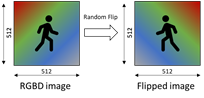

Shift Image augmentation

Zero padding is working to shift the image, since all pixels except of the person in the center are zero

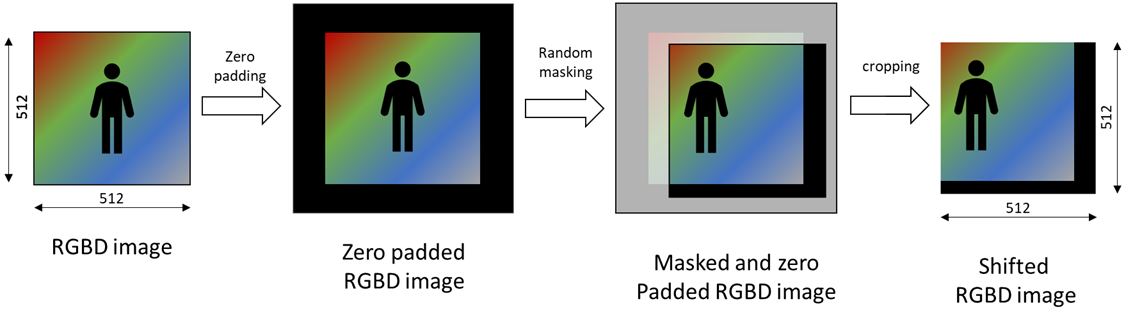

> Ideen! 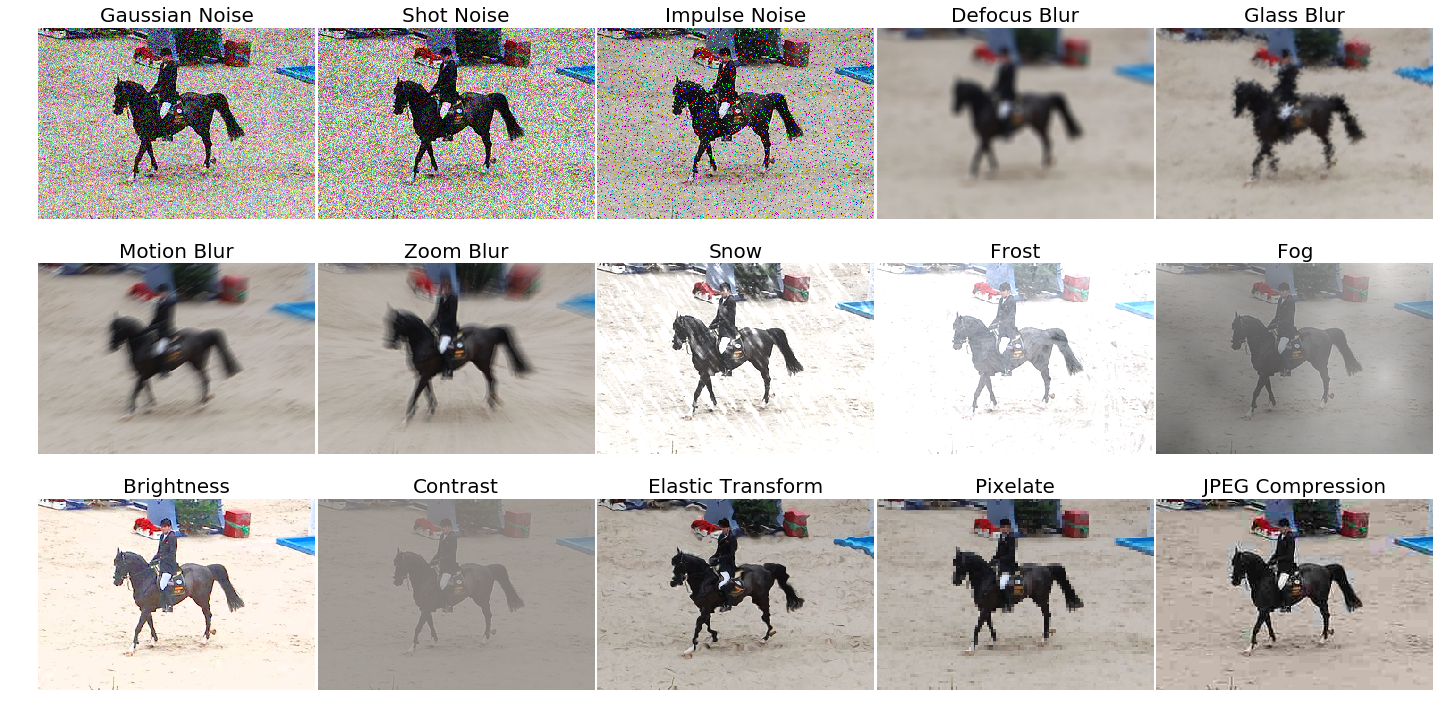

Tensorflow padding: https://www.tensorflow.org/api_docs/python/tf/pad 

In [ ]:
def Shift_image(img):
  img = tf.image.pad_to_bounding_box(image = img, offset_height = 0, offset_width = 0, target_height = (512 + 48), target_width = (512 + 200))
  img = tf.image.random_crop(value = img, size = [GLOBAL_BATCH_SIZE] +  list(IMG_SIZE),seed=RANDOM_SEED)
  return img

#def Normalize_Image(synthetic_rgbd, target_rgbd):
  # TODO: Implement!
  #img = tf.cast(img, dtype=tf.float32)
  #img[:,:,:3] /= 255  #first 3 Channel are RGB values, with 8bit, therfore normalize to 0...1
  #img[:,:,3:] /= 5
  #synthetic_rgbd[:,:,3:] -= 1
  #target_rgbd[:,:,3:] -= - 1
#  return synthetic_rgbd, target_rgbd

def Augmentate_Data(synthetic_rgbd, target_rgbd):
  # is already random
  synthetic_rgbd = tf.image.random_flip_left_right(synthetic_rgbd,seed=RANDOM_SEED)
  target_rgbd = tf.image.random_flip_left_right(target_rgbd,seed=RANDOM_SEED)
  
  # 0nly apply in roughly 50% of the cases 
  if np.random.uniform(0,1) < 0.5:
    synthetic_rgbd = Shift_image(synthetic_rgbd)

  if np.random.uniform(0,1) < 0.5:
    target_rgbd = Shift_image(target_rgbd)

  return synthetic_rgbd, target_rgbd

@tf.function
def Preprocess_Train_Data(synthetic_rgbd, target_rgbd):
  synthetic_rgbd, target_rgbd = Augmentate_Data(synthetic_rgbd, target_rgbd)
  #synthetic_rgbd, target_rgbd = Normalize_Image(synthetic_rgbd, target_rgbd)
  return synthetic_rgbd, target_rgbd

#@tf.function
#def Preprocess_Test_Data(synthetic_rgbd, target_rgbd):
#  #synthetic_rgbd, target_rgbd = Normalize_Image(synthetic_rgbd, target_rgbd)
#  return synthetic_rgbd, target_rgbd

<a name="3-2-2"></a>
### 3.2.2 Define Dataset Pipeline

Information to applied functions here: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

IMPORTANT: Call Can only be run once in Colab.... after that, the dataset needs to be created newly. 

TODO:
- [x] Check benefits of TF Records! https://www.tensorflow.org/tutorials/load_data/tfrecord
- [ ] Check interleaving 
- [ ] chaching tequniques
- [ ] update discription of get_Datasets
- [ ] Autotune splited dataset that it complies with batch size! 

When training on the TPU, synchronous data paralism is applied. In data parallel training, the same model is distributed among multiple devices. Each device is trained on a subset of the training batch. The loss of all devices is reduced by for example adding them or averaging them, depending on the loss function used. Finally, the gradients are calculated, and the model is updated on all devices. In that scenario, a single thread of the client can drive the training loop, while bulk of the model computation is distributed among several devices.

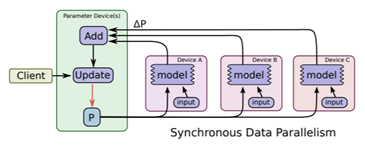

Hint: IT seems that shuffling in the test set is not required!: https://towardsdatascience.com/writing-efficient-input-pipelines-using-tensorflows-data-api-2dfc3b3ce077

Optimizing Input pipeline performance: https://www.tensorflow.org/guide/data_performance

**Best practice summary**
Here is a summary of the best practices for designing performant TensorFlow input pipelines:

- Use the prefetch transformation to overlap the work of a producer and consumer
- Parallelize the data reading transformation using the interleave transformation
- Parallelize the map transformation by setting the num_parallel_calls argument
- Use the cache transformation to cache data in memory during the first epoch
- Vectorize user-defined functions passed in to the map transformation
- Reduce memory usage when applying the interleave, prefetch, and shuffle transformations



In [ ]:
def Create_tensorflow_dataset(data, trainSplit = 0.8):
  '''
  Creates a TensorFlow dataset from a numpy tensor and optionally diveds the
  dataset into a train and test set..
 
  Inputs:  
    1. data:        Numpy array, samples of shape (num_sumples, 512, 512, 4)
    2. trainSplit:  float, value between 0...1. A training and a testset will
                    be returned according the ratio
 
  Outputs:
    [train, test], array tensorflow dataset:  contains one tensorflow dataset 
                                              split in train and test according
                                              the param trainSplit
  '''
 
  assert trainSplit <= 1.0 and trainSplit >=0 , "trainSplit needs to be a float between 0...1"
 
  numberOfSamples = data.shape[0]  
  train_size = int(trainSplit * numberOfSamples)
  train = tf.data.Dataset.from_tensor_slices(data[:train_size,...])
  test = tf.data.Dataset.from_tensor_slices(data[train_size:,...])
  print("\nDataset created. Total samples: {}, training split: {}, training samples: {}, test samples: {}".format(numberOfSamples, trainSplit, train_size, numberOfSamples-train_size))
  return [train, test]

def load_dataset(fileNames):
  ignore_order = tf.data.Options()
  ignore_order.experimental_deterministic = False  # disable order, increase speed
 
  #dataset = tf.data.TFRecordDataset(fileNames, num_parallel_reads=AUTOTUNE) #Dataset of records
  #dataset = dataset.with_options(ignore_order)  # uses data as soon as it streams in, rather than in its original order
  
  dataset = tf.data.Dataset.from_tensor_slices(fileNames)
  dataset = dataset.with_options(ignore_order)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTOTUNE)
  
  dataset = dataset.map(parse_and_decode, num_parallel_calls=AUTOTUNE) #Dataset of synthetic_image, target_image
  
  #NOT TESTED YET!!! 04.04.2021
  #dataset = dataset.cache()

  return dataset

def get_RAM_datasets(rgbd_synthetic, rgbd_target):
  ''' 
  provides a Dataset that is stored in RAM
    Input:
      rgbd_synthetic:   dataset of rgbd images from the synthetic domain. Shape: (num_samples, height, width, channel)
      rgbd_target:      dataset of rgbd images from the target domain. Shape: (num_samples, height, width, channel)
    
    Output:
      train_distributed: Distributed and ziped dataset of training images ((batch, height, width, channel),(batch, height, width, channel)) where ((train_synthetic),(train_target))
      test_distributed: Distributed and ziped dataset of test images ((batch, height, width, channel),(batch, height, width, channel)) where ((test_synthetic),(test_target))
  '''
  #Create Tensorflow Datasets for the synthetic and the target data and split them into training and test sets. 
  train_synthetic, test_synthetic = Create_tensorflow_dataset(rgbd_synthetic, trainSplit = TRAIN_SPLIT)
  train_target, test_target = Create_tensorflow_dataset(rgbd_target, trainSplit = TRAIN_SPLIT)

  #create a single train set and a single test set from the synthetic and the target data. IMPORTANT: Shapes need to match
  train = tf.data.Dataset.zip((train_synthetic, train_target))
  test = tf.data.Dataset.zip((test_synthetic, test_target))

  #test = test.map(Preprocess_Train_Data, num_parallel_calls=AUTOTUNE)

  return train, test
 
def get_TFRecord_datasets(filenames, num_samples_to_load, train_split):

  files_to_load = min(int(num_samples_to_load / RECORDS_PER_FILE), len(filenames))
  random.shuffle(filenames)
  train_size = int(files_to_load * TRAIN_SPLIT)
  trainFiles = filenames[:train_size]
  testFiles = filenames[train_size:files_to_load]
  train = load_dataset(trainFiles)
  test = load_dataset(testFiles)
  
  #dataset_full = load_dataset(filenames)
  #dataset = dataset_full.take(num_samples_to_load)
  #del dataset_full

  #train = dataset_full#dataset.take(int(train_count))
  #test = dataset_full#dataset.skip(int(train_count))

  return train, test
 
def get_distributed_datasets(train, test):
  train = (
    train
    .batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
    .map(Preprocess_Train_Data, num_parallel_calls=AUTOTUNE)
    .shuffle(BUFFER_SIZE,seed=RANDOM_SEED)
    .prefetch(AUTOTUNE)
    #.repeat()
  )
 
  test = (
    test
    .batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
    #.map(Preprocess_Test_Data, num_parallel_calls=AUTOTUNE) #currently there is no preprocessing for test images! 
    .prefetch(AUTOTUNE)
    #.repeat()
  )
 
  train_distributed = strategy.experimental_distribute_dataset(train)
  test_distributed = strategy.experimental_distribute_dataset(test)
  del train, test
 
  return train_distributed, test_distributed

In [ ]:
#Generate TFRecords if configured 
if DATASOURCE == "generated_from_drive":
  if DATASET_STORAGE_SCHEME == 'binary_stream_disk':
    Load_and_Combine_Training_Samples(DATA_DIRECTORY_NAME, NUM_SAMPLES_TO_LOAD)
    FILENAMES = tf.io.gfile.glob("{}/TFRecord_Files/*.tfrecords".format(BASE_VM_DIRECTORY))
    trainDataset, testDataset = get_TFRecord_datasets(FILENAMES, NUM_SAMPLES_TO_LOAD, TRAIN_SPLIT)
 
  else: # DATASET_STORAGE_SCHEME == loaded_to_RAM
    rgbd_synthetic, rgbd_target = Load_and_Combine_Training_Samples(DATA_DIRECTORY_NAME, NUM_SAMPLES_TO_LOAD)
    #create Dataset
    trainDataset, testDataset = get_RAM_datasets(rgbd_synthetic, rgbd_target)
    # free up RAM
    del rgbd_synthetic, rgbd_target

else: # DATASOURCE == "cloud_bucket"
  FILENAMES = tf.io.gfile.glob("{}/{}/*.tfrecords".format(GCS_PATTERN, DATA_DIRECTORY_NAME))
  trainDataset, testDataset = get_TFRecord_datasets(FILENAMES, NUM_SAMPLES_TO_LOAD, TRAIN_SPLIT)

print("DATASOURCE: {}".format(DATASOURCE))
print("DATASET_STORAGE_SCHEME: {}".format(DATASET_STORAGE_SCHEME))
print(trainDataset)

In [ ]:
#cnt = trainDataset.reduce(np.int64(0), lambda x, _: x + 1)
#print(cnt)
#cnt = testDataset.reduce(np.int64(0), lambda x, _: x + 1)
#print(cnt)

In [ ]:
#train_size = int(0.8 * NUM_SAMPLES_TO_LOAD / RECORDS_PER_FILE)
#train = FILENAMES[:train_size]
#test = FILENAMES[train_size:]
#print("Length of FILENAMES: {}".format(len(FILENAMES)))
#print("Length of train: {}".format(len(train)))
#print("Length of test: {}".format(len(test)))

<a name="3-2-x"></a>
### 3.2.x CutMix

Inspired by: 
- U-Net based Discriminator 
- and http://arxiv.org/abs/1905.04899 

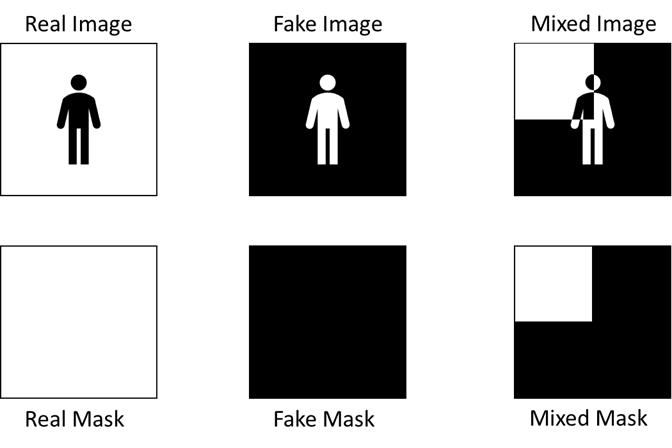

In [ ]:
def random_boundingbox(height, width, lam):
    r = np.sqrt(1. - lam)
    w = np.int(width * r)
    h = np.int(height * r)
    x = np.random.randint(width)
    y = np.random.randint(height)

    x1 = np.clip(x - w // 2, 0, width)
    y1 = np.clip(y - h // 2, 0, height)
    x2 = np.clip(x + w // 2, 0, width)
    y2 = np.clip(y + h // 2, 0, height)

    return x1, y1, x2, y2

def CutMix(batch1, batch2):
    batch_size, height, width, channel = batch1.shape
    mask = np.ones(shape=(batch_size, height, width, channel))
    batch1 = tf.cast(batch1,tf.float32)
    batch2 = tf.cast(batch2,tf.float32)

    imgs = []
    for element in range(batch_size):
      
      lam = np.random.beta(1,1)
      x1, y1, x2, y2 = random_boundingbox(height, width, lam)

      mask[element, x1:x2,y1:y2,:]=0

      # CHOOSE RANDOM IMAGE from batch TO CUTMIX WITH
      index = int(np.random.uniform(0,batch_size))
      
      one = batch1[element, y1:y2, 0:x1, :]
      two = batch2[index, y1:y2, x1:x2, :]
      three = batch1[element, y1:y2, x2:width, :]
      middle = tf.concat([one,two,three],axis=1)
      img = tf.concat([batch1[element,0:y1,:,:],middle,batch1[element,y2:height,:,:]],axis=0)
      imgs.append(img)

      #print("Shape one:{}".format(one.shape))
      #print("Shape two:{}".format(two.shape))
      #print("Shape three:{}".format(three.shape))
      #print("Shape middle:{}".format(middle.shape))
      #print("Shape img:{}".format(img.shape))
      #print("Shape imgs:{}".format(np.shape(imgs)))

    new_batch = tf.reshape(tf.stack(imgs),(batch_size, height, width, channel))
    #new_batch = tf.convert_to_tensor(new_batch, dtype=tf.float32) 
    mask = tf.convert_to_tensor(mask, dtype=tf.float32)

    
    return mask, new_batch
    
def GetImageAndMask(batch1,batch2,cutmix = True, probability = 0.5):
  if cutmix and np.random.uniform(0,1) < probability:
    return CutMix(batch1, batch2)
  else:
    mask = tf.ones_like(batch1)
    new_batch = batch1
    return mask, new_batch



In [ ]:
#testcode
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:
  dataset = list(testDataset.take(8).as_numpy_iterator()) # get 1 sample of the dataset

  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)

  element = 1

  rgbd_synthetic = tf.cast(rgbd_synthetic, tf.float32)
  rgbd_target = tf.cast(rgbd_target, tf.float32)

  mask, new_batch = GetImageAndMask(rgbd_synthetic, rgbd_target, cutmix = True, probability = 0.8)

  mask = tf.cast(mask, tf.float32)
  new_batch = tf.cast(new_batch, tf.float32)


  inverse_mask = 1 - mask
  fig = plt.figure(figsize=[20,6])
  fig.suptitle("CutMix Example", fontsize=20)

  ax = fig.add_subplot(1, 4, 1)
  imgplot = plt.imshow(mask[element,:,:,0])
  ax.set_title('Mask')
  #plt.colorbar()

  #masked = tf.cast(tf.multiply(rgbd_synthetic[element,...], mask[element,...]),tf.float32)
  masked = rgbd_synthetic[0,...]
  ax = fig.add_subplot(1, 4, 2)
  imgplot = plt.imshow(masked)
  ax.set_title('Masked Synthetic')

  masked_inverse = tf.cast(tf.multiply(rgbd_target[element,...], inverse_mask[element,...]),tf.float32)
  ax = fig.add_subplot(1, 4, 3)
  imgplot = plt.imshow(masked_inverse)
  ax.set_title('Masked Target')

  ax = fig.add_subplot(1, 4, 4)
  imgplot = plt.imshow(new_batch[element,...])
  ax.set_title('CutMix Image')

  #Plot_RGBD_Sample(new_batch[element,...], normalize = False , title = "Synthetic Domain RGBD Example")

  plt.show()

<a name="3-3"></a>
## 3.3 Analyze Data

The analysis of the data is performed on the test data. The training data is augmentated, and therefor not representative anymore! the testdata is only normalized.

HINT: Matplotlib does not support float 16 ... 

Ideas:
- Image gradients (detect smoothnes of images and edges)
- 

<a name="3-3-1"></a>
### 3.3.1 Plot Test Samples

No random seed on purpose!

In [ ]:
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:
  dataset = list(trainDataset.shuffle(BUFFER_SIZE).take(10).as_numpy_iterator()) # get 1 sample of the dataset
  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)
  Plot_Multiple_RGBD(rgbd_synthetic, rows = 2, columns = 5, plot_title = "Synthetic Domain")
  Plot_Multiple_RGBD(rgbd_target, rows = 2, columns = 5, plot_title = "Target Domain")

In [ ]:
Run_Cell = False #@param {type:"boolean"}
normalize = False #@param {type:"boolean"}
if Run_Cell:

  dataset = list(testDataset.shuffle(BUFFER_SIZE).take(1).as_numpy_iterator()) # get 1 sample of the dataset
  #dataset = list(testDataset.take(10).as_numpy_iterator()) # get 1 sample of the dataset
  print(np.shape(dataset))

  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)

  #mask = np.zeros_like(rgbd_synthetic)
  #mask[rgbd_synthetic!=0] = 1
  #rgbd_synthetic = tf.image.random_brightness(rgbd_synthetic,0.4)
  #rgbd_synthetic = tf.image.stateless_random_contrast(tf.cast(rgbd_synthetic,tf.float32),0.2,0.5,(1, 1))
  #rgbd_synthetic = tf.image.stateless_random_hue(tf.cast(rgbd_synthetic,tf.float32),0.2,(1, 1))
  #rgbd_synthetic= tf.multiply(mask,rgbd_synthetic)


  #Inspect Datasamples
  Plot_RGBD_Sample(rgbd_synthetic[0,...], normalize = normalize , title = "Synthetic Domain RGBD Example")
  Plot_RGBD_Sample(rgbd_target[0,...], normalize = normalize,  title = "Target Domain RGBD Example")
  
  if COLOR_MODE == "RGB":
    Plot_RGBD_Seperatly(rgbd_synthetic[0,...], normalize = normalize,  title = "Synthetic Domain RGBD Example")
    Plot_RGBD_Seperatly(rgbd_target[0,...], normalize = normalize, title = "Target Domain RGBD Example")

  del dataset, rgbd_synthetic, rgbd_target

<a name="3-3-2"></a>
### 3.3.2 Principal Component Analysis

WICHTIG:
- ~~first combine data and then perform PCA~~
- first calculate pca, then combine! reason: the main components for both inputs would change, eventhough only one dataset is changed!!!



---



Guides:
> Principal Component Analysis in 3 Simple Steps: https://sebastianraschka.com/Articles/2015_pca_in_3_steps.html


---


TODO:
- [x] write PCA method that is called later
- [ ] check if it does more sense to only evaluate the depths, since this is the importent channel!

In [ ]:
def Run_PCA(synthetic, target, dimension, mode, writeToTensorboard, log_dir = None, epoch = None, model_name = NAME):
  #print("Calculating PCA...")
  pca = PCA(dimension)
  shape_synthetic = synthetic.shape
  num_samples_synthetic = shape_synthetic[0]
  flatten_length_synthetic = shape_synthetic[1] * shape_synthetic[2] * shape_synthetic[3]

  shape_target = target.shape
  num_samples_target = shape_target[0]
  flatten_length_target = shape_target[1] * shape_target[2] * shape_target[3]

  #print("synthetic.shape: {}".format(shape_synthetic))
  #print("target.shape: {}".format(shape_target))

  # reshape inputs
  temp1 = np.reshape(synthetic,(num_samples_synthetic,flatten_length_synthetic))
  temp2 = np.reshape(target,(num_samples_target,flatten_length_target))
  
  del synthetic, target

  #print("temp1.shape: {}".format(temp1.shape))
  #print("temp2.shape: {}".format(temp2.shape))
  projected1 = pca.fit_transform(temp1)
  projected2 = pca.fit_transform(temp2)
  del temp1, temp2
  #print("projected1.shape: {}".format(projected1.shape))
  #print("projected2.shape: {}".format(projected2.shape))

  df1 = pd.DataFrame(projected1)
  df1['domain'] = 'synthetic'
  df2 = pd.DataFrame(projected2)
  df2['domain'] = 'target'
  df12 = df1.append(df2)
  del projected1, projected2, df1, df2

  # plot data
  plt.ioff() # turn off automatic plot 
  g = sns.pairplot(data=df12, hue='domain')
  g.fig.suptitle("Principal Component Analysis.Samples:{}, Mode: {}, Color_Mode: {}".format(shape_synthetic[0],mode, COLOR_MODE), y=1.04) # y= some height>1
  g.map_diag(sns.kdeplot)
  
  g.add_legend()

  if writeToTensorboard:
    with tf.device('/job:localhost'): 
      with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.image("PCA", plot_to_image(g.fig), step= epoch)
  else:
    g

  #restore automatic plot!  
  plt.ion()
  # Free RAM memory (When run in method, garbage collection should take cake when scope left)
  del df12, g
  #print("Finished!")

def Run_PCA_on_dataset(dataset,  dimension = 5, mode = "image_depth", writeToTensorboard = False, log_dir = None, epoch = None):
  # Test Code for PCA - combine synthetic and target domain, perform pca and then create a single data set

  if mode == "image_depth":
    # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
    synthetic, target = np.einsum('dshwc->sdhwc', dataset)
  elif mode == "image":
    # swap dimensions of dataset and select every channel without depth
    synthetic, target = np.einsum('dshwc->sdhwc', dataset)[:,:,:,:,0:-1]
  elif mode == "depth":
    # swap dimensions of dataset and select depth channel only
    synthetic, target = np.einsum('dshwc->sdhwc', dataset)[:,:,:,:,-1:]
  else:
    print("Unvalid mode provided!")
    return

  del dataset

  Run_PCA(synthetic, target, dimension, mode, writeToTensorboard, log_dir = log_dir, epoch = epoch)

In [ ]:
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:
  dataset = list(trainDataset.shuffle(BUFFER_SIZE).take(-1).as_numpy_iterator()) # get all samples of the dataset
  Run_PCA_on_dataset(dataset, dimension = 5, mode = "image_depth")
  #Run_PCA_on_dataset(dataset, dimension = 5, mode = "image")
  #Run_PCA_on_dataset(dataset, dimension = 5, mode = "depth")

<a name="4"></a>
# 4 - Defining the Model

Usefull Links:


*   Layer API: https://www.tensorflow.org/api_docs/python/tf/keras/layers
*   Model API: https://www.tensorflow.org/api_docs/python/tf/keras/Model
*   Tensorflow AdOns API: https://www.tensorflow.org/addons/api_docs/python/tfa 
*   Tensor Flow Dataset API (not tfds!): https://www.tensorflow.org/api_docs/python/tf/data/Dataset


---




Hint from TensorFlow Documentation (https://www.tensorflow.org/guide/keras/custom_layers_and_models):

"*In general, you will use the Layer class to define inner computation blocks, and will use the Model class to define the outer model -- the object you will train.*"

Ich werde trotzdem ein Model nehmen, einfach wegen summary and plot!

---
TODO: 

>Normalization Techniques:
https://medium.com/techspace-usict/normalization-techniques-in-deep-neural-networks-9121bf100d8

> Note: 
- Batch-norm mit batchsize 1 macht kein sinn
- instance norm scheint schlecht zu sein für style transfer and contrast...

> Check channel shuffeling techniques. Examle given in https://towardsdatascience.com/review-shufflenet-v1-light-weight-model-image-classification-5b253dfe982f 





<a name="4-1"></a>
## 4.1 Custom Layer
Keep in Mind: There are <b>no activations possible in custom layers</b> if not manually implemented!

---

Reflection Padding is used in original cycleGAN paper. 

Reflection PAdding works on CPU, but is yet not supported for TPUs : https://cloud.google.com/tpu/docs/tensorflow-ops 

Solution: Symmetry Padding is a similar approach that is still better than zero padding

TPU does not support Gradient calculation of mirrored paddings like "SYMMETRIC" and "REFLECTION" Therefore, a custom gradient needs to be defined as well, by cropping the padding and passing the gradients from the previous layer. 

Custom Gradient: https://www.tensorflow.org/api_docs/python/tf/custom_gradient 

Crop_to_bounding Box: https://www.tensorflow.org/api_docs/python/tf/image/crop_to_bounding_box

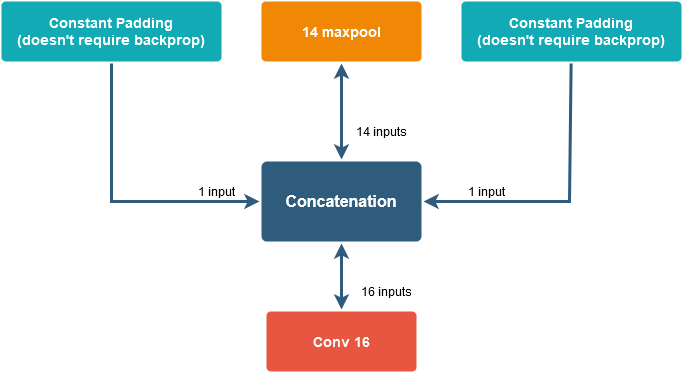


In [ ]:
class ReflectionPadding2D(tf.keras.layers.Layer):
  """Implements Reflection Padding as a layer.
  Args:
      padding(tuple): Amount of padding for the
      spatial dimensions.
  Returns:
      A padded tensor with the same type as the input tensor.
  """

  def __init__(self, padding=(1, 1), **kwargs):
    self.padding = tuple(padding)
    super(ReflectionPadding2D, self).__init__(**kwargs)
  
  @tf.custom_gradient
  def padding_func(self, input_tensor):
    padding_width, padding_height = self.padding
    padding_tensor = [
      [0, 0],
      [padding_height, padding_height],
      [padding_width, padding_width],
      [0, 0],
    ]
    result = tf.pad(input_tensor, padding_tensor, mode="REFLECT")

    # upstream gradient is the chainrule of all previous gradients!
    def custom_grad(upstream):
      #The gradients that represent the padding are cut, since they are not relevant! 
      custom_grad = tf.image.crop_to_bounding_box(
          image = upstream, 
          offset_height = 0, 
          offset_width = 0, 
          target_height = upstream.shape[1]- 2 * padding_height, 
          target_width= upstream.shape[2] - 2* padding_width
          )
      new_upstream = custom_grad
      return new_upstream #new upstream gradient!

    return result, custom_grad

  def compute_output_shape(self, input_shape):
    """ If you are using "channels_last" configuration"""
    return (input_shape[0], input_shape[1] + 2 * self.padding[0], input_shape[2] + 2 * self.padding[1], input_shape[3])

  def call(self, input_tensor, mask=None):
    return self.padding_func(input_tensor)

<a name="4-2"></a>
## 4.2 Basic Building Blocks

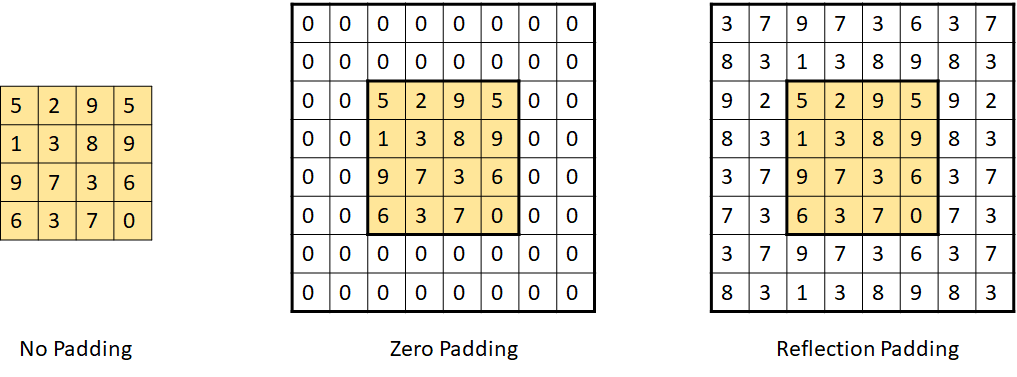

In [ ]:
def pad_func(padding=(1, 1), pad_type = PADDING_TYPE):
  if pad_type == "reflection":
    return ReflectionPadding2D(padding=padding)
  elif pad_type == "zero":
    return tf.keras.layers.ZeroPadding2D(padding=padding)
  else:
    raise Exception("Undefined padding type provided")


In [ ]:
def activation_func(activationFuncString):
  if activationFuncString == "relu":
    return tf.keras.layers.ReLU()
  elif activationFuncString == "leaky_relu":
    return tf.keras.layers.LeakyReLU()
  elif activationFuncString == "elu":
    return tf.keras.layers.ELU()
  elif activationFuncString == "prelu":
    return tf.keras.layers.PReLU(shared_axes=[1, 2]) #each filter has only one param!
  elif activationFuncString == "tanh":
    return tf.keras.activations.tanh
  elif activationFuncString == "sigmoid":
    return tf.keras.activations.sigmoid
  elif activationFuncString == "hard_sigmoid":
    return tf.keras.activations.hard_sigmoid
  elif activationFuncString == None:
    return tf.keras.activations.get(None)
  else:
    raise Exception("Undefined activation type provided")

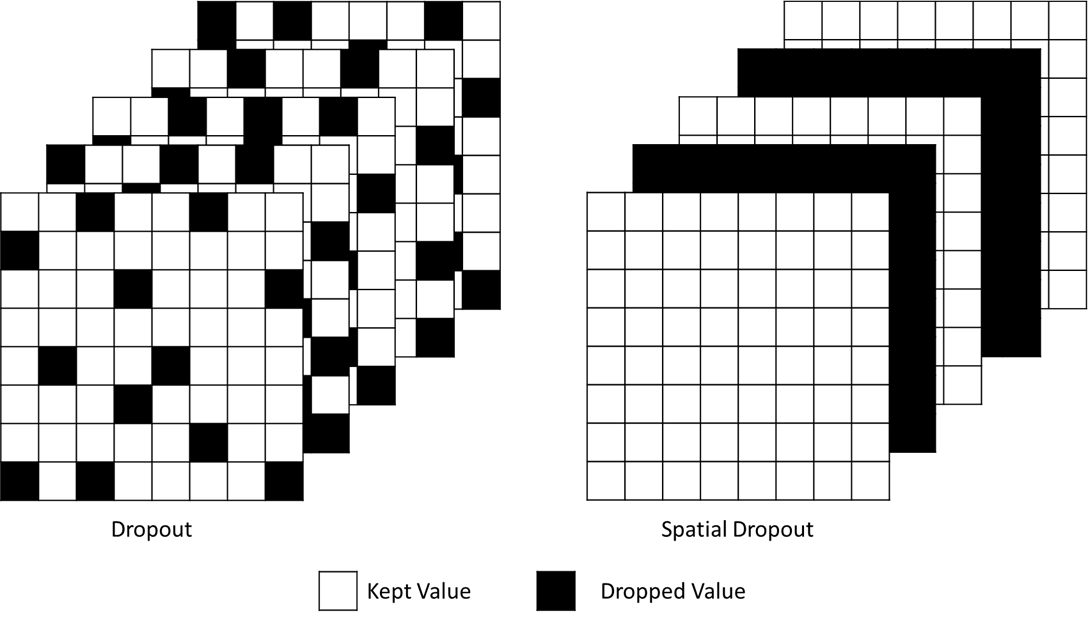

<a name="4-2-x"></a>
### 4.2.x Convolutional Block

Helper:
TODO: 
- [x] check if activation and normalization after each conv or after block! 
- [x] check if last conv requires normalization or normalization!
- [x] check how and when to applay dropout! in the cycleGAN example of tensorflow, it is only used in the generators
- [ ] check if 1 convolution is sufficient in conv2d_block and if it could be traded for more layers! 

Changes made: 06.03.2021:
- added use_bias = false! to conv2D. In that way the model might fit better into the TPU
- added the possibility to limit the maximum channel count even if more layers are added! 

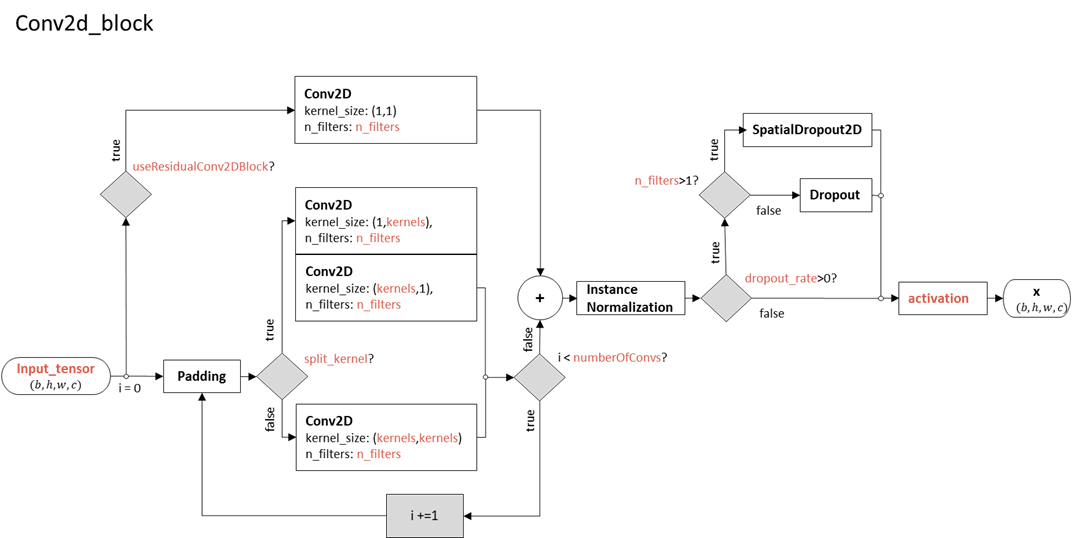

In [ ]:
def conv2d_block(input_tensor, n_filters, useResidualConv2DBlock, kernels, split_kernels, numberOfConvs, activation, dropout_rate=0):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  pad = int((kernels-1)/2) # assumes odd kernel size, which is typical!

  # first layer
  x = input_tensor
  for i in range(numberOfConvs):
    x = pad_func(padding = (pad,pad))(x)
    if split_kernels:
      x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (1, kernels), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(x)
      x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernels, 1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(x)
    else:
      x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernels, kernels), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(x)
    
  if useResidualConv2DBlock:
    residual = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = 1, kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(input_tensor)
    x = tf.keras.layers.Add()([x, residual])

  x = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INIT)(x)
  if dropout_rate > 0:
    if n_filters > 1:
      x = tf.keras.layers.SpatialDropout2D(dropout_rate)(x)
    else:
      x = tf.keras.layers.Dropout(dropout_rate)(x)
  x = activation_func(activation)(x)
  
  return x

#Testcode

#inputs = tf.keras.layers.Input(shape = (512,512,4))
#model = tf.keras.Model(inputs=inputs, outputs=conv2d_block(inputs, n_filters = 1,useResidualConv2DBlock = False, kernels = 5, split_kernels  = False, numberOfConvs = 2, activation = "prelu",dropout_rate =0.2))
#model.summary()
#model_filename = '{}_gen_model.png'.format(NAME)
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, show_dtype=True, to_file=model_filename)


<a name="4-2-1"></a>
### 4.2.1 Down-Sample Model Block

<b>TODO:</b> 


1.   Vergleich verschiedener Downsample Blöcke.
  1.   Conv2D
  2.   Pooling
  3.   Downsample Block
  3.   Mehrere Convolution, dann downsampling







TODO:
- [ ] ICh uss beim Downsampling aufpassen, dass die Channel richtig sind bei pooling und space_to_depth, da hierr ggf. keine convolution vorher ist! Gerade beim U-Net wird das nur funktionieren, da ich vorher conv2D Blocks habe ich ansonstenten nicht auf die 64 channel komme z.b.!

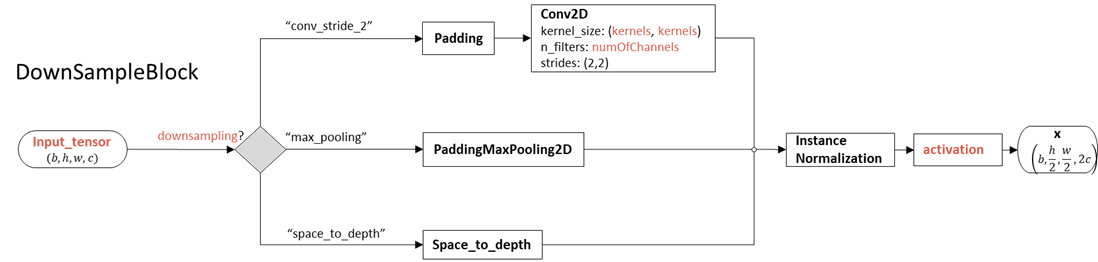

In [ ]:
def DownSampleBlock(input_tensor, numOfChannels, kernels, downsampling, activation):
  if downsampling == "conv_stride_2":
    pad = int((kernels-1)/2) # assumes odd kernel size, which is typical!
    x = pad_func(padding = (pad,pad))(input_tensor)
    x = tf.keras.layers.Conv2D(numOfChannels, kernel_size = (kernels, kernels), strides=(2,2), kernel_initializer = KERNEL_INIT, use_bias = USE_BIAS_NODES)(x)
  elif downsampling == "max_pooling":
    #Downsampling in this case is done by the conv2D_block specified later!
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(input_tensor)
  elif downsampling == "space_to_depth":
    x = tf.nn.space_to_depth(input_tensor, block_size = 2)
  else:
    raise Exception("Undefined downsampling provided")

  x = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INIT)(x)
  x = activation_func(activation)(x)
  return x

  
#Testcode
#inputs = tf.keras.layers.Input(shape = (512,512,4))
#model = tf.keras.Model(inputs=inputs, outputs=DownSampleBlock(inputs, numOfChannels = 64, kernels = 3,  downsampling = "conv_stride_2", activation = "leaky_relu"))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, show_dtype=False)

<a name="4-2-2"></a>
### 4.2.2 Up-Sample Model Block

It seems that using Upsampling2D is favorable over Conv2DTranspose (see book Generative Deep Learning Teaching Machines to Paint, Write, Compose and Play)

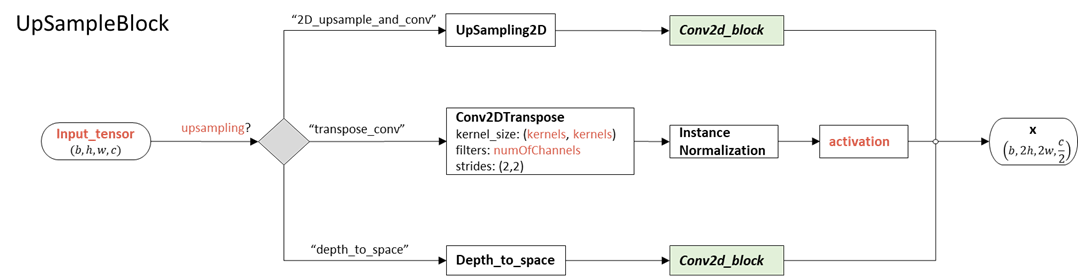

In [ ]:
def UpSampleBlock(input_tensor, numOfChannels,  kernels , split_kernels, upsampling , activation):
  pad = int((kernels-1)/2) # assumes odd kernel size, which is typical!
  if upsampling == "2D_upsample_and_conv":
    x = tf.keras.layers.UpSampling2D()(input_tensor)
    x = conv2d_block(x, n_filters = numOfChannels, useResidualConv2DBlock = False, kernels = kernels, split_kernels = split_kernels, numberOfConvs = 1, activation = activation)
  elif upsampling == "transpose_conv":
    x = tf.keras.layers.Conv2DTranspose(numOfChannels,kernel_size = (kernels, kernels),strides=(2,2),kernel_initializer = KERNEL_INIT,padding='same',use_bias = USE_BIAS_NODES)(input_tensor)
    x = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INIT)(x)
    x = activation_func(activation)(x)
  elif upsampling == "depth_to_space":
    x = tf.nn.depth_to_space(input_tensor, block_size = 2)
    x = conv2d_block(x, n_filters = numOfChannels, useResidualConv2DBlock = False, kernels = kernels, split_kernels = split_kernels, numberOfConvs = 1, activation = activation)
  else:
    raise Exception("Undefined upsampling provided")
  
  return x

#Testcode
#inputs = tf.keras.layers.Input(shape = (512,512,4))
#model = tf.keras.Model(inputs=inputs, outputs=UpSampleBlock(inputs, numOfChannels = 64, kernels = 5, upsampling = "depth_to_space", split_kernels  = True, activation = "leaky_relu"))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, show_dtype=False)

<a name="4-2-3"></a>
### 4.2.3 Residual Identity Model Block

Der unten gezeigte Residualblock unterscheidet sich noch von dem CycleGAN Beispiel...

Idea: Deep Residual Learning for Image Recognition http://arxiv.org/abs/1512.03385 

Fazit: 
- Deep version has much less numbers of parameters while having similar performance!!!

TODO:
- [x] Check whether to use batchnorm or instance norm... upsampleblock and downsampleblock use instancenorm...

-> I swapped batchnorm for intance norm! 
TODO: 
- [ ] use conv2d block!

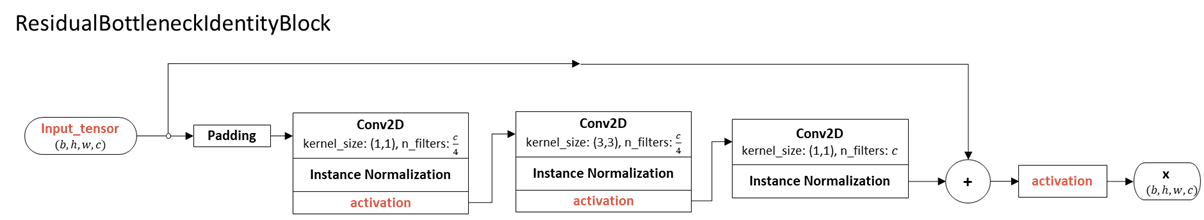

In [ ]:
def ResidualBottleneckIdentityBlock(input_tensor, activation):
  numFilters = K.int_shape(input_tensor)[-1]

  x = pad_func(padding = (1,1))(input_tensor) #padding=1 since 1 times 3x3 kernels bellow

  x = tf.keras.layers.Conv2D(int(numFilters/4), kernel_size = (1,1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(x)
  x = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INIT)(x)
  x = activation_func(activation)(x)

  x = tf.keras.layers.Conv2D(int(numFilters/4), kernel_size = (3,3), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(x)
  x = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INIT)(x)
  x = activation_func(activation)(x)

  x = tf.keras.layers.Conv2D(numFilters, kernel_size = (1,1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(x)
  x = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INIT)(x)

  x = tf.keras.layers.Add()([x, input_tensor])
  x = activation_func(activation)(x)

  return x 

#Testcode
#inputs = tf.keras.layers.Input(shape = (64,64,512))
#model = tf.keras.Model(inputs=inputs, outputs=ResidualBottleneckIdentityBlock(inputs, activation = "leaky_relu"))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, show_dtype=False)

<a name="4-2-x"></a>
### 4.2.x Residual Downsampling

Idea: Large Scale GAN Training for High Fidelity Natural Image Synthesis, http://arxiv.org/abs/1809.11096

TODO:
 - [ ] implement with conv2d block and downsample Block


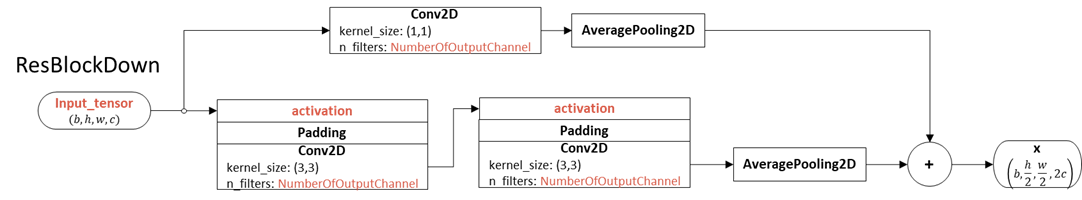

In [ ]:
def ResBlockDown(input_tensor, NumberOfOutputChannel, activation ):
  path1 = input_tensor
  path2 = input_tensor

  path1 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (1,1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(path1)
  path1 = tf.keras.layers.AveragePooling2D()(path1)

  path2 = activation_func(activation)(path2)
  path2 = pad_func(padding = (1,1))(path2) #padding=1 since 3x3 kernel bellow
  path2 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (3,3), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(path2)
  path2 = activation_func(activation)(path2)
  path2 = pad_func(padding = (1,1))(path2) #padding=1 since 3x3 kernel bellow
  path2 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (3,3), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(path2)
  skip = path2
  path2 = tf.keras.layers.AveragePooling2D()(path2)
  
  output = tf.keras.layers.Add()([path1, path2])

  return output, skip

#Testcode
#input = tf.keras.layers.Input(shape=IMG_SIZE)
#model = tf.keras.Model(inputs=input, outputs=ResBlockDown(input, 8, activation = "leaky_relu"))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-2-x"></a>
### 4.2.x Residual Upsampling!

Idea: Large Scale GAN Training for High Fidelity Natural Image Synthesis, http://arxiv.org/abs/1809.11096

TODO:
 - [ ] implement with conv2d block and upsample Block

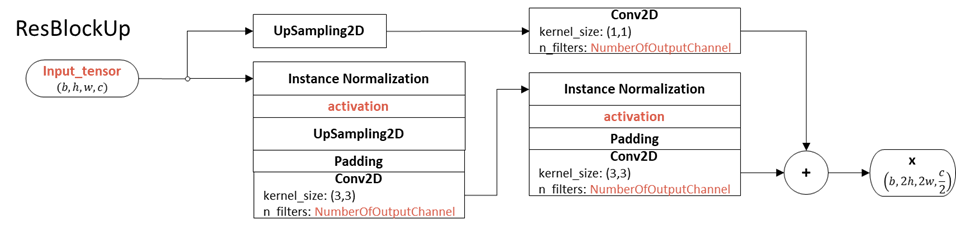

In [ ]:
def ResBlockUp(input_tensor, NumberOfOutputChannel, activation):

  path1 = input_tensor
  path2 = input_tensor

  path1 = tf.keras.layers.UpSampling2D()(path1)
  path1 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (1,1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(path1)

  path2 = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INIT)(path2)
  path2 = activation_func(activation)(path2)
  path2 = tf.keras.layers.UpSampling2D()(path2)
  path2 = pad_func(padding = (1,1))(path2) #padding=1 since 3x3 kernel bellow
  path2 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (3,3), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(path2)
  path2 = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INIT)(path2)
  path2 = activation_func(activation)(path2)
  path2 = pad_func(padding = (1,1))(path2) #padding=1 since 3x3 kernel bellow
  path2 = tf.keras.layers.Conv2D(filters = NumberOfOutputChannel, kernel_size = (3,3), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(path2)

  output = tf.keras.layers.Add()([path1, path2])

  return output

#Testcode
#inputs = tf.keras.layers.Input(shape=IMG_SIZE)
#model = tf.keras.Model(inputs=inputs, outputs=ResBlockUp(inputs, 4, activation = "leaky_relu"))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-2-x"></a>
### 4.2.x Non-local Block

Non-Local Block Paper: https://arxiv.org/pdf/1711.07971.pdf

Implementation based on Code: https://github.com/Tramac/Non-local-tensorflow/blob/master/non_local/non_local_dot_product.py

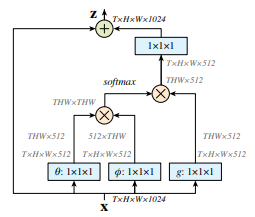

In [ ]:
def NonLocalBlock(input_tensor):
  numChannel = K.int_shape(input_tensor)[-1]
  batchSize, height, width = tf.shape(input_tensor)[0:3]

  intermediateChannel = int(numChannel/2)

  theta = tf.keras.layers.Conv2D(filters = intermediateChannel, kernel_size = (1,1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(input_tensor)
  theta = tf.keras.layers.Reshape(target_shape=(-1, intermediateChannel))(theta)

  phi = tf.keras.layers.Conv2D(filters = intermediateChannel, kernel_size = (1,1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(input_tensor)
  phi = tf.keras.layers.MaxPooling2D()(phi)
  phi = tf.keras.layers.Reshape(target_shape=(intermediateChannel, -1))(phi)

  g = tf.keras.layers.Conv2D(filters = intermediateChannel, kernel_size = (1,1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(input_tensor)
  g = tf.keras.layers.MaxPooling2D()(g)
  g = tf.keras.layers.Reshape(target_shape=(-1, intermediateChannel))(g)

  theta_phi = tf.matmul(theta, phi)
  theta_phi = tf.keras.layers.Activation('softmax')(theta_phi)

  theta_phi_g = tf.matmul(theta_phi, g)
  #theta_phi_g = tf.keras.layers.Lambda(tf.matmul)([theta_phi, g])
  theta_phi_g = tf.reshape(theta_phi_g, (batchSize, height, width, intermediateChannel))

  theta_phi_g = tf.keras.layers.Conv2D(filters = intermediateChannel * 2, kernel_size = (1,1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(theta_phi_g)
  theta_phi_g = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INIT)(theta_phi_g)
  z = tf.keras.layers.Add()([theta_phi_g, input_tensor])

  return z

#Testcode
#input = tf.keras.layers.Input(shape=IMG_SIZE)
#model = tf.keras.Model(inputs=input, outputs=NonLocalBlock(input))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

<a name="4-x"></a>
## 4.x Sub-Model Blocks

<a name="4-2-x"></a>
### 4.2.x Encoder

Todo: 
- [x] include residual blocks!

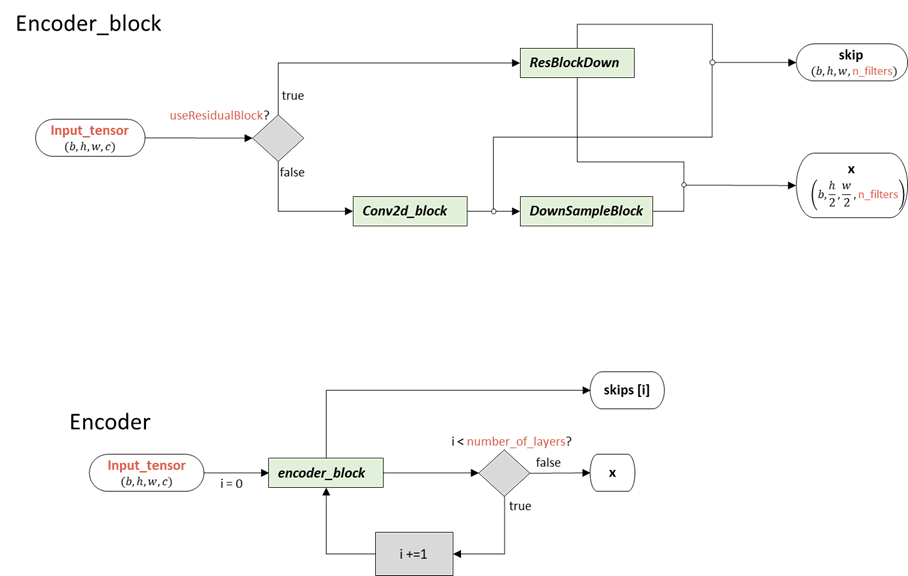

In [ ]:
def encoder_block(input_tensor, n_filters, useResidualConv2DBlock, downsampling, kernels, split_kernels, useResidualBlock, numberOfConvs, activation):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
  '''

  if useResidualBlock:
    x, skip = ResBlockDown(input_tensor, NumberOfOutputChannel = n_filters, activation = activation)
  else:
    skip = conv2d_block(input_tensor, n_filters=n_filters, useResidualConv2DBlock =  useResidualConv2DBlock, kernels = kernels,split_kernels = split_kernels, activation = activation, numberOfConvs=numberOfConvs)
    x = DownSampleBlock(input_tensor = skip, numOfChannels = n_filters, kernels = kernels, downsampling = downsampling, activation=activation)

  return skip, x


def encoder(input_tensor, number_of_layers, n_filters, limit_n_filters, useResidualConv2DBlock, downsampling, kernels, split_kernels,numberOfConvs,activation, useResidualBlock = False):
  '''
  This function defines the encoder or downsampling path.

  Args:
    input_tensor (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''

  x = input_tensor
  skips = []

  for i in range(number_of_layers):
    number_of_filters = min(n_filters * 2**i, limit_n_filters) #i=0 -> 64, i=1 -> 128, i=2 -> 256, ...
    skip, x = encoder_block(x, n_filters=number_of_filters, useResidualConv2DBlock = useResidualConv2DBlock, downsampling = downsampling, kernels = kernels, split_kernels = split_kernels, useResidualBlock=useResidualBlock,numberOfConvs=numberOfConvs,activation=activation)
    skips.append(skip)
  
  return x, skips

<a name="4-2-3"></a>
### 4.2.3 Bottle Neck

Todo: 
- [x] include residual blocks!

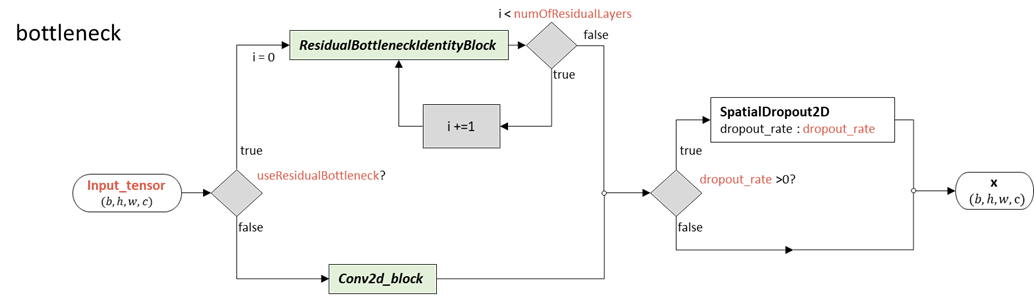

In [ ]:
def bottleneck(input_tensor, useResidualBottleNeck, numOfResidualLayers, useResidualConv2DBlock, kernels,split_kernels,numberOfConvs, activation , dropout_rate=DROPOUT_RATE):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  numFilters = K.int_shape(input_tensor)[-1]

  x = input_tensor
  if useResidualBottleNeck:
    for i in range(numOfResidualLayers):
      x = ResidualBottleneckIdentityBlock(input_tensor = x, activation = activation)  
  else:
    x = conv2d_block(x, n_filters=numFilters, useResidualConv2DBlock = useResidualConv2DBlock, kernels = kernels, split_kernels = split_kernels,numberOfConvs=numberOfConvs,activation=activation)

  if dropout_rate > 0:
    x = tf.keras.layers.SpatialDropout2D(dropout_rate)(x)

  return x

<a name="4-2-x"></a>
### 4.2.x Decoder

Todo: 
- [x] include residual blocks!

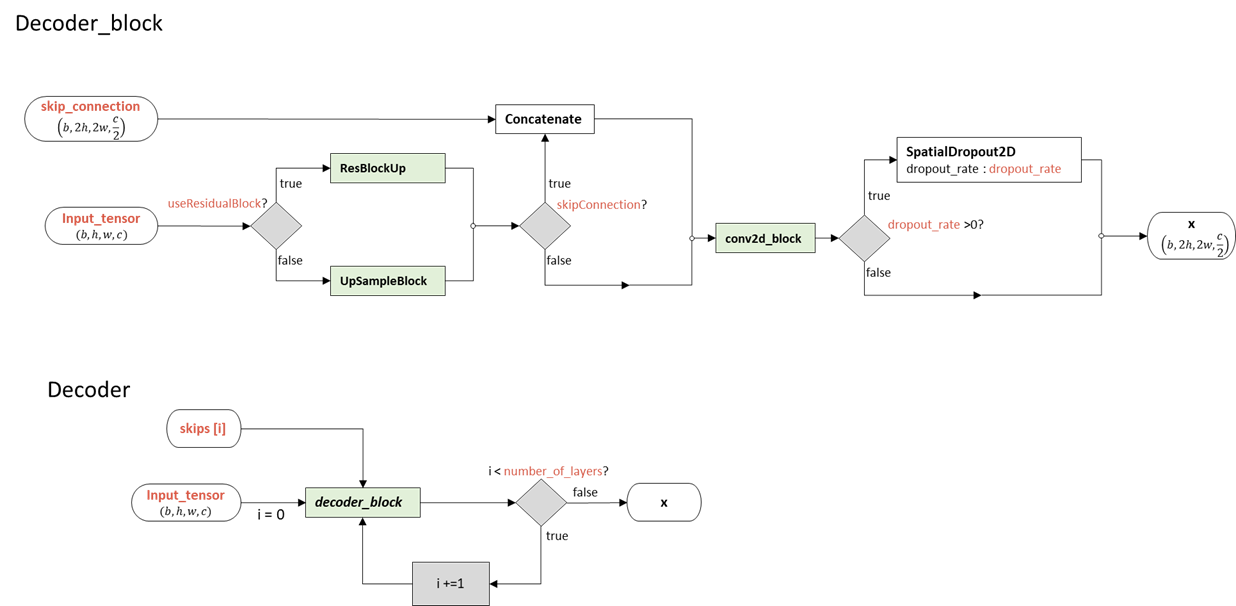

In [ ]:
def decoder_block(input_tensor, skipConnection, upsampling, n_filters, useResidualConv2DBlock, kernels, split_kernels, useResidualBlock,numberOfConvs,activation, dropout_rate=DROPOUT_RATE):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    skipConnection (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

  Returns:
    c (tensor) -- output features of the decoder block
  '''

  if useResidualBlock:
    x = ResBlockUp(input_tensor, NumberOfOutputChannel = n_filters,activation=activation)
  else:
    x = UpSampleBlock(input_tensor = input_tensor, numOfChannels = n_filters, kernels = kernels, upsampling = upsampling, split_kernels = split_kernels,activation=activation)
  
  if skipConnection != None:
    x = tf.keras.layers.concatenate([x, skipConnection])

  x = conv2d_block(x, n_filters,useResidualConv2DBlock=useResidualConv2DBlock, kernels = kernels,split_kernels=split_kernels, activation = activation,numberOfConvs=numberOfConvs)
  
  if dropout_rate > 0:
    x = tf.keras.layers.SpatialDropout2D(dropout_rate)(x)
  
  return x


def decoder(input_tensor,number_of_layers, upsampling, n_filters, limit_n_filters, useResidualConv2DBlock, kernels, split_kernels,numberOfConvs,activation, skipConnection = None, useResidualBlock = False):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks. 
  
  Args:
    input_tensor (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''

  x = input_tensor

  for i in reversed(range(number_of_layers)):
    number_of_filters = min(n_filters * 2**i, limit_n_filters)  #i=0 -> 64, i=1 -> 128, i=2 -> 256, ... Hint: Reversed! 
    if i > int(number_of_layers/2): # ">" since i is reversed
      dropout_rate = DROPOUT_RATE
    else:
      dropout_rate = 0
    if skipConnection:
      x = decoder_block(x, skipConnection[i], upsampling, n_filters = number_of_filters, useResidualConv2DBlock = useResidualConv2DBlock, kernels=kernels, split_kernels=split_kernels,useResidualBlock = useResidualBlock,numberOfConvs=numberOfConvs,activation=activation,dropout_rate=dropout_rate)
    else:
      x = decoder_block(x, None, upsampling, n_filters = number_of_filters, useResidualConv2DBlock = useResidualConv2DBlock, kernels=kernels, split_kernels=split_kernels,useResidualBlock = useResidualBlock, numberOfConvs=numberOfConvs,activation=activation,dropout_rate=dropout_rate)

  return x

<a name="4-4"></a>
## 4.4 Model Blocks

TODO: 
- [ ] Check VGG-16 and transferlearning for generator using perceptual loss: https://arxiv.org/abs/2012.04781 
- [x] UNET does not use up and downsample blocks! 
- [x] Upsample layer and transpose convs nutzen eine kernel size von 2! nicht 3!
- [x] check position and sense of dropout layer... maybe thats why the tpu struggles with Unet and uses extensive padding...
- [x] check if bias is required in convolutions! the bias might lead to extensive padding!
- [x] add final activations to models! tanh -> [-1 : 1], sigmoid -> [0 : 1]

<a name="4-4-1"></a>
### 4.4.1 U-Net

Idea: http://arxiv.org/abs/1505.04597

TODO: 
- [x] check decoder stride... 3 seems strange, would expect 2
- ideen von pix2pix: 
  - [x] max channel 512 auch nach mehreren downsample! 
  - [x] dropout nur beim decoder in den ersten drei layern!!!
  - [x] encoder hat leaky Relu und decoder Relu

Standard U-Net

My Deviations:
- Instance norm instead of batch Norm!
- padding = same, no cropping
- leaky relu in down path, relu in up-path (DIESE ÄNDERUNG FINDE ICH NICHT IM CODE! NOCHMAL CHECKEN!)
- bigger images
- upsampling instead of up-conv
- final sigmoid activation to be between 0...1 as the input images!
- HeUniform initializer! instead of randomNormal
- exchanged droput with spatialdropout
- (3x3) conv to (5x1) and (1x5) conv
- instead of pooling also space_to_depth and instead of upsampling/trans_conv depth_to_space

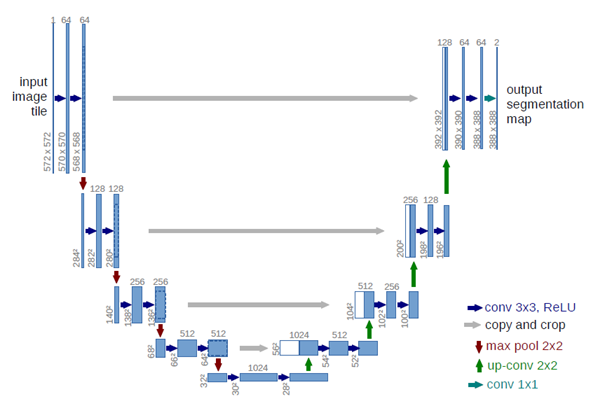

U-Net with risidual bottleneck

My Deviations:
- Instance norm instead of batch Norm!
- leaky relu in down path, relu in up-path (DIESE ÄNDERUNG FINDE ICH NICHT IM CODE! NOCHMAL CHECKEN!)
- bigger images

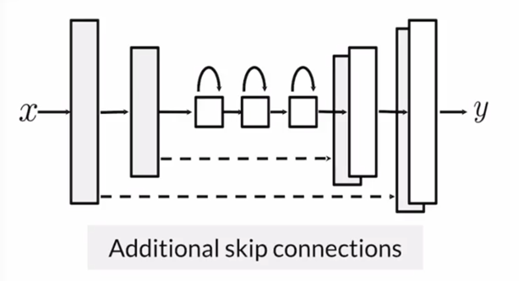

Idee: https://medium.com/@nishanksingla/unet-with-resblock-for-semantic-segmentation-dd1766b4ff66

My Deviations:
- Instance norm instead of batch Norm!
- leaky relu in down path, relu in up-path (DIESE ÄNDERUNG FINDE ICH NICHT IM CODE! NOCHMAL CHECKEN!)
- bigger images

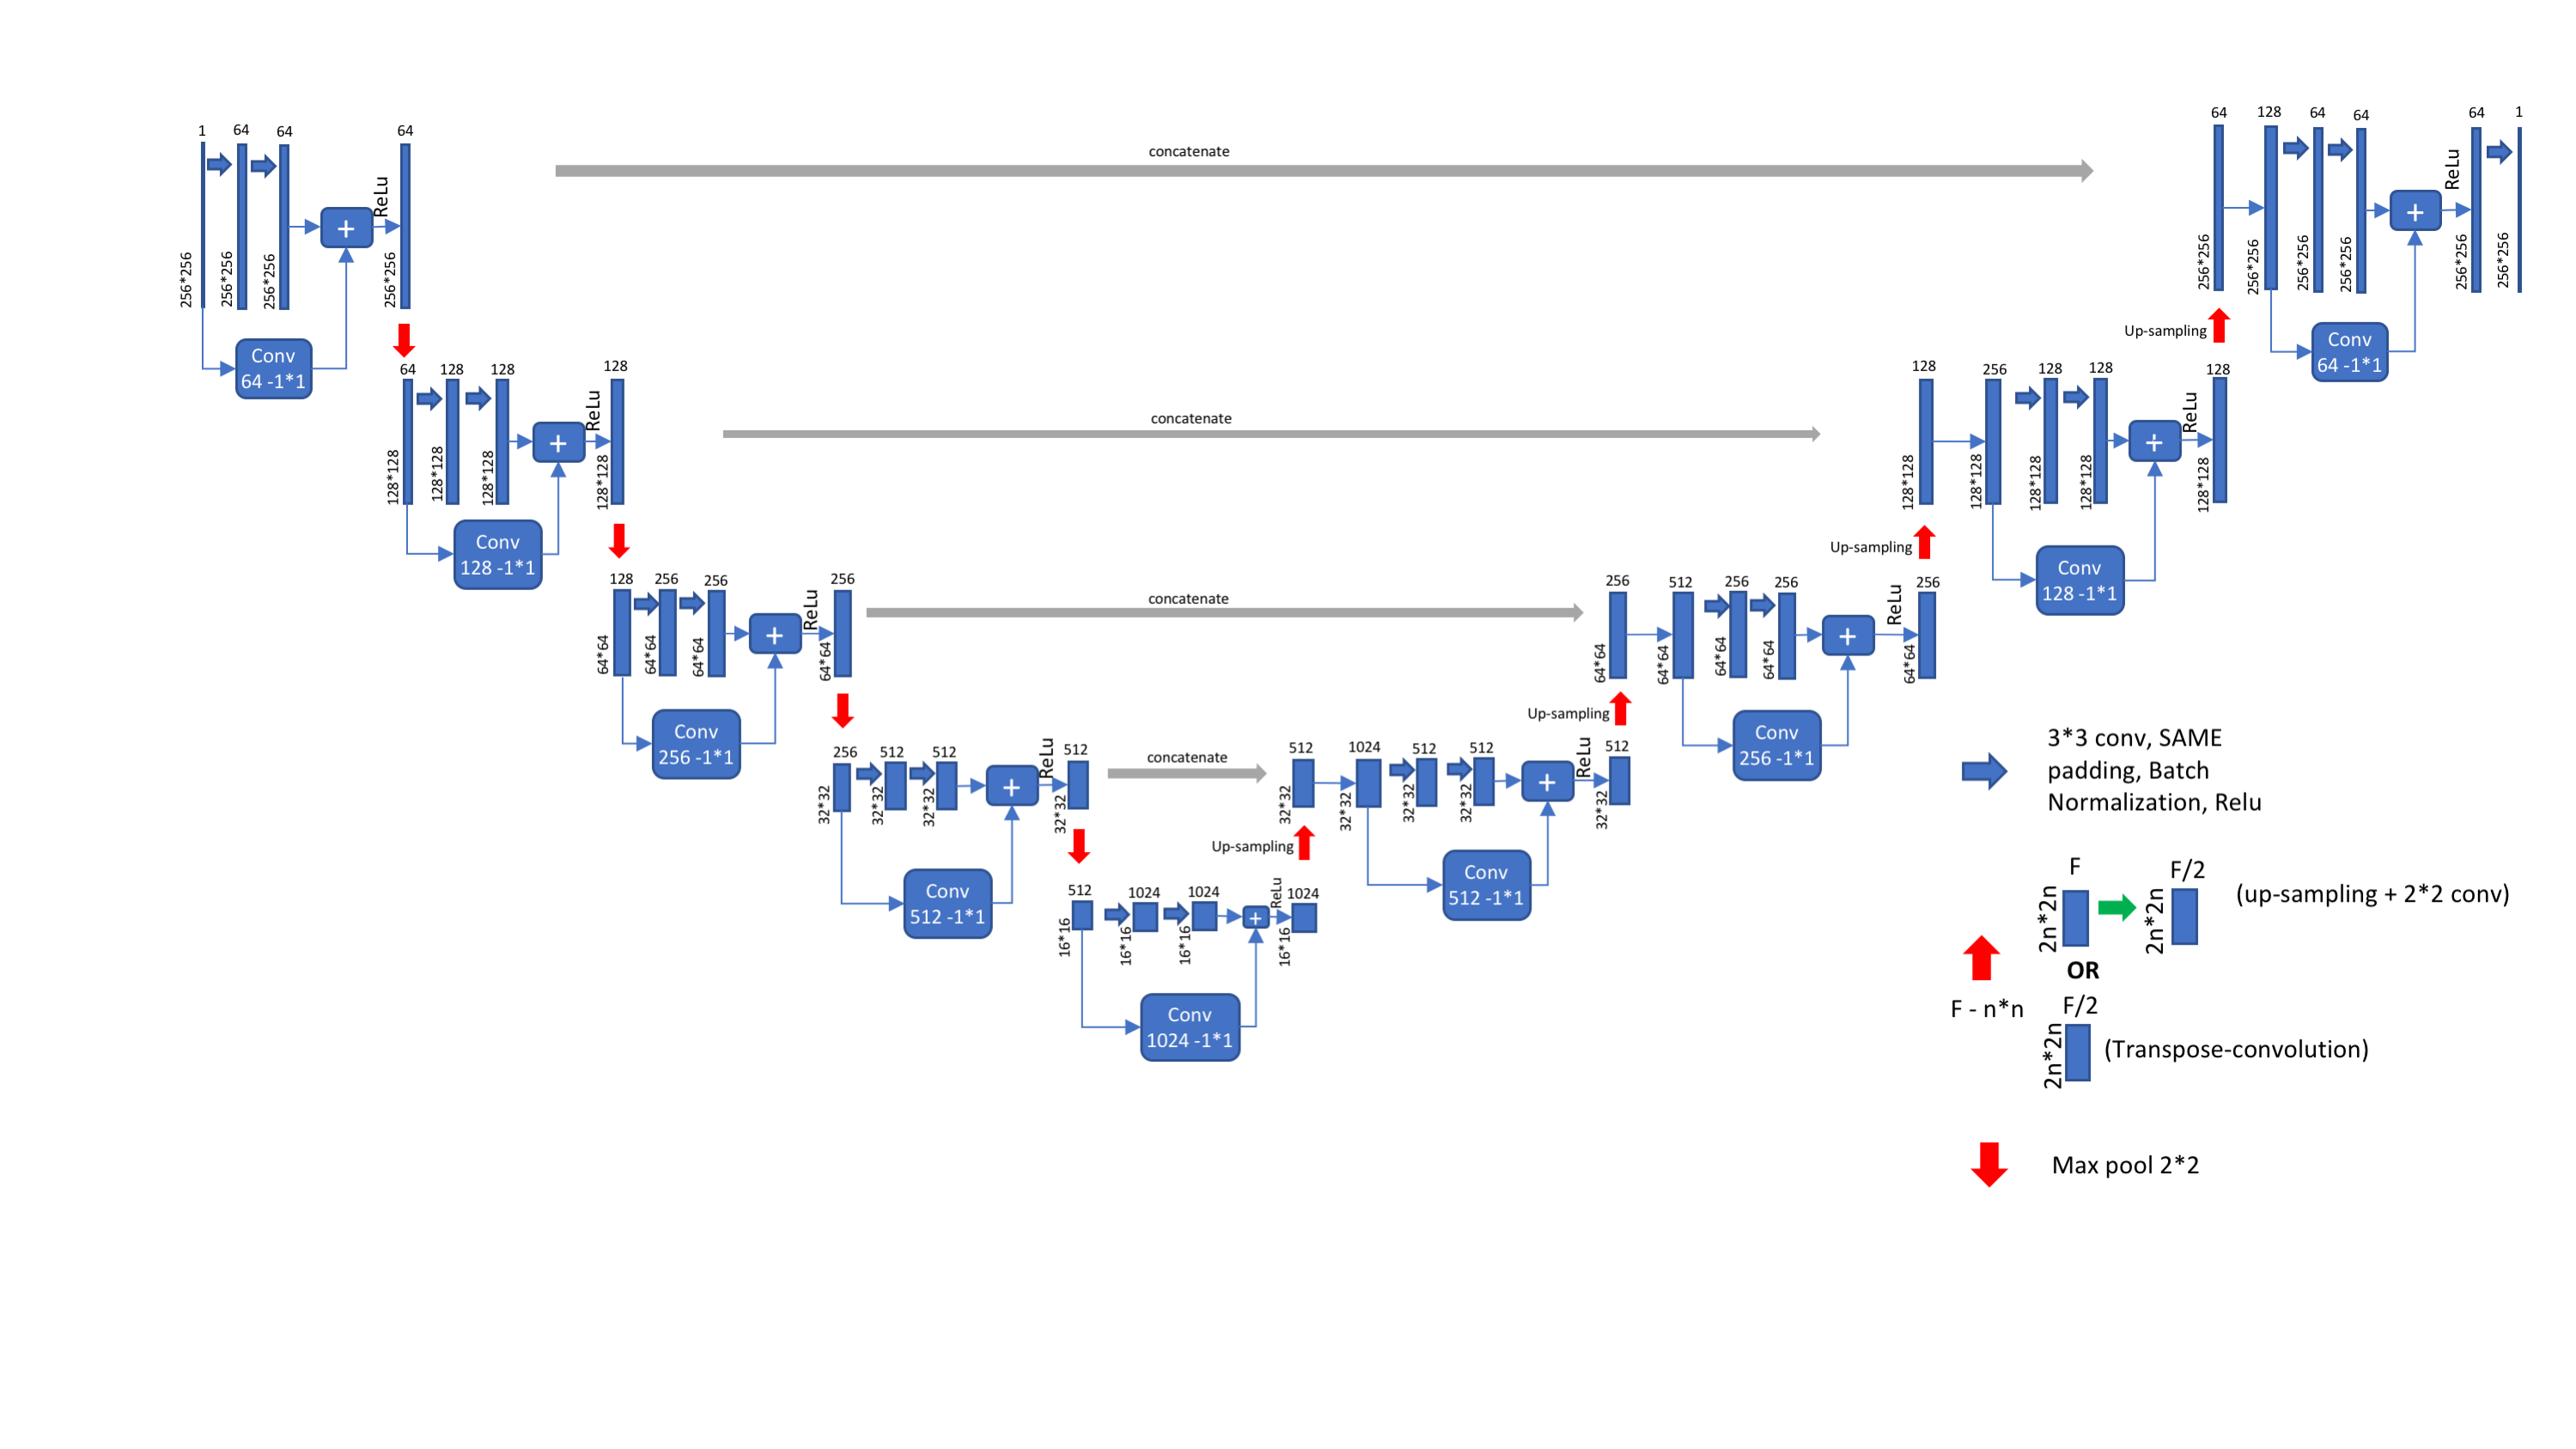


Final U-Net Model

TODO:
- [x] check that "with residualblock" works as expected by plotting the model!!!
- [ ] Do i miss a final activation? 

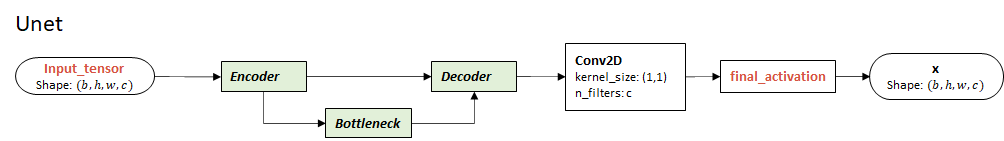

In [ ]:
def UNet(
    inputShape = IMG_SIZE, 
    number_of_layers = GENERATOR_UP_DOWN_LEVELS, 
    upsampling = GENERATOR_UPSAMPLING, 
    downsampling = GENERATOR_DOWNSAMPLING,  
    final_activation = FINAL_GENERATOR_ACTIVATION, 
    n_filters = GENERATOR_CONV_FILTERS, 
    kernels = GENERATOR_CONV_KERNELS,
    split_kernels = GENERATOR_SPLIT_KERNELS,
    numberOfConvs = GENERATOR_NUM_CONVS_PER_BLOCK,
    activation = GLOBAL_ACTIVATION,
    limit_n_filters = 512, 
    useResidualConv2DBlock = False, 
    useResidualBottleNeck = False, 
    numOfResidualLayers = 3, 
    useBottleneckIdentity = False, 
    name = None):
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  input_tensor = tf.keras.layers.Input(shape = inputShape)

  # feed the inputs to the encoder
  encoder_output, skipConnection = encoder(input_tensor, number_of_layers, n_filters, limit_n_filters, useResidualConv2DBlock, downsampling, kernels, split_kernels,numberOfConvs,activation)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output, useResidualBottleNeck, numOfResidualLayers, useResidualConv2DBlock, kernels, split_kernels,numberOfConvs, activation = activation)

  # feed the bottleneck and encoder block outputs to the decoder
  decoder_output = decoder(bottle_neck, number_of_layers, upsampling, n_filters, limit_n_filters, useResidualConv2DBlock, kernels, split_kernels,numberOfConvs,activation, skipConnection)

  # Conv layer before final layer (if tanh or sigmoid) gets the glorot Initializer!
  final_conv = tf.keras.layers.Conv2D(inputShape[-1], (1, 1), kernel_initializer = LAST_KERNEL_INIT, use_bias=USE_BIAS_NODES)(decoder_output)
  outputs = activation_func(final_activation)(final_conv)
  
  # create the model
  model = tf.keras.Model(inputs=input_tensor, outputs=outputs, name = name)

  return model

#Testcode
#model = UNet(number_of_layers = 5, upsampling = "depth_to_space", n_filters = 64, useResidualConv2DBlock = False, useResidualBottleNeck = False, numOfResidualLayers = 3, useBottleneckIdentity = False, name = None)
#model = UNet()
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, show_dtype=True, to_file='Unet_model.png')


<a name="4-4-2"></a>
### 4.4.2 ResNet

Idea taken from: https://arxiv.org/abs/1512.03385


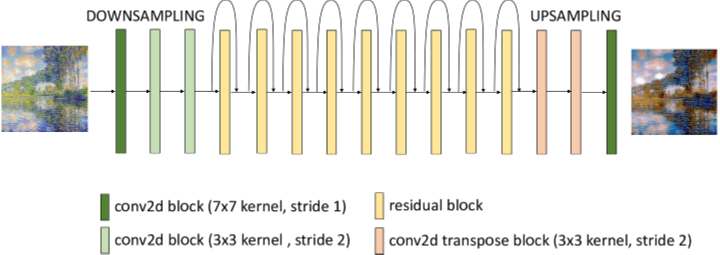

TODO: Implement ResNET Version with downsampling ResNET Blocks and Upsampling ResNET Blocks

Idea: Deep Residual Learning for Image Recognition http://arxiv.org/abs/1512.03385

Changes made to basic model:
- adapted channel width for my trainings samples (e.g. 512x512x4)
- final activation is sigmoid

TODO: 
- [x] use existing sub-model blocks

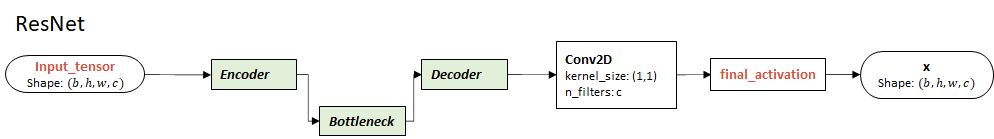

In [ ]:
def ResNet(
    inputShape = IMG_SIZE, 
    name = None, 
    n_filters=GENERATOR_CONV_FILTERS,  
    number_of_layers = GENERATOR_UP_DOWN_LEVELS, 
    split_kernels = GENERATOR_SPLIT_KERNELS,
    kernels = GENERATOR_CONV_KERNELS,
    numberOfConvs = GENERATOR_NUM_CONVS_PER_BLOCK,
    activation = GLOBAL_ACTIVATION,
    final_activation = FINAL_GENERATOR_ACTIVATION,
    useResidualConv2DBlock = True,
    useResidualUpDownBlock = False,
    limit_n_filters = 512, 
    num_res_blocks = 5, 
    upsampling = GENERATOR_UPSAMPLING, 
    downsampling = GENERATOR_DOWNSAMPLING
    ):
  inputImageChannels = inputShape[-1]

  # Define functional API
  input_tensor = tf.keras.layers.Input(shape=inputShape)
  x = input_tensor

  # feed the inputs to the encoder
  encoder_output,_ = encoder(x, number_of_layers, n_filters, limit_n_filters, useResidualConv2DBlock, downsampling, kernels, split_kernels,numberOfConvs,activation,useResidualBlock=useResidualUpDownBlock )

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output, useResidualUpDownBlock, num_res_blocks, useResidualConv2DBlock, kernels, split_kernels,numberOfConvs , activation = activation)

  # feed the bottleneck and encoder block outputs to the decoder
  decoder_output = decoder(bottle_neck, number_of_layers, upsampling, n_filters, limit_n_filters, useResidualConv2DBlock, kernels, split_kernels,numberOfConvs,activation, useResidualBlock=useResidualUpDownBlock )

  # Conv layer before final layer (if tanh or sigmoid) gets the glorot Initializer!
  x = tf.keras.layers.Conv2D(inputImageChannels, (1, 1), kernel_initializer = LAST_KERNEL_INIT, use_bias = USE_BIAS_NODES)(decoder_output)
  x = activation_func(final_activation)(x)

  return tf.keras.Model(inputs=input_tensor, outputs=x, name = name)

# Test Code
#model = ResNet(n_filters=64,number_of_layers=3,split_kernels=False,numberOfConvs=2,kernels=5)
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-4-3"></a>
### 4.4.3 PatchGAN Discriminator

The PatchGAN has been used in the Pix2Pix model: https://www.tensorflow.org/tutorials/generative/pix2pix

Instead of having only a single output classification of the discriminator, the PatchGAN, provides a prediction for several patches of the image

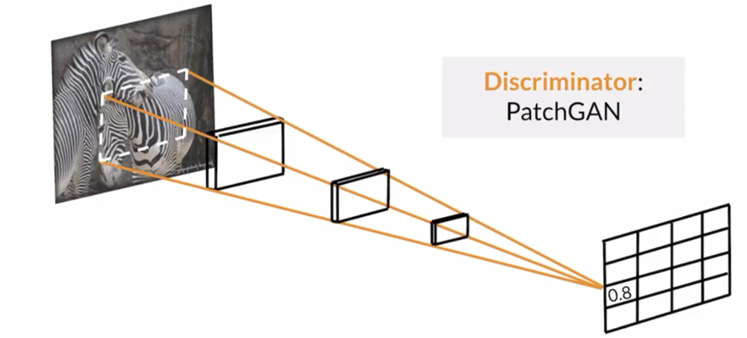

Changes made to basic model:
- adapted channel width for my trainings samples (e.g. 512x512x4)
- swapped batchnorm with instance norm! 
- added final sigmoid activation
- adapted kernel_initializer

TODO:
- [x] check whetather or not the patchgan requires a final activation (e.g. tanh) to limit the output between -1 and 1? 
- [x] check if the convolution should have a kernel of 4... better 3 or 5!

Changes 05.03.2021:
- fixed channel size!
- changed from batchnorm to channel norm! 
- ~~removed zero padding and used padding = "same" instead~~ 
  - has been very bad for the performance!
- ~~64 output patches instead of 30 -> larger imaage more patches and seems better since power of two for TPU padding~~
  - has been very bad for the performance! I now keep 60 patches and I only removed the last zero Pad!

Changes 07.03.21:
- removed final activation

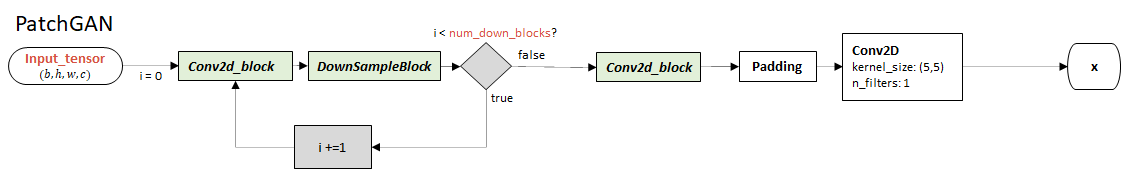

In [ ]:
#%%monitor_cell “MasterThesis/PatchGAN”
def PatchGAN(
    inputShape = IMG_SIZE, 
    name = None, 
    n_filters = DISCRIMINATOR_CONV_FILTERS,
    downsampling = DISCRIMINATOR_DOWNSAMPLING, 
    kernels = DISCRIMINATOR_CONV_KERNELS,
    split_kernels = DISCRIMINATOR_SPLIT_KERNELS,
    numberOfConvs = DISCRIMINATOR_NUM_CONVS_PER_BLOCK,
    activation = GLOBAL_ACTIVATION,
    num_down_blocks = 3,
    dropout_rate = DROPOUT_RATE
    ):

  # Define functional API
  input_tensor = tf.keras.layers.Input(shape=inputShape)
  x = input_tensor

  #Downsampling Blocks
  for i in range(num_down_blocks):
    #print(n_filters * (2**i))
    x = conv2d_block(input_tensor = x, n_filters=n_filters * (2**i), useResidualConv2DBlock =  False, kernels = kernels,split_kernels = split_kernels, activation = activation, numberOfConvs=numberOfConvs, dropout_rate=dropout_rate)
    x = DownSampleBlock(input_tensor = x, numOfChannels = n_filters * (2**i), downsampling = downsampling ,kernels = kernels,activation=activation)

  #increase channels while keeping spatial dimensions
  x = conv2d_block(x, n_filters = n_filters * (2**(num_down_blocks)), useResidualConv2DBlock = False, kernels = kernels, split_kernels = split_kernels, numberOfConvs = numberOfConvs, activation = activation,dropout_rate=dropout_rate)

  # Conv layer before final layer (if tanh or sigmoid) gets the glorot Initializer!
  x = pad_func(padding = (2,2))(x) #padding=2 since 5x5 kernel bellow
  x = tf.keras.layers.Conv2D(1, 5, kernel_initializer = KERNEL_INIT, use_bias = USE_BIAS_NODES)(x)

  return tf.keras.Model(inputs=input_tensor, outputs=x, name = name)

# Test Code
#model = PatchGAN(name = "PatchGAN")
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-4-4"></a>
### 4.4.4 U-Net Discriminator
> Idea taken from: https://openaccess.thecvf.com/content_CVPR_2020/papers/Schonfeld_A_U-Net_Based_Discriminator_for_Generative_Adversarial_Networks_CVPR_2020_paper.pdf

> Git: https://github.com/boschresearch/unetgan 

> Clarifications of the paper: https://github.com/boschresearch/unetgan/blob/master/how_to_unetgan.pdf

The basic idea is to use a U-Net to generate a pixel-wise prediction (decoder output) and a global prediction (encoder output) in the discriminator to strengthen the discriminator. In that way, the generator can benefit from a better feedback of the discriminator

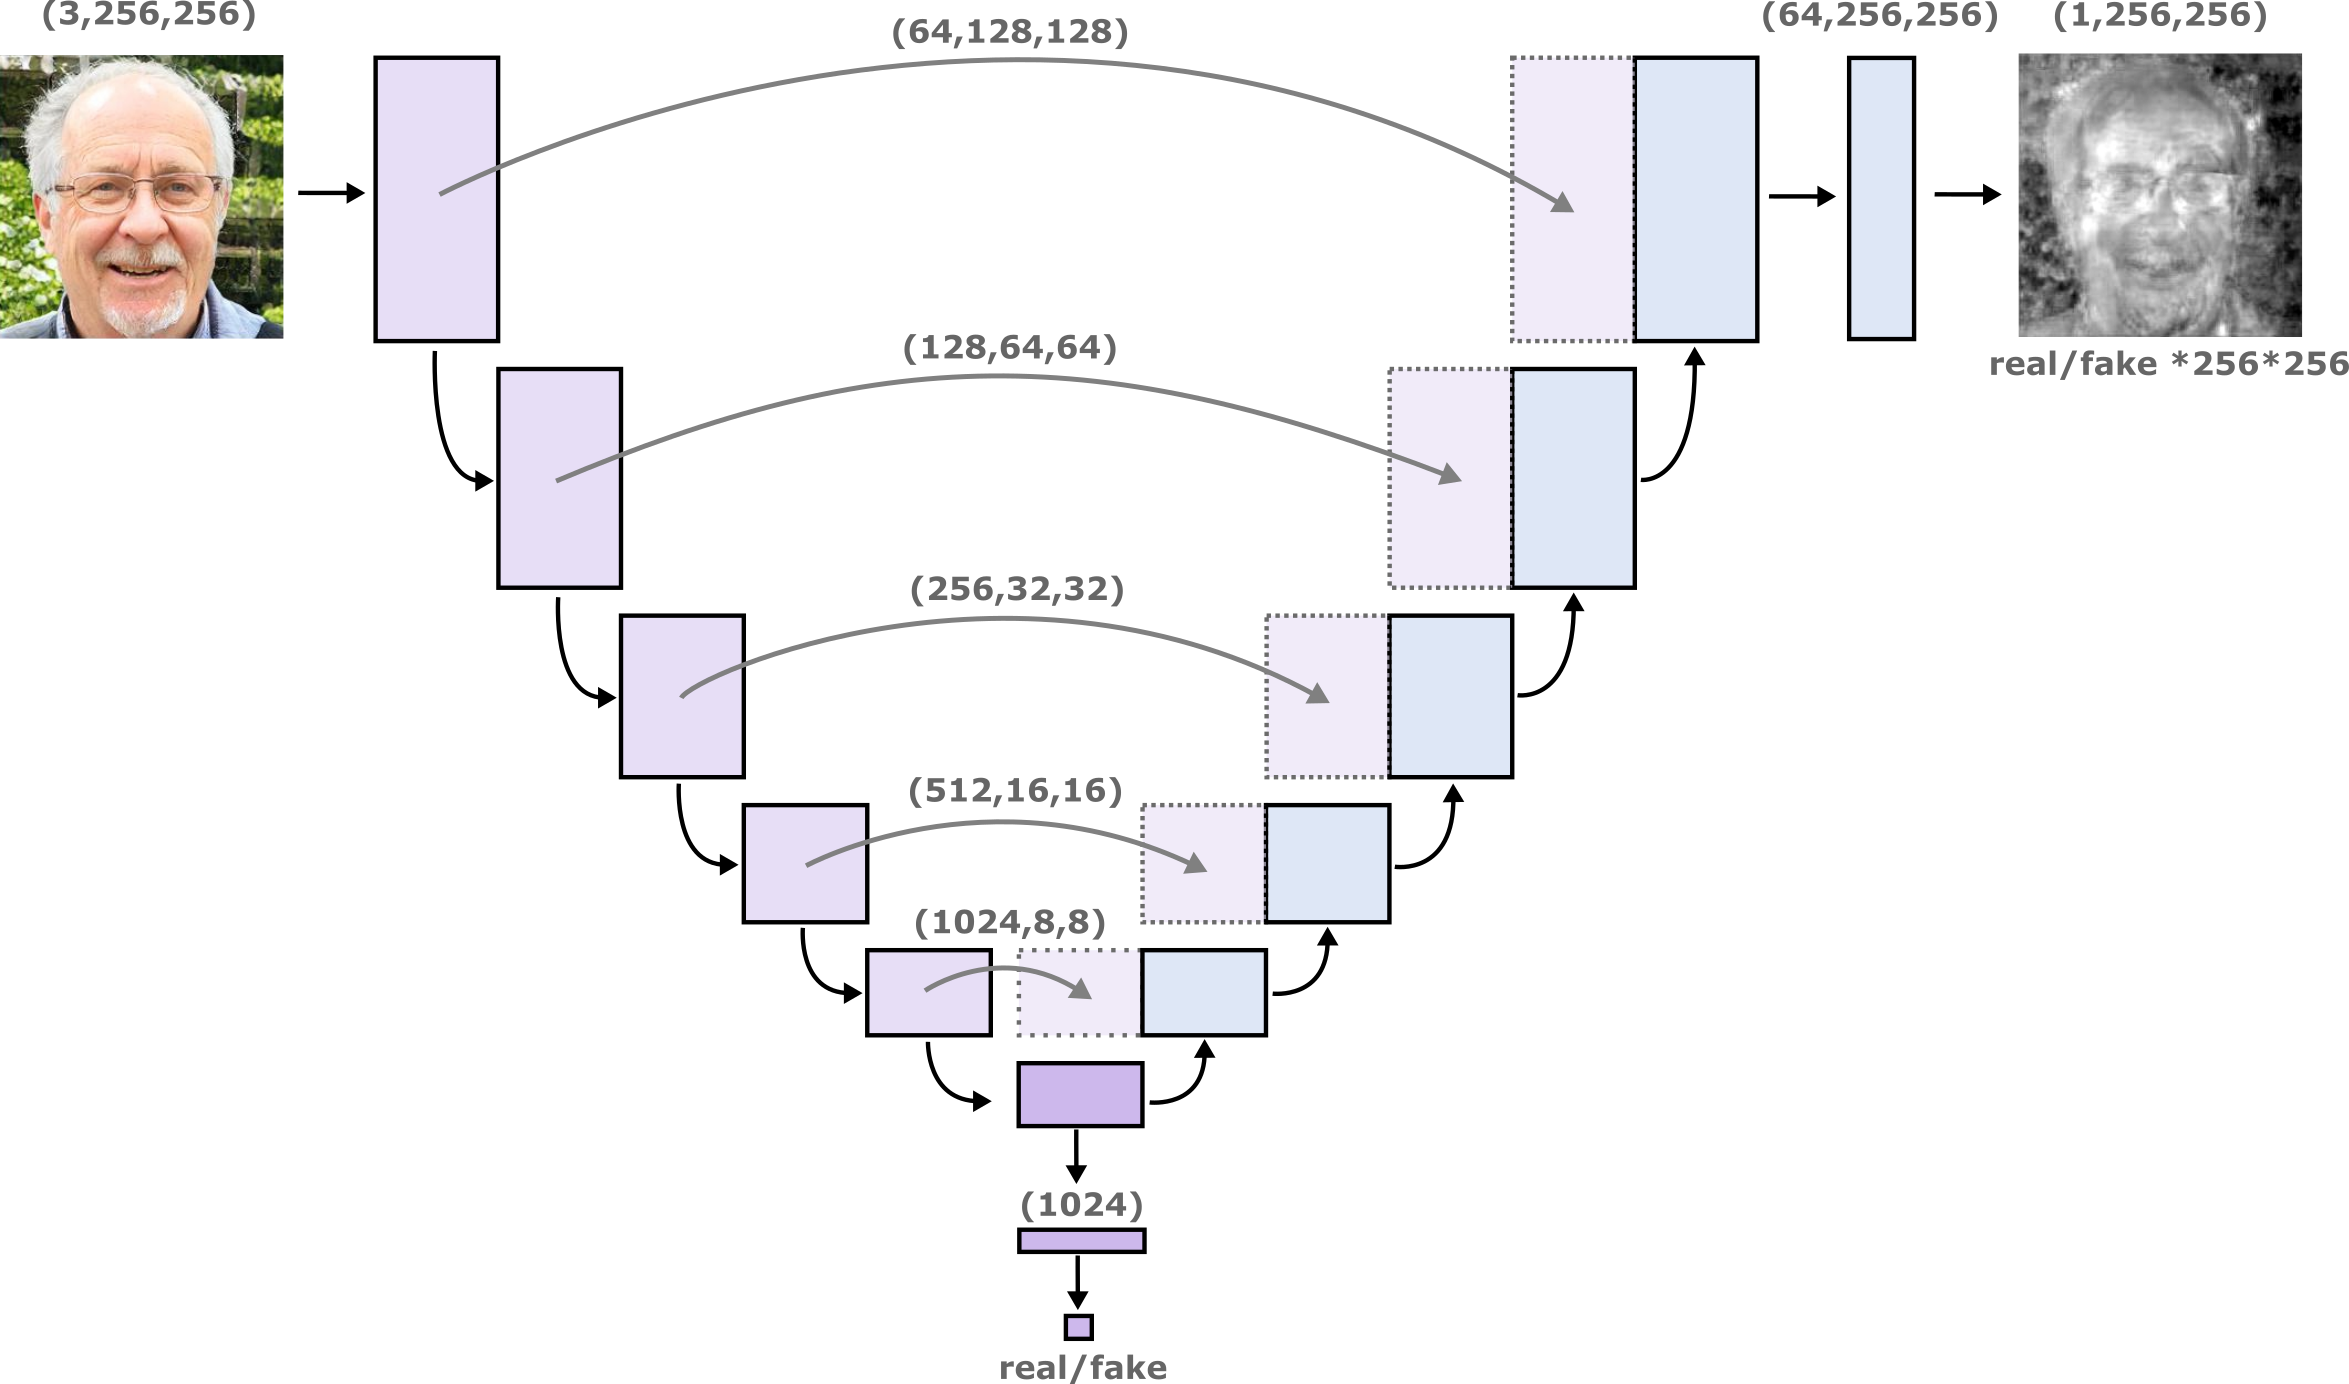

Changes made to basic model:
- adapted channel width for my trainings samples (e.g. 512x512x4)
- swapped batch norm with instance norm! 
- last downsample layer is 8*CH instead of 16*CH to reduce parameter!

Changes 07.03.21:
- removed final activation

Todo: 
- [ ] use encoder with residual implementation!!!!

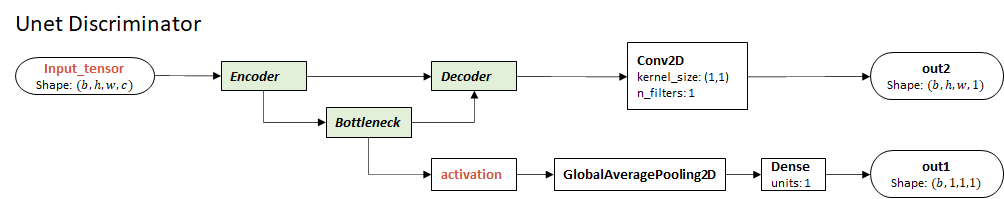

In [ ]:
DISC_VERSION = 'adapted' #@param ["from_paper", "adapted"]

if DISC_VERSION == "from_paper":
  def UNetDiscriminator(
      inputShape = IMG_SIZE, 
      number_of_layers = DISCRIMINATOR_UP_DOWN_LEVELS,
      upsampling = DISCRIMINATOR_UPSAMPLING, 
      downsampling = DISCRIMINATOR_DOWNSAMPLING,
      kernels = DISCRIMINATOR_CONV_KERNELS,
      split_kernels = DISCRIMINATOR_SPLIT_KERNELS,
      numberOfConvs = DISCRIMINATOR_NUM_CONVS_PER_BLOCK,
      activation = GLOBAL_ACTIVATION, 
      useResidualConv2DBlock = False,
      useResidualUpDownBlock = True,
      limit_n_filters = 512,
      useResidualBottleNeck = False, 
      numOfResidualLayers = 0,
      useBottleneckIdentity = False,   
      n_filters = DISCRIMINATOR_CONV_FILTERS, 
      useNonLocalBlock = False, 
      name = None):
    
    # Define functional API
    input_tensor = tf.keras.layers.Input(shape=inputShape)

    # feed the inputs to the encoder
    encoder_output, skipConnections = encoder(input_tensor, number_of_layers, n_filters, limit_n_filters, useResidualConv2DBlock, downsampling, kernels, split_kernels,numberOfConvs,activation, useResidualBlock=useResidualUpDownBlock)
    
    # feed the encoder output to the bottleneck
    bottle_neck = bottleneck(encoder_output, useResidualBottleNeck, numOfResidualLayers, useResidualConv2DBlock, kernels, split_kernels, numberOfConvs, activation = activation)

    # Real/Fake Output
    out1 = bottle_neck
    out1 = activation_func(activation)(out1)
    out1 = tf.keras.layers.GlobalAveragePooling2D()(out1) #ACHTUNG: PAPER SAGT EIG GLOBAL SUM POOLING!!! KÖNNTE GELÖSST WERDEN IN DEM MAN MAL 256 rechnet, da dieser layer 16x16 = 256 values hat, über die geaveraged wird! 
    out1 = tf.keras.layers.Dense(1, kernel_initializer = KERNEL_INIT)(out1)

    # feed the bottleneck and encoder block outputs to the decoder
    decoder_output = decoder(bottle_neck, number_of_layers, upsampling, n_filters, limit_n_filters, useResidualConv2DBlock, kernels, split_kernels,numberOfConvs,activation, useResidualBlock=useResidualUpDownBlock, skipConnection= skipConnections)

    out2 = tf.keras.layers.Conv2D(filters = 1, kernel_size = (1,1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(decoder_output)

    return tf.keras.Model(inputs=input_tensor, outputs=[out1, out2], name = name)
else:
  def UNetDiscriminator(
      inputShape = IMG_SIZE, 
      number_of_layers = DISCRIMINATOR_UP_DOWN_LEVELS, 
      upsampling = DISCRIMINATOR_UPSAMPLING, 
      downsampling = DISCRIMINATOR_DOWNSAMPLING, 
      n_filters = DISCRIMINATOR_CONV_FILTERS,
      kernels = DISCRIMINATOR_CONV_KERNELS,
      split_kernels = DISCRIMINATOR_SPLIT_KERNELS,
      numberOfConvs = DISCRIMINATOR_NUM_CONVS_PER_BLOCK,
      activation = GLOBAL_ACTIVATION, 
      limit_n_filters = 512, 
      useResidualConv2DBlock = False, 
      useResidualUpDownBlock = False,
      useResidualBottleNeck = False, 
      useNonLocalBlock = False,
      numOfResidualLayers = 0, 
      useBottleneckIdentity = False, 
      name = None):
    '''
    Defines the UNet by connecting the encoder, bottleneck and decoder.
    '''

    # specify the input shape
    input_tensor = tf.keras.layers.Input(shape = inputShape)

    # feed the inputs to the encoder
    encoder_output, skipConnections = encoder(input_tensor, number_of_layers, n_filters, limit_n_filters, useResidualConv2DBlock, downsampling, kernels,split_kernels,numberOfConvs, activation, useResidualBlock=useResidualUpDownBlock)

    # feed the encoder output to the bottleneck
    bottle_neck = bottleneck(encoder_output, useResidualBottleNeck, numOfResidualLayers, useResidualConv2DBlock, kernels, split_kernels,numberOfConvs, activation = activation)

    out1 = bottle_neck
    out1 = activation_func(activation)(out1)
    out1 = tf.keras.layers.GlobalAveragePooling2D()(out1)
    out1 = tf.keras.layers.Dense(1, kernel_initializer = KERNEL_INIT)(out1)
    
    # feed the bottleneck and encoder block outputs to the decoder
    # specify the number of classes via the `output_channels` argument
    decoder_output = decoder(bottle_neck, number_of_layers, upsampling, n_filters, limit_n_filters, useResidualConv2DBlock, kernels, split_kernels, numberOfConvs,activation, useResidualBlock=useResidualUpDownBlock, skipConnection= skipConnections)

    # Conv layer before final layer (if tanh or sigmoid) gets the glorot Initializer!
    final_conv = tf.keras.layers.Conv2D(1, (1, 1), kernel_initializer = KERNEL_INIT, use_bias=USE_BIAS_NODES)(decoder_output)
    out2 = final_conv #activation_func(final_activation)(final_conv)
    
    # create the model
    model = tf.keras.Model(inputs=input_tensor, outputs=[out1, out2], name = name)

    return model

# Test Code
#model = UNetDiscriminator(name = "UNetDiscriminator")
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-4-x"></a>
### 4.4.x One-Shot Discriminator

inspired by: http://arxiv.org/abs/2103.13389 

TODO: 
- [ ] not only downsample block but also with conv!


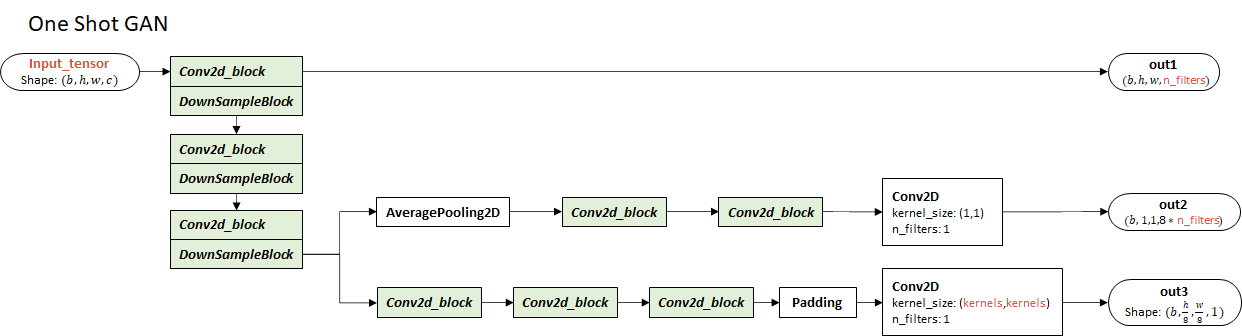

In [ ]:
def OneShotDiscriminator(
    inputShape = IMG_SIZE, 
    n_filters = DISCRIMINATOR_CONV_KERNELS,
    downsampling = DISCRIMINATOR_DOWNSAMPLING, 
    kernels = DISCRIMINATOR_CONV_KERNELS,
    split_kernels = DISCRIMINATOR_SPLIT_KERNELS,
    numberOfConvs = DISCRIMINATOR_NUM_CONVS_PER_BLOCK,
    activation = GLOBAL_ACTIVATION,
    dropout_rate = DROPOUT_RATE,
    name = None
    ):
  input_tensor = tf.keras.layers.Input(shape=inputShape)

  # Low Level Features
  pad = int((kernels-1)/2) # assumes odd kernel size, which is typical!

  feat0 = conv2d_block(input_tensor, n_filters=n_filters, useResidualConv2DBlock =  False, kernels = kernels,split_kernels = split_kernels,numberOfConvs=numberOfConvs, activation = activation,dropout_rate=dropout_rate)
  feat = DownSampleBlock(input_tensor = feat0, numOfChannels =  n_filters*2, downsampling = downsampling,kernels = kernels, activation = activation)
  
  feat = conv2d_block(feat, n_filters=n_filters*4, useResidualConv2DBlock =  False, kernels = kernels,split_kernels = split_kernels,numberOfConvs=numberOfConvs, activation = activation,dropout_rate=dropout_rate)
  feat = DownSampleBlock(input_tensor = feat, numOfChannels =  n_filters*4, downsampling = downsampling,kernels = kernels, activation = activation)
  
  feat = conv2d_block(feat, n_filters=n_filters*8, useResidualConv2DBlock =  False, kernels = kernels,split_kernels = split_kernels,numberOfConvs=numberOfConvs, activation = activation,dropout_rate=dropout_rate)
  F = DownSampleBlock(input_tensor = feat, numOfChannels =  n_filters*8, downsampling = downsampling, kernels = kernels, activation = activation)

  out1 = feat0

  # Content Features
  con = tf.keras.layers.AveragePooling2D(pool_size=(64, 64))(F)
  con = conv2d_block(con, n_filters=n_filters * 8, kernels = 1, activation = activation, split_kernels = split_kernels,numberOfConvs=numberOfConvs, useResidualConv2DBlock=False,dropout_rate=dropout_rate)
  con = conv2d_block(con, n_filters=n_filters * 8, kernels = 1, activation = activation, split_kernels = split_kernels,numberOfConvs=numberOfConvs, useResidualConv2DBlock=False,dropout_rate=dropout_rate)
  out2 = tf.keras.layers.Conv2D(filters=n_filters * 8, kernel_size=1, use_bias = USE_BIAS_NODES, kernel_initializer = KERNEL_INIT)(con)

  # Layout Features
  # Spatialdropout kein sinn, weill nur ein channel!!
  lay = conv2d_block(F, n_filters=1, kernels = kernels, activation = activation, split_kernels = split_kernels,numberOfConvs=numberOfConvs, useResidualConv2DBlock=False,dropout_rate=dropout_rate)
  lay = conv2d_block(lay, n_filters=1, kernels = kernels, activation = activation, split_kernels = split_kernels,numberOfConvs=numberOfConvs, useResidualConv2DBlock=False,dropout_rate=dropout_rate)
  lay = conv2d_block(lay, n_filters=1, kernels = kernels, activation = activation, split_kernels = split_kernels,numberOfConvs=numberOfConvs, useResidualConv2DBlock=False,dropout_rate=dropout_rate)
  lay = pad_func(padding = (pad,pad))(lay) 
  out3 = tf.keras.layers.Conv2D(filters=1, kernel_size=kernels, use_bias = USE_BIAS_NODES, kernel_initializer = KERNEL_INIT)(lay)

  return tf.keras.Model(inputs=input_tensor, outputs=[out1, out2, out3], name = name)

# Testcode
model = OneShotDiscriminator(n_filters = 64, name = "OneShotDiscriminator")
model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

In [ ]:
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:
  models = [
            #OneShotDiscriminator( name = "OneShotDiscriminator"),
            #UNetDiscriminator(name = "UNetDiscriminator"),
            #UNetDiscriminator(name = "UNetDiscriminator"),
            UNet(name = "Unet")
  ]
  #data = []

  fig = plt.figure(figsize=[30,20])
  fig.suptitle("Weights before Training", fontsize=60)

  for m, model in enumerate(models):
    ax = fig.add_subplot(2, 2, m+1)
    ax.set_title(model.name, fontsize=30)
    for i, layer in enumerate(model.layers):
      if "conv" in layer.name:
        #data.append(np.ravel(layer.get_weights()))
        ax.hist(np.ravel(layer.get_weights()),100,label="{}".format(layer.name), alpha=0.5,log=True)
    ax.legend(loc="upper left",ncol=2)

<a name="4-4-5"></a>
### 4.4.5 CycleGAN

> Idea taken from: CycleGAN implementation of TensorFlow: https://www.tensorflow.org/tutorials/generative/cyclegan

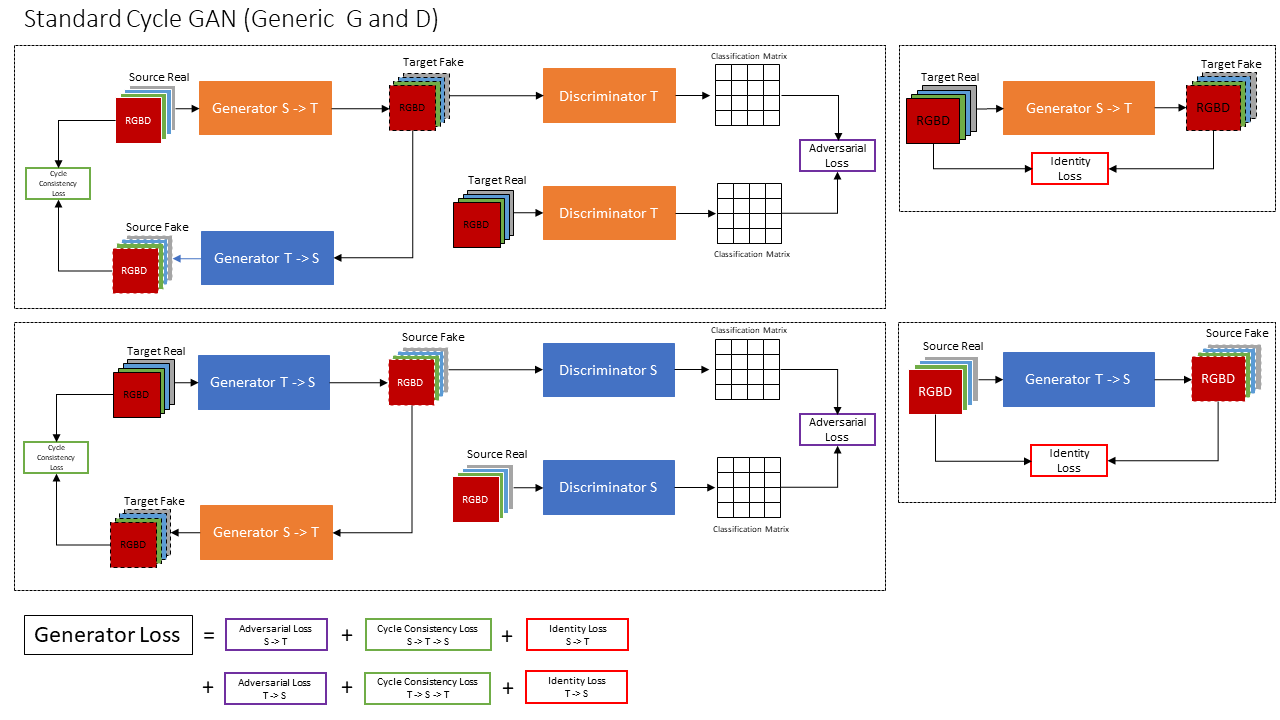

In [ ]:
class CycleGAN(tf.keras.Model):
  def __init__(self, generator_T, generator_S, discriminator_T, discriminator_S, lambda_cycle, lambda_identity, lambda_dssim, useCutmix = DISCRIMINATOR_CUTMIX, cutmixProbability = CUTMIX_PROBABILITY):
    super(CycleGAN, self).__init__()
    
    self.modelType = "CycleGAN"
    self.generator_S_to_T = generator_T
    self.generator_T_to_S = generator_S
    self.discriminator_S = discriminator_S
    self.discriminator_T = discriminator_T
    self.lambda_cycle = lambda_cycle
    self.lambda_identity = lambda_identity
    self.lambda_dssim = lambda_dssim
    self.useCutmix = useCutmix
    self.cutmixProbability = cutmixProbability


  # To reduce python overhead, and maximize the performance of your TPU, try out the experimental experimental_steps_per_execution argument to Model.compile. Here it increases throughput by about 50%:
  # https://www.tensorflow.org/guide/tpu#train_a_model_using_keras_high_level_apis 

  def compile(self, generator_S_to_T_optimizer, generator_T_to_S_optimizer, discriminator_S_optimizer, discriminator_T_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn, dssim_loss_fn):
    #super(CycleGAN, self).compile()
    super(CycleGAN, self).compile(steps_per_execution = 64)
    self.generator_S_to_T_optimizer = generator_S_to_T_optimizer
    self.generator_T_to_S_optimizer = generator_T_to_S_optimizer
    self.discriminator_S_optimizer = discriminator_S_optimizer
    self.discriminator_T_optimizer = discriminator_T_optimizer
    self.generator_loss_fn = gen_loss_fn
    self.discriminator_loss_fn = disc_loss_fn
    self.cycle_loss_fn = cycle_loss_fn
    self.identity_loss_fn = identity_loss_fn
    self.dssim_loss_fn = dssim_loss_fn
  def compileOptimizer(self, generator_S_to_T_optimizer, generator_T_to_S_optimizer, discriminator_S_optimizer, discriminator_T_optimizer):
    #super(CycleGAN, self).compile()
    super(CycleGAN, self).compile(steps_per_execution = 64)
    self.generator_S_to_T_optimizer = generator_S_to_T_optimizer
    self.generator_T_to_S_optimizer = generator_T_to_S_optimizer
    self.discriminator_S_optimizer = discriminator_S_optimizer
    self.discriminator_T_optimizer = discriminator_T_optimizer

  def call(self, batch):
    input_S, input_T = batch
    generated_T = self.generator_S_to_T(input_S)
    generated_S = self.generator_T_to_S(input_T)
    discriminated_T = self.discriminator_T(input_T)
    discriminated_S = self.discriminator_S(input_S)
    return tf.stack([generated_T, generated_S, discriminated_T, discriminated_S])

  #def build_model_from_layers(self, shape):
  #  x = tf.keras.layers.Input(shape=(shape))
  #  y = tf.keras.layers.Input(shape=(shape))
  #  return tf.keras.Model(inputs=[x, y], outputs=self.call(x, y))

  #def print_models_to_files(self):
  #  tf.keras.utils.plot_model(self.generator_S_to_T, show_shapes=True, expand_nested=False, show_dtype=True, to_file='generator_S_to_T.png')
  #  tf.keras.utils.plot_model(self.generator_T_to_S, show_shapes=True, expand_nested=False, show_dtype=True, to_file='generator_T_to_S.png')
  #  tf.keras.utils.plot_model(self.discriminator_S, show_shapes=True, expand_nested=False, show_dtype=True, to_file='discriminator_S.png')
  #  tf.keras.utils.plot_model(self.discriminator_T, show_shapes=True, expand_nested=False, show_dtype=True, to_file='discriminator_T.png')

  def print_summary(self):

    def getNumberOfElements(listOfLayers):
      numElements = 0
      for layer in listOfLayers:
        numElements += tf.reduce_prod(layer.shape)
      return numElements

    summaryString = ""
    summaryString += "--------------------------------------------------\n"
    summaryString += "---------------- Summary Cycle GAN ---------------\n"
    summaryString += "--------------------------------------------------\n"
    
    summaryString += "\n"
    summaryString += self.generator_S_to_T.name + ":\n"
    gen1_total = getNumberOfElements(self.generator_S_to_T.variables)
    gen1_trainable = getNumberOfElements(self.generator_S_to_T.trainable_variables)
    gen1_nonTrainable = gen1_total - gen1_trainable
    summaryString += "  Total Variables: {:,}\n".format(gen1_total)
    summaryString += "  Trainable Variables: {:,}\n".format(gen1_trainable)
    summaryString += "  Non-trainable Variables: {:,}\n".format(gen1_nonTrainable)

    summaryString += "\n"
    summaryString += self.generator_T_to_S.name + ":\n"
    gen2_total = getNumberOfElements(self.generator_T_to_S.variables)
    gen2_trainable = getNumberOfElements(self.generator_T_to_S.trainable_variables)
    gen2_nonTrainable = gen2_total - gen2_trainable
    summaryString += "  Total Variables: {:,}\n".format(gen2_total)
    summaryString += "  Trainable Variables: {:,}\n".format(gen2_trainable)
    summaryString += "  Non-trainable Variables: {:,}\n".format(gen2_nonTrainable)

    summaryString += "\n"
    summaryString += self.discriminator_T.name + ":\n"
    disc1_total = getNumberOfElements(self.discriminator_T.variables)
    disc1_trainable = getNumberOfElements(self.discriminator_T.trainable_variables)
    disc1_nonTrainable = disc1_total - disc1_trainable
    summaryString += "  Total Variables: {:,}\n".format(disc1_total)
    summaryString += "  Trainable Variables: {:,}\n".format(disc1_trainable)
    summaryString += "  Non-trainable Variables: {:,}\n".format(disc1_nonTrainable)

    summaryString += "\n"
    summaryString += self.discriminator_S.name + ":\n"
    disc2_total = getNumberOfElements(self.discriminator_S.variables)
    disc2_trainable = getNumberOfElements(self.discriminator_S.trainable_variables)
    disc2_nonTrainable = disc2_total - disc2_trainable
    summaryString += "  Total Variables: {:,}\n".format(disc2_total)
    summaryString += "  Trainable Variables: {:,}\n".format(disc2_trainable)
    summaryString += "  Non-trainable Variables: {:,}\n".format(disc2_nonTrainable)

    summaryString += "_________________________________________________\n"

    cycleGAN_total = gen1_total + gen2_total + disc1_total + disc2_total
    cycleGAN_trainable = gen1_trainable + gen2_trainable + disc1_trainable + disc2_trainable
    cycleGAN_nonTrainable = gen1_nonTrainable + gen2_nonTrainable + disc1_nonTrainable + disc2_nonTrainable
    summaryString += "Total Variables: {:,}\n".format(cycleGAN_total)
    summaryString += "Trainable Variables: {:,}\n".format(cycleGAN_trainable)
    summaryString += "Non-trainable Variables: {:,}\n".format(cycleGAN_nonTrainable)

    summaryString += "_________________________________________________\n"

    print(summaryString)

    return summaryString

  def train_step(self, batch_train):
    real_S, real_T = batch_train

    # For CycleGAN, we need to calculate different
    # kinds of losses for the generators and discriminators.
    # We will perform the following steps here:
    #
    # 1. Pass real images through the generators and get the generated images
    # 2. Pass the generated images back to the generators to check if we
    #    we can predict the original image from the generated image.
    # 3. Do an identity mapping of the real images using the generators.
    # 4. Pass the generated images in 1) to the corresponding discriminators.
    # 5. Calculate the generators total loss (adverserial + cycle + identity)
    # 6. Calculate the discriminators loss
    # 7. Update the weights of the generators
    # 8. Update the weights of the discriminators
    # 9. Return the losses in a dictionary

    with tf.GradientTape(persistent=True) as tape:
      # Synthetic to target domain
      generated_T = self.generator_S_to_T(real_S, training=True)
      # target to synthetic domain
      generated_S = self.generator_T_to_S(real_T, training=True)

      # Cycle synthetic -> target -> synthetic
      cycled_S = self.generator_T_to_S(generated_T, training=True)
      # Cycle target -> synthetic -> target
      cycled_T = self.generator_S_to_T(generated_S, training=True)

      # Identity mapping
      same_S = self.generator_T_to_S(real_S, training=True)
      same_T = self.generator_S_to_T(real_T, training=True)

      if DISCRIMINATOR_DESIGN == 'PatchGAN':
        # Discriminator output
        disc_real_S = self.discriminator_S(real_S, training=True)
        disc_generated_S = self.discriminator_S(generated_S, training=True)

        disc_real_T = self.discriminator_T(real_T, training=True)
        disc_generated_T = self.discriminator_T(generated_T, training=True)

        # Discriminator loss
        discriminator_S_loss = self.discriminator_loss_fn(disc_real_S, disc_generated_S)
        discriminator_T_loss = self.discriminator_loss_fn(disc_real_T, disc_generated_T)

        # Generator adverserial loss
        generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T)
        generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S)

      elif DISCRIMINATOR_DESIGN == 'UNet':
        mask_real_S, real_S = GetImageAndMask(real_S, generated_S, cutmix = self.useCutmix, probability = self.cutmixProbability)
        mask_generated_S, generated_S = GetImageAndMask(generated_S, real_S, cutmix = self.useCutmix, probability = self.cutmixProbability)
        mask_real_T, real_T = GetImageAndMask(real_T, generated_T, cutmix = self.useCutmix, probability = self.cutmixProbability)
        mask_generated_T, generated_T = GetImageAndMask(generated_T, real_T, cutmix = self.useCutmix, probability = self.cutmixProbability)
        
        # Discriminator output
        disc_real_S_encoder, disc_real_S_decoder = self.discriminator_S(real_S, training=True)
        disc_generated_S_encoder, disc_generated_S_decoder  = self.discriminator_S(generated_S, training=True)
        disc_real_T_encoder, disc_real_T_decoder = self.discriminator_T(real_T, training=True)
        disc_generated_T_encoder, disc_generated_T_decoder = self.discriminator_T(generated_T, training=True)

        # Discriminator loss
        discriminator_S_loss = self.discriminator_loss_fn(disc_real_S_encoder, disc_real_S_decoder, disc_generated_S_encoder, disc_generated_S_decoder, mask_real_S)
        discriminator_T_loss = self.discriminator_loss_fn(disc_real_T_encoder, disc_real_T_decoder, disc_generated_T_encoder, disc_generated_T_decoder, mask_real_T)

        # Generator adverserial loss
        generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T_encoder, disc_generated_T_decoder, mask_generated_T)
        generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S_encoder, disc_generated_S_encoder, mask_generated_S)

      elif DISCRIMINATOR_DESIGN == 'OneShot_GAN':
        # Discriminator output
        #real_S_down1 = tf.image.resize(real_S, size = (256,256))
        #real_S_down2 = tf.image.resize(real_S, size = (128,128))

        #real_T_down1 = tf.image.resize(real_T, size = (256,256))
        #real_T_down2 = tf.image.resize(real_T, size = (128,128))


        #disc_real_S_low_level, disc_real_S_layout, disc_real_S_content  = self.discriminator_S([real_S_down2, real_S_down1,real_S], training=True)
        disc_real_S_low_level, disc_real_S_layout, disc_real_S_content  = self.discriminator_S(real_S, training=True)
        disc_generated_S_low_level, disc_generated_S_layout, disc_generated_S_content = self.discriminator_S(generated_S, training=True)

        #disc_real_T_low_level, disc_real_T_layout, disc_real_T_content = self.discriminator_T([real_T_down2, real_T_down1, real_T], training=True)
        disc_real_T_low_level, disc_real_T_layout, disc_real_T_content = self.discriminator_T(real_T, training=True)
        disc_generated_T_low_level, disc_generated_T_layout, disc_generated_T_content = self.discriminator_T(generated_T, training=True)

        # Discriminator loss
        discriminator_S_loss = self.discriminator_loss_fn(disc_real_S_low_level, disc_real_S_layout, disc_real_S_content, disc_generated_S_low_level, disc_generated_S_layout, disc_generated_S_content)
        discriminator_T_loss = self.discriminator_loss_fn(disc_real_T_low_level, disc_real_T_layout, disc_real_T_content, disc_generated_T_low_level, disc_generated_T_layout, disc_generated_T_content)

        # Generator adverserial loss
        generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T_low_level, disc_generated_T_layout, disc_generated_T_content)
        generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S_low_level, disc_generated_S_layout, disc_generated_S_content)

      else:
        raise Exception("Discriminator is not Defined")

      # Generator cycle loss
      cycle_loss_T = self.cycle_loss_fn(real_T, cycled_T) * self.lambda_cycle
      cycle_loss_S = self.cycle_loss_fn(real_S, cycled_S) * self.lambda_cycle

      # Generator identity loss
      id_loss_T = self.identity_loss_fn(real_T, same_T) * self.lambda_identity
      id_loss_S = self.identity_loss_fn(real_S, same_S) * self.lambda_identity

      # Generator DSSIM Loss
      dssim_loss_T = self.dssim_loss_fn(real_T, cycled_T) * self.lambda_dssim
      dssim_loss_S = self.dssim_loss_fn(real_S, cycled_S) * self.lambda_dssim

      # Total generator loss
      total_gen_loss_T = generator_S_to_T_loss + cycle_loss_T + id_loss_T + dssim_loss_T
      total_gen_loss_S = generator_T_to_S_loss + cycle_loss_S + id_loss_S + dssim_loss_S

    #print("Train Step: Loss calculated")
    # Get the gradients for the generators
    grads_T = tape.gradient(total_gen_loss_T, self.generator_S_to_T.trainable_variables)
    grads_S = tape.gradient(total_gen_loss_S, self.generator_T_to_S.trainable_variables)

    # Get the gradients for the discriminators
    discriminator_S_grads = tape.gradient(discriminator_S_loss, self.discriminator_S.trainable_variables)
    discriminator_T_grads = tape.gradient(discriminator_T_loss, self.discriminator_T.trainable_variables)

    #print("Train Step: Gradients calculated")

    # Update the weights of the generators
    self.generator_S_to_T_optimizer.apply_gradients(
      zip(grads_T, self.generator_S_to_T.trainable_variables)
    )
    self.generator_T_to_S_optimizer.apply_gradients(
      zip(grads_S, self.generator_T_to_S.trainable_variables)
    )

    # Update the weights of the discriminators
    self.discriminator_S_optimizer.apply_gradients(
      zip(discriminator_S_grads, self.discriminator_S.trainable_variables)
    )
    self.discriminator_T_optimizer.apply_gradients(
      zip(discriminator_T_grads, self.discriminator_T.trainable_variables)
    )
  
    return [total_gen_loss_T, total_gen_loss_S, discriminator_T_loss, discriminator_S_loss, generator_S_to_T_loss, generator_T_to_S_loss, cycle_loss_T, cycle_loss_S, id_loss_T, id_loss_S, dssim_loss_T, dssim_loss_S]

    
  def test_step(self, batch_test):
    real_S, real_T = batch_test

    # Synthetic to target domain
    generated_T = self.generator_S_to_T(real_S, training=False)
    # target to synthetic domain
    generated_S = self.generator_T_to_S(real_T, training=False)

    # Cycle synthetic -> target -> synthetic
    cycled_S = self.generator_T_to_S(generated_T, training=False)
    # Cycle target -> synthetic -> target
    cycled_T = self.generator_S_to_T(generated_S, training=False)

    # Identity mapping
    same_S = self.generator_T_to_S(real_S, training=False)
    same_T = self.generator_S_to_T(real_T, training=False)

    if DISCRIMINATOR_DESIGN == 'PatchGAN':
      # Discriminator output
      disc_real_S = self.discriminator_S(real_S, training=False)
      disc_generated_S = self.discriminator_S(generated_S, training=False)

      disc_real_T = self.discriminator_T(real_T, training=False)
      disc_generated_T = self.discriminator_T(generated_T, training=False)

      # Discriminator loss
      discriminator_S_loss = self.discriminator_loss_fn(disc_real_S, disc_generated_S)
      discriminator_T_loss = self.discriminator_loss_fn(disc_real_T, disc_generated_T)

      # Generator adverserial loss
      generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T)
      generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S)

    elif DISCRIMINATOR_DESIGN == 'UNet':
      mask_real_S, real_S = GetImageAndMask(real_S, generated_S,cutmix = False)
      mask_generated_S, generated_S = GetImageAndMask(generated_S, real_S,cutmix = False)
      mask_real_T, real_T = GetImageAndMask(real_T, generated_T,cutmix = False)
      mask_generated_T, generated_T = GetImageAndMask(generated_T, real_T,cutmix = False)
      
      # Discriminator output
      disc_real_S_encoder, disc_real_S_decoder = self.discriminator_S(real_S, training=False)
      disc_generated_S_encoder, disc_generated_S_decoder  = self.discriminator_S(generated_S, training=False)
      disc_real_T_encoder, disc_real_T_decoder = self.discriminator_T(real_T, training=False)
      disc_generated_T_encoder, disc_generated_T_decoder = self.discriminator_T(generated_T, training=False)

      # Discriminator loss
      discriminator_S_loss = self.discriminator_loss_fn(disc_real_S_encoder, disc_real_S_decoder, disc_generated_S_encoder, disc_generated_S_decoder, mask_real_S)
      discriminator_T_loss = self.discriminator_loss_fn(disc_real_T_encoder, disc_real_T_decoder, disc_generated_T_encoder, disc_generated_T_decoder, mask_real_T)

      # Generator adverserial loss
      generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T_encoder, disc_generated_T_decoder, mask_generated_T)
      generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S_encoder, disc_generated_S_encoder, mask_generated_S)

    elif DISCRIMINATOR_DESIGN == 'OneShot_GAN':
      # Discriminator output
      #real_S_down1 = tf.image.resize(real_S, size = (256,256))
      #real_S_down2 = tf.image.resize(real_S, size = (128,128))

      #real_T_down1 = tf.image.resize(real_T, size = (256,256))
      #real_T_down2 = tf.image.resize(real_T, size = (128,128))


      #disc_real_S_low_level, disc_real_S_layout, disc_real_S_content  = self.discriminator_S([real_S_down2, real_S_down1,real_S], training=False)
      disc_real_S_low_level, disc_real_S_layout, disc_real_S_content  = self.discriminator_S(real_S, training=False)
      disc_generated_S_low_level, disc_generated_S_layout, disc_generated_S_content = self.discriminator_S(generated_S, training=False)

      #disc_real_T_low_level, disc_real_T_layout, disc_real_T_content = self.discriminator_T([real_T_down2, real_T_down1, real_T], training=False)
      disc_real_T_low_level, disc_real_T_layout, disc_real_T_content = self.discriminator_T(real_T, training=False)
      disc_generated_T_low_level, disc_generated_T_layout, disc_generated_T_content = self.discriminator_T(generated_T, training=False)

      # Discriminator loss
      discriminator_S_loss = self.discriminator_loss_fn(disc_real_S_low_level, disc_real_S_layout, disc_real_S_content, disc_generated_S_low_level, disc_generated_S_layout, disc_generated_S_content)
      discriminator_T_loss = self.discriminator_loss_fn(disc_real_T_low_level, disc_real_T_layout, disc_real_T_content, disc_generated_T_low_level, disc_generated_T_layout, disc_generated_T_content)

      # Generator adverserial loss
      generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T_low_level, disc_generated_T_layout, disc_generated_T_content)
      generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S_low_level, disc_generated_S_layout, disc_generated_S_content)

    else:
      raise Exception("Discriminator is not Defined")

    # Generator cycle loss
    cycle_loss_T = self.cycle_loss_fn(real_T, cycled_T) * self.lambda_cycle
    cycle_loss_S = self.cycle_loss_fn(real_S, cycled_S) * self.lambda_cycle

    # Generator identity loss
    id_loss_T = self.identity_loss_fn(real_T, same_T) * self.lambda_identity
    id_loss_S = self.identity_loss_fn(real_S, same_S) * self.lambda_identity

    # Generator DSSIM Loss
    dssim_loss_T = self.dssim_loss_fn(real_T, cycled_T) * self.lambda_dssim
    dssim_loss_S = self.dssim_loss_fn(real_S, cycled_S) * self.lambda_dssim

    # Total generator loss
    total_gen_loss_T = generator_S_to_T_loss + cycle_loss_T + id_loss_T + dssim_loss_T
    total_gen_loss_S = generator_T_to_S_loss + cycle_loss_S + id_loss_S + dssim_loss_S

    return [total_gen_loss_T, total_gen_loss_S, discriminator_T_loss, discriminator_S_loss, generator_S_to_T_loss, generator_T_to_S_loss, cycle_loss_T, cycle_loss_S, id_loss_T, id_loss_S, dssim_loss_T, dssim_loss_S]

  #IDEA OF THIS METHOD: Show input and output of the generators, show the classification of the discriminator
  def ShowInferenceValidation(self, real_S, real_T, writeToTensorboard = False, log_dir = None, epoch = None):

    # Synthetic to target domain
    #generated_T = self.generator_S_to_T.predict(real_S, batch_size = 8)
    generated_T = self.generator_S_to_T(real_S, training=False)
    Plot_generator_prediction(input = real_S.astype(np.float32)[0,...], prediction = generated_T[0,...], writeToTensorboard = writeToTensorboard, log_dir = log_dir, plot_title = "Synthetic -> Target", save_str="Target_Generator/S_T", epoch = epoch)

    # target to synthetic domain
    #generated_S = self.generator_T_to_S.predict(real_T, batch_size = 8)
    generated_S = self.generator_T_to_S(real_T, training=False)
    Plot_generator_prediction(input = real_T.astype(np.float32)[0,...], prediction = generated_S[0,...], writeToTensorboard = writeToTensorboard,log_dir = log_dir, plot_title = "Target -> Synthetic", save_str="Synthetic_Generator/T_S", epoch = epoch)

    # Cycle synthetic -> target -> synthetic
    #cycled_S = self.generator_T_to_S.predict(generated_T, batch_size = 8)
    cycled_S = self.generator_T_to_S(generated_T, training=False)
    Plot_generator_prediction(input = real_S.astype(np.float32)[0,...], prediction = cycled_S[0,...], writeToTensorboard = writeToTensorboard,log_dir = log_dir, plot_title = "Synthetic -> Target -> Synthetic", save_str="Synthetic_Generator/S_T_S", epoch = epoch)

    # Cycle target -> synthetic -> target
    #cycled_T = self.generator_S_to_T.predict(generated_S, batch_size = 8)
    cycled_T = self.generator_S_to_T(generated_S, training=False)
    Plot_generator_prediction(input = real_T.astype(np.float32)[0,...], prediction = cycled_T[0,...], writeToTensorboard = writeToTensorboard,log_dir = log_dir, plot_title = "Target -> Synthetic -> Target", save_str="Target_Generator/T_S_T", epoch = epoch)

    # Identity mapping Synthetic -> Synthetic
    #same_S = self.generator_T_to_S.predict(real_S, batch_size = 8)
    same_S = self.generator_T_to_S(real_S, training=False)
    Plot_generator_prediction(input = real_S.astype(np.float32)[0,...], prediction = same_S[0,...], writeToTensorboard = writeToTensorboard,log_dir = log_dir, plot_title = "Synthetic -> Synthetic", save_str="Synthetic_Generator/S_S", epoch = epoch)

    # Identity mapping Target -> Target
    #same_T = self.generator_S_to_T.predict(real_T, batch_size = 8)
    same_T = self.generator_S_to_T(real_T, training=False)
    Plot_generator_prediction(input = real_T.astype(np.float32)[0,...], prediction = same_T[0,...], writeToTensorboard = writeToTensorboard,log_dir = log_dir, plot_title = "Target -> Target",save_str="Target_Generator/T_T", epoch = epoch)

    if DISCRIMINATOR_DESIGN == 'PatchGAN':
      # Discriminator output
      #disc_real_S = self.discriminator_S.predict(real_S, batch_size = 8)
      disc_real_S = self.discriminator_S(real_S, training=False)
      Plot_discriminator_prediction(real_S.astype(np.float32)[0,...], disc_real_S,plot_title ="Synthetic Discriminator Real Synthetic Input", save_str="Synthetic_Discriminator/R_S", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      #disc_generated_S = self.discriminator_S.predict(generated_S, batch_size = 8)
      disc_generated_S = self.discriminator_S(generated_S, training=False)
      Plot_discriminator_prediction(generated_S[0,...], disc_generated_S,plot_title ="Synthetic Discriminator Fake Synthetic Input", save_str="Synthetic_Discriminator/F_S", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      #disc_real_T = self.discriminator_T.predict(real_T, batch_size = 8)
      disc_real_T = self.discriminator_T(real_T, training=False)
      Plot_discriminator_prediction(real_T.astype(np.float32)[0,...], disc_real_T,plot_title ="Target Discriminator Real Target Input", save_str="Target_Discriminator/R_T", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      #disc_generated_T = self.discriminator_T.predict(generated_T, batch_size = 8)
      disc_generated_T = self.discriminator_T(generated_T, training=False)
      Plot_discriminator_prediction(generated_T[0,...], disc_generated_T,plot_title ="Target Discriminator Fake Target Input", save_str="Target_Discriminator/F_T", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

    elif DISCRIMINATOR_DESIGN == 'UNet':
      # Discriminator output
      #disc_real_S_encoder, disc_real_S_decoder = self.discriminator_S.predict(real_S, batch_size = 8)
      disc_real_S_encoder, disc_real_S_decoder = self.discriminator_S(real_S, training=False)
      Plot_discriminator_prediction(real_S.astype(np.float32)[0,...], disc_real_S_decoder, plot_title ="Synthetic Discriminator Real Synthetic Input", save_str="Synthetic_Discriminator/R_S", global_prediction = disc_real_S_encoder, writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      #disc_generated_S_encoder, disc_generated_S_decoder  = self.discriminator_S.predict(generated_S, batch_size = 8)
      disc_generated_S_encoder, disc_generated_S_decoder  = self.discriminator_S(generated_S, training=False)
      Plot_discriminator_prediction(generated_S[0,...], disc_generated_S_decoder, plot_title ="Synthetic Discriminator Fake Synthetic Input", save_str="Synthetic_Discriminator/F_S", global_prediction = disc_generated_S_encoder, writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      #disc_real_T_encoder, disc_real_T_decoder = self.discriminator_T.predict(real_T, batch_size = 8)
      disc_real_T_encoder, disc_real_T_decoder = self.discriminator_T(real_T, training=False)  
      Plot_discriminator_prediction(real_T.astype(np.float32)[0,...], disc_real_T_decoder, plot_title ="Target Discriminator Real Target Input", save_str="Target_Discriminator/R_T", global_prediction = disc_real_T_encoder, writeToTensorboard = writeToTensorboard, log_dir = log_dir,epoch = epoch)

      #disc_generated_T_encoder, disc_generated_T_decoder = self.discriminator_T.predict(generated_T, batch_size = 8)
      disc_generated_T_encoder, disc_generated_T_decoder = self.discriminator_T(generated_T, training=False)
      Plot_discriminator_prediction(generated_T[0,...], disc_generated_T_decoder,plot_title ="Target Discriminator Fake Target Input", save_str="Target_Discriminator/F_T", global_prediction = disc_generated_T_encoder, writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)
  
    elif DISCRIMINATOR_DESIGN == 'OneShot_GAN':
      #only the layout output is plotted
      #disc_real_S = self.discriminator_S.predict(real_S, batch_size = 8)
      disc_real_S = self.discriminator_S(real_S, training=False)
      Plot_discriminator_prediction(real_S.astype(np.float32)[0,...], disc_real_S[-1],plot_title ="Synthetic Discriminator Real Synthetic Input (Layout Loss)", save_str="Synthetic_Discriminator/R_S", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      #disc_generated_S = self.discriminator_S.predict(generated_S, batch_size = 8)
      disc_generated_S = self.discriminator_S(generated_S, training=False)
      Plot_discriminator_prediction(generated_S[0,...], disc_generated_S[-1],plot_title ="Synthetic Discriminator Fake Synthetic Input (Layout Loss)", save_str="Synthetic_Discriminator/F_S", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      #disc_real_T = self.discriminator_T.predict(real_T, batch_size = 8)
      disc_real_T = self.discriminator_T(real_T, training=False)
      Plot_discriminator_prediction(real_T.astype(np.float32)[0,...], disc_real_T[-1],plot_title ="Target Discriminator Real Target Input (Layout Loss)", save_str="Target_Discriminator/R_T", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      #disc_generated_T = self.discriminator_T.predict(generated_T, batch_size = 8)
      disc_generated_T = self.discriminator_T(generated_T, training=False)
      Plot_discriminator_prediction(generated_T[0,...], disc_generated_T[-1],plot_title ="Target Discriminator Fake Target Input (Layout Loss)", save_str="Target_Discriminator/F_T", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

    else:
        raise Exception("Discriminator is not Defined")
    

  def Generate(self):
    # Inference from fake to target
    # Inference from target to fake
    pass

  @tf.function
  def distributed_train_step(self, batch_train):
    ''' 
    per_replica_loss_vector:  vector of shape [per_replica-loss_gen1, per_replica-loss_gen2, per_replica-loss_disc1, per_replica-loss_disc1]
    reduced_loss_vector:      Vector of results of the different devices (for TPU 8)
    
    '''
    per_replica_loss_vector = strategy.run(self.train_step, args=(batch_train,))

    #reduce the result of the replicas for every loss value returned!
    reduced_loss_vector = []
    for per_replica_loss in per_replica_loss_vector:
      reduced_loss_vector.append(strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None))
    
    return reduced_loss_vector

  @tf.function
  def distributed_test_step(self, batch_test):
    ''' 
    per_replica_loss_vector:  vector of shape [per_replica-loss_gen1, per_replica-loss_gen2, per_replica-loss_disc1, per_replica-loss_disc1]
    reduced_loss_vector:      Vector of results of the different devices (for TPU 8)
    
    '''
    per_replica_loss_vector = strategy.run(self.test_step, args=(batch_test,))

    #reduce the result of the replicas for every loss value returned!
    reduced_loss_vector = []
    for per_replica_loss in per_replica_loss_vector:
      reduced_loss_vector.append(strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None))
    
    return reduced_loss_vector

  def Save_Submodels(self, baseDirectory):
    '''
    Saves each of the models containing the current weights.
    save_option is required to save models in distributed strategy with tpu othervise there is no acces to the local filesystem.
    '''
    save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    self.generator_T_to_S.save(os.path.join(baseDirectory, "generator_T_to_S"), options = save_options)
    self.generator_S_to_T.save(os.path.join(baseDirectory, "generator_S_to_T"), options = save_options)
    self.discriminator_S.save(os.path.join(baseDirectory, "discriminator_S"), options = save_options)
    self.discriminator_T.save(os.path.join(baseDirectory, "discriminator_T"), options = save_options)


  #def Load_Model(self, path_generator_S_to_T, path_generator_T_to_S, path_discriminator_T, path_discriminator_S, print_summary = False):
  #  '''
  #  loads each of the models containing the saved weights.
  #  load_option is required to save models in distributed strategy with tpu othervise there is no acces to the local filesystem.
  #  '''
  #  load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
  #  self.generator_S_to_T = tf.keras.models.load_model(path_generator_S_to_T, options=load_options)
  #  self.generator_T_to_S = tf.keras.models.load_model(path_generator_T_to_S, options=load_options)
  #  self.discriminator_T = tf.keras.models.load_model(path_discriminator_T, options=load_options)
  #  self.discriminator_S = tf.keras.models.load_model(path_discriminator_S, options=load_options)

  #  if print_summary:
  #    self.generator_S_to_T.summary()
  #    self.generator_T_to_S.summary()
  #    self.discriminator_T.summary()
  #    self.discriminator_S.summary()

  #def Save_Checkpoint(self, epoch):
    #self.generator_S_to_T.save_weights("generator_S_to_T")
    #self.generator_T_to_S.save_weights("generator_T_to_S")
    #self.discriminator_T.save_weights("discriminator_T")
    #self.discriminator_S.save_weights("discriminator_S")

  #def Load_Checkpoint(self, path_generator_S_to_T, path_generator_T_to_S, path_discriminator_T, path_discriminator_S):
  #  self.generator_S_to_T.load_weight(path_generator_S_to_T)
  #  self.generator_T_to_S.load_weight(path_generator_T_to_S)
  #  self.discriminator_T.load_weight(path_discriminator_T)
  #  self.discriminator_S.load_weight(path_discriminator_S)

<a name="4-3"></a>
## 4.3 Loss Functions

loss Reduction Explanation: https://www.tensorflow.org/api_docs/python/tf/keras/losses/Reduction

Hinweis: 
- da in der methode:distributed_train_step() die reduction strategy "sum" ist, muss ich hier durch die globale Batch size teilen.

Comonly Loss Functions: https://phuctrt.medium.com/loss-functions-why-what-where-or-when-189815343d3f

Adversarial Loss:
- Use Mean absolute squared(MSE) error.
>$MSE = \frac{\sum_{i=1}^n(y_{i}-y_{i}^p)^2}{n}$ = tf.reduce_mean(tf.square(real - identity))

Identity Loss:
- Uses pixel distance. Idially there is no difference! MAE (Mean Absolute Error) is used. This is a regression loss function
>$MAE = \frac{\sum_{i=1}^n|y_{i}-y_{i}^p|}{n}$ = tf.reduce_mean(tf.abs(real - identity))

Cycle Loss:
- Uses pixel distance. Idially there is no difference! MAE (Mean Absolute Error) is used. This is a regression loss function
>$MAE = \frac{\sum_{i=1}^n|y_{i}-y_{i}^p|}{n}$ = tf.reduce_mean(tf.abs(real - cycled))

DSSIM Loss:
 - inspired by: http://arxiv.org/abs/1901.04604 and https://ieeexplore.ieee.org/document/1284395
 > $SSIM = [l(\hat{x},x)]^{\alpha} \cdot [c(\hat{x},x)]^{\beta} \cdot [s(\hat{x},x)]^{\gamma} $

 > $ l(\hat{x},x) = \frac{2\mu_{\hat{x}}\mu_x + C_1}{\mu_{\hat{x}}^2 + \mu_x^2 + C_1} $

 > $ c(\hat{x},x) = \frac{2\sigma_{\hat{x}}\sigma_x + C_2}{\sigma_{\hat{x}}^2 + \sigma_x^2 + C_2} $

 > $ s(\hat{x},x) = \frac{\sigma_{\hat{x}x} + C_3}{\sigma_{\hat{x}}  \sigma_x + C_3}  $

 > $DSSIM = 1- SSIM$
 
ACHTUNG: Im bezug auf die reduction strategy
-  tf.reduce_sum(loss) * (1/shape) = tf.reduce_mean(loss)
- since reduction strategy = None, the ruslt must be reduced manually and divided by the global batch_size! e.g. `gen_loss_encoder = tf.reduce_mean(gen_loss_encoder) * (1. / GLOBAL_BATCH_SIZE)` 



Loss examples in a cycleGAN: https://arxiv.org/pdf/1912.06112.pdf

My Deviations:
- instead of BCE I use MSE and MAE
- I do calculate the loss per channel to avoid channel polution
- 

---
TODO:
- [x] ~check why I use cast methods in pixel distance? reduces performance!~ Required! 
- [x] check if it makes sense to weigth the channels differently! e.g. more fokus on depth! 
- [x] implement channel-wise losses in loop to be able to adapt to RGBD and Gray scale!


In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = tf.keras.losses.MeanSquaredError(reduction=REDUCTION_STRATEGY)

# Define the loss function for the generators
def generator_loss_fn(generated):
  gen_loss = adv_loss_fn(tf.ones_like(generated), generated)
  gen_loss = tf.reduce_mean(gen_loss) * (1. / GLOBAL_BATCH_SIZE)
  return gen_loss

# Generator loss function for UNet based Discriminator
def generator_loss_fn_UNet_Disc(generatedEncoder, generatedDecoder, generated_decoder_mask):
  gen_loss_encoder = adv_loss_fn(generated_decoder_mask, generatedEncoder)
  gen_loss_decoder = adv_loss_fn(tf.ones_like(generatedDecoder), generatedDecoder)
  
  gen_loss_encoder = tf.reduce_mean(gen_loss_encoder) * (1. / GLOBAL_BATCH_SIZE) 
  gen_loss_decoder = tf.reduce_mean(gen_loss_decoder) * (1. / GLOBAL_BATCH_SIZE) 

  gen_loss = gen_loss_encoder + gen_loss_decoder

  return gen_loss

def generator_loss_fn_OneShot_Disc(generated_low_level, generated_layout, generated_content):
  gen_loss_low_level = adv_loss_fn(tf.ones_like(generated_low_level), generated_low_level)
  gen_loss_layout = adv_loss_fn(tf.ones_like(generated_layout), generated_layout)
  gen_loss_content = adv_loss_fn(tf.ones_like(generated_content), generated_content)

  gen_loss_low_level = tf.reduce_mean(gen_loss_low_level) * (1. / GLOBAL_BATCH_SIZE) 
  gen_loss_layout = tf.reduce_mean(gen_loss_layout) * (1. / GLOBAL_BATCH_SIZE) 
  gen_loss_content = tf.reduce_mean(gen_loss_content) * (1. / GLOBAL_BATCH_SIZE) 

  gen_loss = 2 * gen_loss_low_level + gen_loss_layout + gen_loss_content # times two is suggested by paper! 

  return gen_loss

# Define the loss function for the discriminators
def discriminator_loss_fn(real, generated):
  real_loss = adv_loss_fn(tf.ones_like(real), real)
  generated_loss = adv_loss_fn(tf.zeros_like(generated), generated)
  disc_loss = (real_loss + generated_loss) * 0.5
  
  disc_loss = tf.reduce_mean(disc_loss) * (1. / GLOBAL_BATCH_SIZE) 
  return disc_loss

# Discriminator loss function for UNet based Discriminator
def discriminator_loss_fn_UNet_Disc(realEncoder, realDecoder, generatedEncoder, generatedDecoder, real_decoder_mask):
  #calculate encoder loss
  real_loss_encoder = adv_loss_fn(tf.ones_like(realEncoder), realEncoder)
  gen_loss_encoder = adv_loss_fn(tf.zeros_like(generatedEncoder), generatedEncoder)
  disc_loss_encoder = (real_loss_encoder + gen_loss_encoder) * 0.5
  disc_loss_encoder = tf.reduce_mean(disc_loss_encoder) * (1. / GLOBAL_BATCH_SIZE)

  #calculate decoder loss
  real_loss_decoder = adv_loss_fn(real_decoder_mask, realDecoder)
  gen_loss_decoder = adv_loss_fn(1 - real_decoder_mask, generatedDecoder)
  disc_loss_decoder = (real_loss_decoder + gen_loss_decoder) * 0.5
  disc_loss_decoder = tf.reduce_mean(disc_loss_decoder) * (1. / GLOBAL_BATCH_SIZE) 

  #calculate disriminator loss
  disc_loss = disc_loss_encoder + disc_loss_decoder
  
  return disc_loss

# Discriminator loss function for UNet based Discriminator
def discriminator_loss_fn_OneShot_Disc(real_low_level, real_layout, real_content, generated_low_level, generated_layout, generated_content):

  #calculate low_level loss
  real_loss_low_level = adv_loss_fn(tf.ones_like(real_low_level), real_low_level)
  gen_loss_low_level = adv_loss_fn(tf.zeros_like(generated_low_level), generated_low_level)
  disc_loss_low_level = (real_loss_low_level + gen_loss_low_level) * 0.5
  disc_loss_low_level = tf.reduce_mean(disc_loss_low_level) * (1. / GLOBAL_BATCH_SIZE)

  #calculate layout loss
  real_loss_layout = adv_loss_fn(tf.ones_like(real_layout), real_layout)
  gen_loss_layout = adv_loss_fn(tf.zeros_like(generated_layout), generated_layout)
  disc_loss_layout = (real_loss_layout + gen_loss_layout) * 0.5
  disc_loss_layout = tf.reduce_mean(disc_loss_layout) * (1. / GLOBAL_BATCH_SIZE)

  #calculate content loss
  real_loss_content = adv_loss_fn(tf.ones_like(real_content), real_content)
  gen_loss_content = adv_loss_fn(tf.zeros_like(generated_content), generated_content)
  disc_loss_content = (real_loss_content + gen_loss_content) * 0.5
  disc_loss_content = tf.reduce_mean(disc_loss_content) * (1. / GLOBAL_BATCH_SIZE)

  #calculate disriminator loss
  disc_loss = 2 * disc_loss_low_level + disc_loss_layout + disc_loss_content
  
  return disc_loss

#calculates the abs pixel distance between two images
def pixel_distance_loss(img1, img2, norm ):
  img1 = tf.cast(img1, tf.dtypes.float32)
  img2 = tf.cast(img2, tf.dtypes.float32)
  pixel_distance_loss = 0

  if PIXEL_DISTANCE == "per_channel":
    if norm == "l1":
      #loop over all channels of the image
      for i in range(img1.shape[-1]): 
        pixel_distance_loss += tf.reduce_mean(tf.abs(img1[:,:,:,i] - img2[:,:,:,i])) * (1. / GLOBAL_BATCH_SIZE)
    elif norm == "l2":
      #loop over all channels of the image
      for i in range(img1.shape[-1]): 
        pixel_distance_loss += tf.reduce_mean(tf.square(img1[:,:,:,i] - img2[:,:,:,i])) * (1. / GLOBAL_BATCH_SIZE)
    else:
      raise Exception("parameter norm={} is not defined. Use 'l1' or 'l2' instead.".format(norm))
    
  elif PIXEL_DISTANCE == "per_image":
    if norm == "l1":
      pixel_distance_loss = tf.reduce_mean(tf.abs(img1 - img2)) * (1. / GLOBAL_BATCH_SIZE)
    elif norm == "l2":
      pixel_distance_loss = tf.reduce_mean(tf.square(img1 - img2)) * (1. / GLOBAL_BATCH_SIZE)
    else:
      raise Exception("parameter norm={} is not defined. Use 'l1' or 'l2' instead.".format(norm))
     
  else:
    raise Exception("pixel distance type is not defined")

  return pixel_distance_loss

# Cycle Consistency Loss
#requires wrapper since only two input parameters are allowed in the loss delegate!
def cycle_loss_l1_fn(real, identity):
  return pixel_distance_loss(real, identity, norm = "l1")

def cycle_loss_l2_fn(real, identity):
  return pixel_distance_loss(real, identity, norm = "l2")

# Identity Loss 
#requires wrapper since only two input parameters are allowed in the loss delegate!
def identity_loss_l1_fn(real, same):
  return pixel_distance_loss(real, same, norm = "l1")

def identity_loss_l2_fn(real, same):
  return pixel_distance_loss(real, same, norm = "l12")

def DSSIM(tensor1, tensor2):
  alpha = 1
  beta = 1
  gamma = 1
  C1 = 0.01**2
  C2 = 0.03**2
  C3 = C2/2

  mu1 = tf.reduce_mean(tensor1) #mean
  mu2 = tf.reduce_mean(tensor2)
  sigma1 = tf.reduce_mean((tensor1-mu1)**2)**0.5 #standard deviation
  sigma2 = tf.reduce_mean((tensor2-mu2)**2)**0.5  
  covar = tf.reduce_mean((tensor1-mu1)*(tensor2-mu2)) #covariance

  l = (2*mu1*mu2 + C1)/(mu1**2 + mu2**2 + C1)
  c = (2*sigma1*sigma2 + C2)/(sigma1**2 + sigma2**2 + C2)
  s = (covar + C3)/(sigma1 * sigma2 + C3)

  SSIM = l**alpha * c**beta * s**gamma 
  dssim = (1- SSIM) * (1. / GLOBAL_BATCH_SIZE)

  return dssim

def dssim_loss_fn(img1, img2):
  img1 = tf.cast(img1, tf.dtypes.float32)
  img2 = tf.cast(img2, tf.dtypes.float32)
  alpha = 1
  beta = 1
  gamma = 1
  C1 = 0.01**2
  C2 = 0.03**2
  C3 = C2/2
  dssim = 0

  if DSSIM_CALCULATION == "per_image":
    dssim = DSSIM(img1,img1)
  elif DSSIM_CALCULATION == "per_channel":
    #loop over all channels of the image
    for i in range(img1.shape[-1]):
      dssim += DSSIM(img1[:,:,:,i],img2[:,:,:,i])
  else:
    raise Exception("dssim calculation type is not defined")

  return dssim


<a name="4-x"></a>
## 4.x Custom Optimizer

The SWATS Optimizer is an optimizer that starts with ADAM and switches to SGD after a certain epoch. 

Since this optimizer is not available in Tensorflow, it has been implemented based on the original tensorflow implementation of ADAM and SGD.
> SWATS Paper: http://arxiv.org/abs/1712.07628 

>TensorFlow ADAM: https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/keras/optimizer_v2/adam.py

> Tensorfloe SGD: https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/keras/optimizer_v2/gradient_descent.py

Custom optimizer work fine in Google Colab using a GPU. on the TPU it might not work, since due to the extensive padding, there is not enough memory for further parameters in the optimzer (for a given model) and hence the model architecture must be simplified a lot!


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.eager import def_function
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.training import gen_training_ops
from tensorflow.python.util.tf_export import keras_export

from tensorflow.python.keras.optimizer_v2 import learning_rate_schedule
from tensorflow.python.ops import variables as tf_variables

class SWATS_ADAM(optimizer_v2.OptimizerV2):

  _HAS_AGGREGATE_GRAD = True

  def __init__(self,
              learning_rate=0.001,
              beta_1=0.9,
              beta_2=0.999,
              epsilon=1e-7,
              amsgrad=False,
              momentum=0.0,
              nesterov=False,
              name='SWATS_ADAM',
              **kwargs):
    super(SWATS_ADAM, self).__init__(name, **kwargs)
    #print("Optimizer called __init__")
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('decay', self._initial_decay)
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self.epsilon = epsilon or backend_config.epsilon()
    self.amsgrad = amsgrad
    self.currentOptimizer = "adam"

    self._momentum = False
    if isinstance(momentum, ops.Tensor) or callable(momentum) or momentum > 0:
      self._momentum = True
    if isinstance(momentum, (int, float)) and (momentum < 0 or momentum > 1):
      raise ValueError("`momentum` must be between [0, 1].")
    self._set_hyper("momentum", momentum)

    self.nesterov = nesterov

  def _create_slots(self, var_list):
    #print("Optimizer called _create_slots")
    # Create slots for the first and second moments.
    # Separate for-loops to respect the ordering of slot variables from v1.
    for var in var_list:
      self.add_slot(var, 'm')
    for var in var_list:
      self.add_slot(var, 'v')
    if self.amsgrad:
      for var in var_list:
        self.add_slot(var, 'vhat')
    if self._momentum:
      for var in var_list:
        self.add_slot(var, "momentum")

  def _prepare_local(self, var_device, var_dtype, apply_state):
    #print("Optimizer called _prepare_local")
    super(SWATS_ADAM, self)._prepare_local(var_device, var_dtype, apply_state)

    local_step = math_ops.cast(self.iterations + 1, var_dtype)
    beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
    beta_1_power = math_ops.pow(beta_1_t, local_step)
    beta_2_power = math_ops.pow(beta_2_t, local_step)
    lr = (apply_state[(var_device, var_dtype)]['lr_t'] * (math_ops.sqrt(1 - beta_2_power) / (1 - beta_1_power)))
    apply_state[(var_device, var_dtype)].update(
        dict(
            lr=lr,
            epsilon=ops.convert_to_tensor_v2_with_dispatch(self.epsilon, var_dtype),
            beta_1_t=beta_1_t,
            beta_1_power=beta_1_power,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            beta_2_power=beta_2_power,
            one_minus_beta_2_t=1 - beta_2_t))
    
    apply_state[(var_device, var_dtype)]["momentum"] = array_ops.identity(self._get_hyper("momentum", var_dtype))

  def set_weights(self, weights):
    params = self.weights
    # If the weights are generated by Keras V1 optimizer, it includes vhats
    # even without amsgrad, i.e, V1 optimizer has 3x + 1 variables, while V2
    # optimizer has 2x + 1 variables. Filter vhats out for compatibility.
    num_vars = int((len(params) - 1) / 2)
    if len(weights) == 3 * num_vars + 1:
      weights = weights[:len(params)]
    super(SWATS_ADAM, self).set_weights(weights)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    #print("Optimizer called _resource_apply_dense")
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    if self.currentOptimizer == "sgd":
      if self._momentum:
        momentum_var = self.get_slot(var, "momentum")
        return gen_training_ops.ResourceApplyKerasMomentum(
            var=var.handle,
            accum=momentum_var.handle,
            lr=coefficients["lr_t"],
            grad=grad,
            momentum=coefficients["momentum"],
            use_locking=self._use_locking,
            use_nesterov=self.nesterov)
      else:
        return gen_training_ops.ResourceApplyGradientDescent(
            var=var.handle,
            alpha=coefficients["lr_t"],
            delta=grad,
            use_locking=self._use_locking)

    elif self.currentOptimizer == "adam":
      m = self.get_slot(var, 'm')
      v = self.get_slot(var, 'v')
      if not self.amsgrad:
        return gen_training_ops.ResourceApplyAdam(
            var=var.handle,
            m=m.handle,
            v=v.handle,
            beta1_power=coefficients['beta_1_power'],
            beta2_power=coefficients['beta_2_power'],
            lr=coefficients['lr_t'],
            beta1=coefficients['beta_1_t'],
            beta2=coefficients['beta_2_t'],
            epsilon=coefficients['epsilon'],
            grad=grad,
            use_locking=self._use_locking)
      else:
        vhat = self.get_slot(var, 'vhat')
        return gen_training_ops.ResourceApplyAdamWithAmsgrad(
            var=var.handle,
            m=m.handle,
            v=v.handle,
            vhat=vhat.handle,
            beta1_power=coefficients['beta_1_power'],
            beta2_power=coefficients['beta_2_power'],
            lr=coefficients['lr_t'],
            beta1=coefficients['beta_1_t'],
            beta2=coefficients['beta_2_t'],
            epsilon=coefficients['epsilon'],
            grad=grad,
            use_locking=self._use_locking)
    else:
      raise Exception("Optimizer is not Defined. Use adam or sgd.")
    
  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    #print("Optimizer called _resource_apply_sparse")
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    if self.currentOptimizer == "sgd":
      momentum_var = self.get_slot(var, "momentum")
      return gen_training_ops.ResourceSparseApplyKerasMomentum(
        var=var.handle,
        accum=momentum_var.handle,
        lr=coefficients["lr_t"],
        grad=grad,
        indices=indices,
        momentum=coefficients["momentum"],
        use_locking=self._use_locking,
        use_nesterov=self.nesterov)

    elif self.currentOptimizer == "adam":
      # m_t = beta1 * m + (1 - beta1) * g_t
      m = self.get_slot(var, 'm')
      m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
      m_t = state_ops.assign(m, m * coefficients['beta_1_t'], use_locking=self._use_locking)
      with ops.control_dependencies([m_t]):
        m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)

      # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
      v = self.get_slot(var, 'v')
      v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
      v_t = state_ops.assign(v, v * coefficients['beta_2_t'], use_locking=self._use_locking)
      with ops.control_dependencies([v_t]):
        v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

      if not self.amsgrad:
        v_sqrt = math_ops.sqrt(v_t)
        var_update = state_ops.assign_sub(var, coefficients['lr'] * m_t / (v_sqrt + coefficients['epsilon']), use_locking=self._use_locking)
        return control_flow_ops.group(*[var_update, m_t, v_t])
      else:
        v_hat = self.get_slot(var, 'vhat')
        v_hat_t = math_ops.maximum(v_hat, v_t)
        with ops.control_dependencies([v_hat_t]):
          v_hat_t = state_ops.assign(v_hat, v_hat_t, use_locking=self._use_locking)
        v_hat_sqrt = math_ops.sqrt(v_hat_t)
        var_update = state_ops.assign_sub( var, oefficients['lr'] * m_t / (v_hat_sqrt + coefficients['epsilon']), use_locking=self._use_locking)
        return control_flow_ops.group(*[var_update, m_t, v_t, v_hat_t])
    else:
      raise Exception("Optimizer is not Defined. Use adam or sgd.")

  def get_config(self):
    config = super(SWATS_ADAM, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'decay': self._serialize_hyperparameter('decay'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'epsilon': self.epsilon,
        'amsgrad': self.amsgrad,
        "momentum": self._serialize_hyperparameter("momentum"),
        "nesterov": self.nesterov,
        "current_optimizer": self.currentOptimizer,
    })
    return config

class SWATS_NADAM(optimizer_v2.OptimizerV2):

  _HAS_AGGREGATE_GRAD = True

  def __init__(self,
                learning_rate=0.001,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-7,
                momentum=0.0,
                nesterov=False,
                name='SWATS_NADAM',
                **kwargs):
    super(SWATS_NADAM, self).__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('decay', self._initial_decay)
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self.epsilon = epsilon or backend_config.epsilon()
    self.currentOptimizer = "nadam"

    self._momentum = False
    if isinstance(momentum, ops.Tensor) or callable(momentum) or momentum > 0:
      self._momentum = True
    if isinstance(momentum, (int, float)) and (momentum < 0 or momentum > 1):
      raise ValueError("`momentum` must be between [0, 1].")
    self._set_hyper("momentum", momentum)

    self.nesterov = nesterov
    self._m_cache = None

  def _create_slots(self, var_list):
    # Create slots for the first and second moments.
    # Separate for-loops to respect the ordering of slot variables from v1.
    for var in var_list:
      self.add_slot(var, 'm')
    for var in var_list:
      self.add_slot(var, 'v')
    if self._m_cache is None:
      var_dtype = var_list[0].dtype.base_dtype
      self._m_cache = self.add_weight(
        'momentum_cache',
        shape=[],
        dtype=var_dtype,
        initializer='ones',
        trainable=False,
        aggregation=tf_variables.VariableAggregation.ONLY_FIRST_REPLICA)
    self._weights.append(self._m_cache)
    
    if self._momentum:
      for var in var_list:
        self.add_slot(var, "momentum")
    

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(SWATS_NADAM, self)._prepare_local(var_device, var_dtype, apply_state)

    # From Nadam Optimizer!
    lr_t = array_ops.identity(self._get_hyper('learning_rate', var_dtype))
    beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
    local_step = math_ops.cast(self.iterations + 1, var_dtype)
    next_step = math_ops.cast(self.iterations + 2, var_dtype)
    decay_base = math_ops.cast(0.96, var_dtype)
    m_t = beta_1_t * (1. - 0.5 * (math_ops.pow(decay_base, self._initial_decay * local_step)))
    m_t_1 = beta_1_t * (1. - 0.5 * (math_ops.pow(decay_base, self._initial_decay * next_step)))
    m_schedule_new = math_ops.cast(self._m_cache_read, var_dtype) * m_t
    if var_dtype is self._m_cache.dtype:
      m_schedule_new = array_ops.identity(state_ops.assign(self._m_cache, m_schedule_new, use_locking=self._use_locking))
    m_schedule_next = m_schedule_new * m_t_1

    apply_state[(var_device, var_dtype)] = dict(
      lr_t=lr_t,
      neg_lr_t=-lr_t,
      epsilon=ops.convert_to_tensor_v2_with_dispatch(self.epsilon, var_dtype),
      beta_1_t=beta_1_t,
      beta_2_t=beta_2_t,
      m_t=m_t,
      m_t_1=m_t_1,
      one_minus_beta_1_t=1 - beta_1_t,
      one_minus_beta_2_t=1 - beta_2_t,
      one_minus_m_t=1. - m_t,
      one_minus_m_schedule_new=1. - m_schedule_new,
      one_minus_m_schedule_next=1. - m_schedule_next,
      v_t_prime_denominator=1. - math_ops.pow(beta_2_t, local_step),
      )
    
    #from SGD Optimizer
    apply_state[(var_device, var_dtype)]["momentum"] = array_ops.identity(self._get_hyper("momentum", var_dtype))

  def _prepare(self, var_list):
    # Get the value of the momentum cache before starting to apply gradients.
    self._m_cache_read = array_ops.identity(self._m_cache)
    return super(SWATS_NADAM, self)._prepare(var_list)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    #SGD Optimizer!
    if self.currentOptimizer == "sgd":
      if self._momentum:
        momentum_var = self.get_slot(var, "momentum")
        return gen_training_ops.ResourceApplyKerasMomentum(
            var=var.handle,
            accum=momentum_var.handle,
            lr=coefficients["lr_t"],
            grad=grad,
            momentum=coefficients["momentum"],
            use_locking=self._use_locking,
            use_nesterov=self.nesterov)
      else:
        return gen_training_ops.ResourceApplyGradientDescent(
            var=var.handle,
            alpha=coefficients["lr_t"],
            delta=grad,
            use_locking=self._use_locking)
    #Nadam Optimizer!
    elif self.currentOptimizer == "nadam":
      m = self.get_slot(var, 'm')
      v = self.get_slot(var, 'v')
      g_prime = grad / coefficients['one_minus_m_schedule_new']
      m_t = (coefficients['beta_1_t'] * m +coefficients['one_minus_beta_1_t'] * grad)
      m_t = state_ops.assign(m, m_t, use_locking=self._use_locking)
      m_t_prime = m_t / coefficients['one_minus_m_schedule_next']
      v_t = (coefficients['beta_2_t'] * v + coefficients['one_minus_beta_2_t'] * math_ops.square(grad))
      v_t = state_ops.assign(v, v_t, use_locking=self._use_locking)
      v_t_prime = v_t / coefficients['v_t_prime_denominator']
      m_t_bar = (coefficients['one_minus_m_t'] * g_prime + coefficients['m_t_1'] * m_t_prime)
      var_t = var - coefficients['lr_t'] * m_t_bar / ( math_ops.sqrt(v_t_prime) + coefficients['epsilon'])
      return state_ops.assign(var, var_t, use_locking=self._use_locking).op
    else:
      raise Exception("Optimizer is not Defined. Use nadam or sgd.")
    
  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    # SGD Part
    if self.currentOptimizer == "sgd":
      momentum_var = self.get_slot(var, "momentum")
      return gen_training_ops.ResourceSparseApplyKerasMomentum(
        var=var.handle,
        accum=momentum_var.handle,
        lr=coefficients["lr_t"],
        grad=grad,
        indices=indices,
        momentum=coefficients["momentum"],
        use_locking=self._use_locking,
        use_nesterov=self.nesterov)
    # Nadam Part
    elif self.currentOptimizer == "nadam":

      m = self.get_slot(var, 'm')
      v = self.get_slot(var, 'v')

      g_prime = grad / coefficients['one_minus_m_schedule_new']

      # m_t = beta1 * m + (1 - beta1) * g_t
      m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
      m_t = state_ops.assign(m, m * coefficients['beta_1_t'], use_locking=self._use_locking)

      with ops.control_dependencies([m_t]):
        m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)
        m_t_slice = array_ops.gather(m_t, indices)

      m_t_prime = m_t_slice / coefficients['one_minus_m_schedule_next']
      m_t_bar = (coefficients['one_minus_m_t'] * g_prime + coefficients['m_t_1'] * m_t_prime)

      # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
      v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
      v_t = state_ops.assign(v, v * coefficients['beta_2_t'], use_locking=self._use_locking)

      with ops.control_dependencies([v_t]):
        v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)
        v_t_slice = array_ops.gather(v_t, indices)

      v_t_prime = v_t_slice / coefficients['v_t_prime_denominator']
      v_prime_sqrt_plus_eps = math_ops.sqrt(v_t_prime) + coefficients['epsilon']

      var_update = self._resource_scatter_add( var, indices, coefficients['neg_lr_t'] * m_t_bar / v_prime_sqrt_plus_eps)
      return control_flow_ops.group(*[var_update, m_t_bar, v_t])
    else:
      raise Exception("Optimizer is not Defined. Use nadam or sgd.")

  def get_config(self):
    config = super(SWATS_NADAM, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'decay': self._serialize_hyperparameter('decay'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'epsilon': self.epsilon,
        "momentum": self._serialize_hyperparameter("momentum"),
        "nesterov": self.nesterov,
        "current_optimizer": self.currentOptimizer,
    })
    return config

In [ ]:
#cycleGAN.generator_S_to_T_optimizer.get_slot_names()
#var = cycleGAN.generator_S_to_T_optimizer.variables()
#cycleGAN.generator_S_to_T_optimizer.get_slot(var,'m')

<a name="5"></a>
# 5 - Training the Model

TODO:
- [ ] Define metrics


<a name="5-1"></a>
## 5.1 Model Preparation

In [ ]:
def getCycleGANModel(generator_Design, discriminator_Design, inputShape,  n_gen_layers, upsampling_gen, n_filters_gen, n_filters_disc,activation):
  #Define Generator, based on Notebook Settings
  if generator_Design == 'ResNet':
    generator_T = ResNet(inputShape = inputShape, name = "Generator_T_ResNet", n_filters=n_filters_gen,  number_of_layers = n_gen_layers, num_res_blocks = 3, upsampling = upsampling_gen,activation=activation) # n_filters=64,  num_up_down_blocks = 4, num_res_blocks = 16
    generator_S = ResNet(inputShape = inputShape, name = "Generator_S_ResNet", n_filters=n_filters_gen,  number_of_layers = n_gen_layers, num_res_blocks = 3, upsampling = upsampling_gen,activation=activation)
  elif generator_Design == 'UNet':
    generator_T = UNet(inputShape = inputShape, number_of_layers = n_gen_layers, upsampling = upsampling_gen, n_filters = n_filters_gen, name = "Generator_T_UNet",activation=activation) #number_of_layers = 3, n_filters = 64 # Gute performance: number_of_layers = 5, useUpsampleLayer = True, n_filters = 16
    generator_S = UNet(inputShape = inputShape, number_of_layers = n_gen_layers, upsampling = upsampling_gen, n_filters = n_filters_gen, name = "Generator_S_UNet",activation=activation)#number_of_layers = 3, n_filters = 64
  elif generator_Design == 'UNet_risidual_bottleneck':
    generator_T = UNet(inputShape = inputShape, number_of_layers = n_gen_layers, upsampling = upsampling_gen, n_filters = n_filters_gen, useResidualBottleNeck = True, numOfResidualLayers = 3, useBottleneckIdentity = True, name = "Generator_T_UNet_risidual_bottleneck",activation=activation)#n_filters = 64
    generator_S = UNet(inputShape = inputShape, number_of_layers = n_gen_layers, upsampling = upsampling_gen, n_filters = n_filters_gen, useResidualBottleNeck = True, numOfResidualLayers = 3, useBottleneckIdentity = True, name = "Generator_S_UNet_risidual_bottleneck",activation=activation)#n_filters = 64
  elif generator_Design == 'UNet_risidual_blocks':
    generator_T = UNet(inputShape = inputShape, number_of_layers = n_gen_layers, upsampling = upsampling_gen, n_filters = n_filters_gen, useResidualConv2DBlock = True, name = "Generator_T_UNet_risidual_block",activation=activation) #number_of_layers = 3, n_filters = 64
    generator_S = UNet(inputShape = inputShape, number_of_layers = n_gen_layers, upsampling = upsampling_gen, n_filters = n_filters_gen, useResidualConv2DBlock = True, name = "Generator_S_UNet_risidual_block",activation=activation)#number_of_layers = 3, n_filters = 64
  else:
    raise Exception("Generator is not Defined")
  
  #Define Discriminator, based on Notebook Settings
  if discriminator_Design == 'PatchGAN':
    discriminator_T = PatchGAN(inputShape = inputShape, n_filters = n_filters_disc, num_down_blocks = 3, name = "Discriminator_T_PatchGAN",activation=activation) # n_filters = 64, num_down_blocks = 3 #low params: n_filters = 4, num_down_blocks = 3
    discriminator_S = PatchGAN(inputShape = inputShape, n_filters = n_filters_disc, num_down_blocks = 3, name = "Discriminator_S_PatchGAN",activation=activation)
  elif discriminator_Design == 'UNet':
    discriminator_T = UNetDiscriminator( name = "Discriminator_T_UNet", n_filters = n_filters_disc, useNonLocalBlock = False,activation=activation)
    discriminator_S = UNetDiscriminator( name = "Discriminator_S_UNet", n_filters = n_filters_disc, useNonLocalBlock = False,activation=activation)
  elif discriminator_Design == 'OneShot_GAN':
    discriminator_T = OneShotDiscriminator(inputShape = inputShape, n_filters = n_filters_disc, name = "Discriminator_T_OneShotGAN",activation=activation)
    discriminator_S = OneShotDiscriminator(inputShape = inputShape, n_filters = n_filters_disc, name = "Discriminator_S_OneShotGAN",activation=activation)
  else:
    raise Exception("Discriminator is not Defined")

  return CycleGAN(generator_T, generator_S, discriminator_T, discriminator_S, lambda_cycle = LAMBDA_CYCLE, lambda_identity = LAMBDA_IDENTITY, lambda_dssim = LAMBDA_DSSIM)

Model needs to be created with in strategy.scope(). In that way, all variables are created on all devices. The Model is not stored at the CPU, but the TPU cluster! Therefore the Model can not be saved in the VM File system, since this is running on the CPU.
https://www.tensorflow.org/guide/tpu 

Optimizer to evaluate!:
- SGD (stochastic gradient descent) with momentum
- RMSProp
- ADAM

In [ ]:
def Get_and_compile_model(generator_Design , discriminator_Design , gen_optimizer , gen_learning_rate , disc_optimizer , disc_learning_rate,activation):
  with strategy.scope():
    global cycleGAN
    cycleGAN = getCycleGANModel(
        generator_Design, 
        discriminator_Design,
        activation=activation, 
        inputShape = IMG_SIZE,  
        n_gen_layers = GENERATOR_UP_DOWN_LEVELS, 
        upsampling_gen = GENERATOR_UPSAMPLING, 
        n_filters_gen = GENERATOR_CONV_FILTERS, 
        n_filters_disc = DISCRIMINATOR_CONV_FILTERS
        )

  # Define Loss functions
  if discriminator_Design == 'PatchGAN':
    gen_loss_fn = generator_loss_fn
    disc_loss_fn = discriminator_loss_fn
  elif discriminator_Design == 'UNet':
    gen_loss_fn = generator_loss_fn_UNet_Disc
    disc_loss_fn = discriminator_loss_fn_UNet_Disc
  elif discriminator_Design == 'OneShot_GAN':
    gen_loss_fn = generator_loss_fn_OneShot_Disc
    disc_loss_fn = discriminator_loss_fn_OneShot_Disc
  else:
    raise Exception("Discriminator is not Defined")
  
  if gen_optimizer == "adam":
    optimizer_generator_S_to_T = tf.keras.optimizers.Adam(learning_rate=gen_learning_rate, beta_1=0.5,amsgrad=USE_AMSGRAD)
    optimizer_generator_T_to_S = tf.keras.optimizers.Adam(learning_rate=gen_learning_rate, beta_1=0.5,amsgrad=USE_AMSGRAD)
  elif gen_optimizer == "sgd":
    optimizer_generator_S_to_T = tf.keras.optimizers.SGD(learning_rate=gen_learning_rate, momentum=0.9, nesterov=True)
    optimizer_generator_T_to_S = tf.keras.optimizers.SGD(learning_rate=gen_learning_rate, momentum=0.9, nesterov=True)
  elif gen_optimizer == "nadam":
    optimizer_generator_S_to_T = tf.keras.optimizers.Nadam(learning_rate=gen_learning_rate, beta_1=0.5)
    optimizer_generator_T_to_S = tf.keras.optimizers.Nadam(learning_rate=gen_learning_rate, beta_1=0.5)
  elif gen_optimizer == "swats_adam":
    optimizer_generator_S_to_T = SWATS_ADAM(learning_rate=gen_learning_rate, beta_1=0.5, amsgrad=USE_AMSGRAD, momentum=0.9, nesterov=True)
    optimizer_generator_T_to_S = SWATS_ADAM(learning_rate=gen_learning_rate, beta_1=0.5, amsgrad=USE_AMSGRAD, momentum=0.9, nesterov=True)
  elif gen_optimizer == "swats_nadam":
    optimizer_generator_S_to_T = SWATS_NADAM(learning_rate=gen_learning_rate, beta_1=0.5, momentum=0.9, nesterov=True)
    optimizer_generator_T_to_S = SWATS_NADAM(learning_rate=gen_learning_rate, beta_1=0.5, momentum=0.9, nesterov=True)


  if disc_optimizer == "adam":
    optimizer_discriminator_T = tf.keras.optimizers.Adam(learning_rate=disc_learning_rate, beta_1=0.5,amsgrad=USE_AMSGRAD)
    optimizer_discriminator_S = tf.keras.optimizers.Adam(learning_rate=disc_learning_rate, beta_1=0.5,amsgrad=USE_AMSGRAD)
  elif disc_optimizer == "sgd":
    optimizer_discriminator_T = tf.keras.optimizers.SGD(learning_rate=disc_learning_rate, momentum=0.9, nesterov=False)
    optimizer_discriminator_S = tf.keras.optimizers.SGD(learning_rate=disc_learning_rate, momentum=0.9, nesterov=False)
  elif disc_optimizer == "nadam":
    optimizer_discriminator_T = tf.keras.optimizers.Nadam(learning_rate=disc_learning_rate, beta_1=0.5)
    optimizer_discriminator_S = tf.keras.optimizers.Nadam(learning_rate=disc_learning_rate, beta_1=0.5)
  elif disc_optimizer == "swats_adam":
    optimizer_discriminator_T = SWATS_ADAM(learning_rate=disc_learning_rate, beta_1=0.5, amsgrad=USE_AMSGRAD, momentum=0.9, nesterov=False)
    optimizer_discriminator_S = SWATS_ADAM(learning_rate=disc_learning_rate, beta_1=0.5, amsgrad=USE_AMSGRAD, momentum=0.9, nesterov=False)
  elif disc_optimizer == "swats_nadam":
    optimizer_discriminator_T = SWATS_NADAM(learning_rate=disc_learning_rate, beta_1=0.5, momentum=0.9, nesterov=False)
    optimizer_discriminator_S = SWATS_NADAM(learning_rate=disc_learning_rate, beta_1=0.5, momentum=0.9, nesterov=False)
  

  # Compile Model
  cycleGAN.compile(
    generator_S_to_T_optimizer = optimizer_generator_S_to_T,
    generator_T_to_S_optimizer = optimizer_generator_T_to_S,
    discriminator_T_optimizer = optimizer_discriminator_T,
    discriminator_S_optimizer = optimizer_discriminator_S,
    gen_loss_fn = gen_loss_fn,
    disc_loss_fn = disc_loss_fn,
    cycle_loss_fn = cycle_loss_l1_fn,
    identity_loss_fn = identity_loss_l1_fn,
    dssim_loss_fn = dssim_loss_fn
  )

<a name="5-x"></a>
## 5.x Callbacks


Checkpoint callbacks: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

later I should check if I can merge some checkpoints!

Todo:
- [ ] LearningRate_Callback bug in warming up and update frequncy

In [ ]:
class TrainingInfoCallback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, model):
    self.log_dir = log_dir
    self.model = model

  def on_train_begin(self, logs=None):
    summaryString = self.model.print_summary()
    settingString = get_settings()
    gen_filename = '{}_gen_model.png'.format(NAME)
    disc_filename = '{}_disc_model.png'.format(NAME)
    _ = tf.keras.utils.plot_model(self.model.generator_S_to_T, show_shapes=True, expand_nested=False, show_dtype=True, to_file=gen_filename)
    _ = tf.keras.utils.plot_model(self.model.discriminator_T, show_shapes=True, expand_nested=False, show_dtype=True, to_file=disc_filename)
    gen_image = imageio.imread(gen_filename)
    gen_image = tf.expand_dims(gen_image, 0)
    disc_image = imageio.imread(disc_filename)
    disc_image = tf.expand_dims(disc_image, 0)
    with tf.device('/job:localhost'): 
      with tf.summary.create_file_writer(self.log_dir).as_default():
        tf.summary.text("Model Summary", step = 0, data = summaryString)
        tf.summary.text("Notebook Settings", step = 0, data = settingString)
        tf.summary.image("Generator Model", step = 0, data = gen_image)
        tf.summary.image("Discriminator Model", step = 0, data = disc_image)

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    pass
  def on_train_step_end(self, epoch, logs=None):
    pass

class ModelImageValidation_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, dataset, model, epoch_frequ = 1 ):
    self.log_dir = log_dir
    #for performance reaqsons and comparability always use the same and store it as instance variable! 
    # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
    self.synthetic_testImage, self.target_testImage = np.einsum('dshwc->sdhwc', dataset)
    self.model = model
    self.epoch_frequ = epoch_frequ

  def on_epoch_end(self, epoch, logs=None):
    if epoch % self.epoch_frequ == 0:
      self.model.ShowInferenceValidation(self.synthetic_testImage, self.target_testImage, writeToTensorboard = TENSORBOARD_TRAINING, log_dir = self.log_dir, epoch = epoch)
    else:
      return

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    pass
  def on_train_step_end(self, epoch, logs=None):
    pass

class PCA_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, dataset, model, epoch_frequ = 1 , dimension = 5, mode = "image_depth"):
    self.log_dir = log_dir
    self.dataset = dataset
    self.dimension = dimension
    self.mode = mode
    self.model = model
    self.epoch_frequ = epoch_frequ
    if mode == "image_depth":
    # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
      self.synthetic, self.target = np.einsum('dshwc->sdhwc', dataset)
    elif mode == "image":
      # swap dimensions of dataset and select every channel without depth
      self.synthetic, self.target = np.einsum('dshwc->sdhwc', dataset)[:,:,:,:,0:-1]
    elif mode == "depth":
      # swap dimensions of dataset and select depth channel only
      self.synthetic, self.target = np.einsum('dshwc->sdhwc', dataset)[:,:,:,:,-1:]
    else:
      raise Exception("Unvalid mode provided!")

  def on_train_begin(self, logs=None):
    Run_PCA(self.synthetic, self.target, self.dimension,self.mode, writeToTensorboard=True, log_dir = self.log_dir, epoch=-1)

  def on_epoch_end(self, epoch, logs=None):
    if epoch % self.epoch_frequ == 0:
      generated = self.model.generator_S_to_T.predict(self.synthetic, batch_size = 8)
      Run_PCA(self.synthetic, generated, self.dimension,self.mode, writeToTensorboard=True, log_dir = self.log_dir, epoch=epoch)
      Plot_Multiple_RGBD(generated, rows = 4, columns = 12, plot_title = "Generater Output", save_str="Target_Generator/S_T_images", writeToTensorboard=True, log_dir = self.log_dir, epoch=epoch)
    else:
      return
  
  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    pass
  def on_train_step_end(self, epoch, logs=None):
    pass

class Histogram_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, model, epoch_frequ = 1):
    self.log_dir = log_dir
    self.model = model
    self.epoch_frequ = epoch_frequ
    #plot initial histogram of each model!
    #with tf.device('/job:localhost'):
    #  models = [
    #            self.model.generator_S_to_T,
    #            self.model.generator_T_to_S,
    #            self.model.discriminator_S,
    #            self.model.discriminator_T
    #  ]
    #  with tf.summary.create_file_writer(self.log_dir).as_default():
    #    for model in models:
    #      conv_layer = 0
    #      for i, layer in enumerate(model.layers):
    #        if "conv" in layer.name:
    #          tf.summary.histogram('{}/Whole Model'.format(model.name), data = layer.get_weights(), step=conv_layer,buckets=100)
    #          conv_layer += 1

  def on_epoch_end(self, epoch, logs=None):
    if epoch % self.epoch_frequ == 0:
      with tf.device('/job:localhost'):
        models = [
                  self.model.generator_S_to_T,
                  self.model.generator_T_to_S,
                  self.model.discriminator_S,
                  self.model.discriminator_T
        ]
        with tf.summary.create_file_writer(self.log_dir).as_default():
          for model in models:
            for i, layer in enumerate(model.layers):
              if "conv" in layer.name:
                tf.summary.histogram('{}/{}'.format(model.name, layer.name), data = layer.get_weights(), step=epoch, buckets=100)

    else:
      return

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    pass
  def on_train_step_end(self, epoch, logs=None):
    pass

class SaveAndCheckpoint_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, model, createCheckpoints, saveModel, epoch_frequ = 1):
    self.log_dir = log_dir
    self.model = model
    self.epoch_frequ = epoch_frequ
    self.createCheckpoints = createCheckpoints
    self.saveModel = saveModel

    self.checkpoint_options = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')
    self.ckpt_model = tf.train.Checkpoint(
        optimizer_generator_T_to_S = self.model.generator_T_to_S_optimizer, 
        optimizer_generator_S_to_T = self.model.generator_S_to_T_optimizer, 
        optimizer_discriminator_S = self.model.discriminator_S_optimizer, 
        optimizer_discriminator_T = self.model.discriminator_T_optimizer, 
        model_generator_T_to_S = self.model.generator_T_to_S,
        model_generator_S_to_T = self.model.generator_S_to_T,
        model_discriminator_S = self.model.discriminator_S,
        model_discriminator_T = self.model.discriminator_T,
        )

  def on_epoch_end(self, epoch, logs=None): #save checkpoints
    if self.createCheckpoints and epoch % self.epoch_frequ == 0:
      print("Saving Checkpoint ckpt_{cycleGAN_name}_epoch_{epoch}".format(cycleGAN_name = NAME, epoch = epoch))
      self.ckpt_model.save(os.path.join(self.log_dir, "checkpoints", "ckpt_{cycleGAN_name}_epoch_{epoch}".format(cycleGAN_name = NAME,epoch = epoch)), options = self.checkpoint_options)
    else:
      return

  def on_train_end(self, logs=None): #save model
    if self.saveModel:
      self.model.Save_Submodels(baseDirectory = os.path.join(self.log_dir, "savedModel", "model_trained_{}_epochs".format(NAME, EPOCHS)))

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    pass
  def on_train_step_end(self, epoch, logs=None):
    pass

class ModelGraph_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, model):
    self.log_dir = log_dir
    self.model = model
    self.isTracing = False

  def on_train_step_begin(self, epoch, logs=None):
    if epoch == 0:
      tf.summary.trace_on(graph=True, profiler=False)
      self.isTracing = True
  
  def on_train_step_end(self, epoch, logs=None):
    if self.isTracing:
      with tf.device('/job:localhost'):
        with tf.summary.create_file_writer(self.log_dir).as_default():
          tf.summary.trace_export(name="Model Trace", step=0, profiler_outdir=self.log_dir)
      self.isTracing = False

class Profile_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, model, epoch_to_profile):
    self.log_dir = log_dir
    self.model = model
    self.isTracing = False
    self.epoch_to_profile = epoch_to_profile

  def on_train_step_begin(self, epoch, logs=None):
    if epoch == self.epoch_to_profile:
      tf.profiler.experimental.start(self.log_dir)
      self.isTracing = True
  
  def on_train_step_end(self, epoch, logs=None):
    if self.isTracing:
      tf.profiler.experimental.stop()
      self.isTracing = False

class LearningRate_Callback(tf.keras.callbacks.Callback):
  """
  A callback to change the learning rate of the optimizers.
  
  """

  def __init__(self, log_dir, model, warmup_epochs, lr_decay):
    self.log_dir = log_dir
    self.model = model
    self.warmup_epochs = warmup_epochs
    self.lr_decay = lr_decay
    self.decayFunc = None
    if lr_decay == "none":
      self.decayFunc = self.NoDecay
    elif lr_decay == "linear":
      self.decayFunc = self.LinearDecay
    elif lr_decay == "cosine":
      self.decayFunc = self.CosineDecay
    elif lr_decay == "exponential":
      self.decayFunc = self.ExponentialDecay

  def LinearDecay(self, currentEpoch, warmup_epochs, total_epochs, target_lr):
    if currentEpoch < warmup_epochs:
      return (currentEpoch + 1) * (target_lr/(warmup_epochs+1))
    else:
      return -(currentEpoch-warmup_epochs)*(target_lr/(total_epochs-(warmup_epochs)))+target_lr

  def ExponentialDecay(self, currentEpoch, warmup_epochs, total_epochs, target_lr):
    if currentEpoch < warmup_epochs:
      return (currentEpoch + 1) * (target_lr/(warmup_epochs+1))
    else:
      k = 2*np.pi/(total_epochs-warmup_epochs)
      return target_lr * np.exp(-k*(currentEpoch+1-(warmup_epochs+1)))

  def CosineDecay(self, currentEpoch, warmup_epochs, total_epochs, target_lr):
    if currentEpoch < warmup_epochs:
      return (currentEpoch + 1) * (target_lr/(warmup_epochs+1))
    else:
      return (target_lr/2) * np.cos((np.pi/(total_epochs-warmup_epochs))*(currentEpoch-warmup_epochs))+(target_lr/2)

  def NoDecay(self, currentEpoch, warmup_epochs, total_epochs, target_lr):
    if currentEpoch < warmup_epochs:
      return (currentEpoch + 1) * (target_lr/(warmup_epochs+1))
    else:
      return target_lr

  
  def on_train_step_begin(self, epoch, logs=None):
    #if epoch < self.warmup_epochs:
    #  new_gen_lr = (epoch + 1) * GEN_LEARNING_RATE/self.warmup_epochs
    #  new_disc_lr = (epoch + 1) * DISC_LEARNING_RATE/self.warmup_epochs
    #  self.model.generator_S_to_T_optimizer.learning_rate = new_gen_lr
    #  self.model.generator_T_to_S_optimizer.learning_rate = new_gen_lr
    #  self.model.discriminator_S_optimizer.learning_rate = new_disc_lr
    #  self.model.discriminator_T_optimizer.learning_rate = new_disc_lr
    
    #elif epoch % self.epoch_frequ == 0:
    #  self.model.generator_S_to_T_optimizer.learning_rate = self.model.generator_S_to_T_optimizer.learning_rate / 2
    #  self.model.generator_T_to_S_optimizer.learning_rate = self.model.generator_T_to_S_optimizer.learning_rate / 2
    #  self.model.discriminator_S_optimizer.learning_rate = self.model.discriminator_S_optimizer.learning_rate / 2
    #  self.model.discriminator_T_optimizer.learning_rate = self.model.discriminator_T_optimizer.learning_rate / 2

    #print("GEN_LEARNING_RATE: {}".format(GEN_LEARNING_RATE))
    #print("DISC_LEARNING_RATE: {}".format(DISC_LEARNING_RATE))

    self.model.generator_S_to_T_optimizer.learning_rate = self.decayFunc(epoch, self.warmup_epochs, EPOCHS, GEN_LEARNING_RATE)
    self.model.generator_T_to_S_optimizer.learning_rate = self.decayFunc(epoch, self.warmup_epochs, EPOCHS, GEN_LEARNING_RATE)
    self.model.discriminator_S_optimizer.learning_rate = self.decayFunc(epoch, self.warmup_epochs, EPOCHS, DISC_LEARNING_RATE)
    self.model.discriminator_T_optimizer.learning_rate = self.decayFunc(epoch, self.warmup_epochs, EPOCHS, DISC_LEARNING_RATE)

    #print(self.model.generator_S_to_T_optimizer.get_config())
    #print(self.model.generator_T_to_S_optimizer.get_config())
    #print(self.model.discriminator_T_optimizer.get_config())
    #print(self.model.discriminator_S_optimizer.get_config())

    with tf.device('/job:localhost'):
      with tf.summary.create_file_writer(self.log_dir).as_default():
        tf.summary.scalar("Training_params/Generator_learning_rate", data = self.model.generator_S_to_T_optimizer.learning_rate, step = epoch, description="Generator learning rate")
        tf.summary.scalar("Training_params/Discriminator_learning_rate", data = self.model.discriminator_S_optimizer.learning_rate, step = epoch, description="Discriminator learning rate")

  def on_train_step_end(self, epoch, logs=None):
    pass

class CutMixUpdate_Callback(tf.keras.callbacks.Callback):
  """
  A callback to change the cutmix Probability.
  
  """

  def __init__(self, log_dir, model, warmup_epochs):
    self.log_dir = log_dir
    self.model = model
    self.warmup_epochs = warmup_epochs
    self.model.cutmixProbability = 0

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    if epoch >= self.warmup_epochs and epoch < 2*self.warmup_epochs:
      new_cutmix_prob = (epoch - self.warmup_epochs + 1) * CUTMIX_PROBABILITY/self.warmup_epochs
      self.model.cutmixProbability = new_cutmix_prob

    with tf.device('/job:localhost'):
      with tf.summary.create_file_writer(self.log_dir).as_default():
        tf.summary.scalar("Training_params/Cutmix_probability", data = self.model.cutmixProbability, step = epoch, description="Probability off applying cutmix")

  def on_train_step_end(self, epoch, logs=None):
    pass

class LossFunction_Callback(tf.keras.callbacks.Callback):
  """
  A callback to change the loss function at a certain epoch. Inspired by: https://arxiv.org/pdf/1511.08861.pdf
  
  """

  def __init__(self, model, at_epoch):
    self.model = model
    self.at_epoch = at_epoch

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    if  epoch == self.at_epoch:
      self.model.cycle_loss_fn = cycle_loss_l2_fn
      self.model.identity_loss_fn = identity_loss_l2_fn

  def on_train_step_end(self, epoch, logs=None):
    pass

class Optimizer_Callback(tf.keras.callbacks.Callback):
  """
  A callback to change the loss function at a certain epoch. Inspired by: https://arxiv.org/pdf/1511.08861.pdf
  
  """

  def __init__(self, model, at_epoch):
    self.model = model
    self.at_epoch = at_epoch

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    if  epoch == self.at_epoch:
      if GEN_OPTIMIZER == "swats_adam" or GEN_OPTIMIZER == "swats_nadam":
        global GEN_LEARNING_RATE
        GEN_LEARNING_RATE = 1e-3
        self.model.generator_S_to_T_optimizer.currentOptimizer = "sgd"
        self.model.generator_T_to_S_optimizer.currentOptimizer = "sgd"
        self.model.generator_S_to_T_optimizer.learning_rate = GEN_LEARNING_RATE
        self.model.generator_T_to_S_optimizer.learning_rate = GEN_LEARNING_RATE

      if DISC_OPTIMIZER == "swats_adam" or DISC_OPTIMIZER == "swats_nadam":
        global DISC_LEARNING_RATE
        DISC_LEARNING_RATE = 1e-3
        self.model.discriminator_S_optimizer.currentOptimizer = "sgd"
        self.model.discriminator_T_optimizer.currentOptimizer = "sgd"
        self.model.discriminator_S_optimizer.learning_rate = DISC_LEARNING_RATE
        self.model.discriminator_T_optimizer.learning_rate = DISC_LEARNING_RATE
    #print(self.model.generator_S_to_T_optimizer.get_config())
    #print(self.model.generator_T_to_S_optimizer.get_config())
    #print(self.model.discriminator_T_optimizer.get_config())
    #print(self.model.discriminator_S_optimizer.get_config())

  def on_train_step_end(self, epoch, logs=None):
    pass

In [ ]:
def GetCallbacks(model, sessionName = NAME):
  callbacks = []

  if True:
    trainingInfo_callback = TrainingInfoCallback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"train"),
        model = model
        )
    callbacks.append(trainingInfo_callback)

  if PLOT_VALIDATION_IMAGES:
    modelImageValidation_callback = ModelImageValidation_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName, "validation"), 
        dataset = list(testDataset.take(1).as_numpy_iterator()), # get 1 sample of the dataset
        model = model,
        epoch_frequ = 1
    )
    callbacks.append(modelImageValidation_callback)

  if PLOT_PCA and RUNTIME_ENVIRONMENT != "TPU":
    pca_callback = PCA_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"validation"),
        dataset = list(testDataset.take(50).as_numpy_iterator()), # get max. 50 or all available sample of the dataset
        model = model,
        dimension = 5,
        mode = "image_depth",
        epoch_frequ = 1
        )
    callbacks.append(pca_callback)

  if PLOT_HISTOGRAM:
    histogram_callback = Histogram_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"train"),
        model = model,
        epoch_frequ = 1
        )
    callbacks.append(histogram_callback)

  if USE_CHECKPOINTS or SAVE_MODELS:
    saveAndCheckpoint_callback = SaveAndCheckpoint_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"Saved_models_and_checkpoints", sessionName),
        model = model,
        createCheckpoints = USE_CHECKPOINTS, 
        saveModel = SAVE_MODELS,
        epoch_frequ = 1
        )
    callbacks.append(saveAndCheckpoint_callback)

  if TENSORBOARD_MODEL_GRAPH:
    modelGraph_callback = ModelGraph_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"train"),
        model = model
        )
    callbacks.append(modelGraph_callback)

  if TENSORBOARD_PERFORMANCE_PROFILE:
    profile_callback = Profile_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"train"),
        model = model,
        epoch_to_profile = EPOCH_TO_PROFILE
        )
    callbacks.append(profile_callback)

  if DISCRIMINATOR_CUTMIX and DISCRIMINATOR_DESIGN == 'UNet': 
    cutMixUpdate_Callback = CutMixUpdate_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"train"),
        model = model,
        warmup_epochs = WARM_UP_EPOCHS
        )
    callbacks.append(cutMixUpdate_Callback)

  if ADAPT_PIXEL_LOSS:
    lossFunction_Callback = LossFunction_Callback(
        model = model,
        at_epoch = int(EPOCHS/2)
        )
    callbacks.append(lossFunction_Callback)
  
  if DISC_OPTIMIZER == "swats_adam" or DISC_OPTIMIZER == "swats_nadam" or GEN_OPTIMIZER == "swats_adam" or GEN_OPTIMIZER == "swats_nadam": # does not work yet...
    optimizer_Callback = Optimizer_Callback(
        model = model,
        at_epoch = int(EPOCHS/2)
        )
    callbacks.append(optimizer_Callback)

  if WARM_UP_EPOCHS != 0 or LR_DECAY != "none":
    learningRate_Callback = LearningRate_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"train"),
        model = model,
        warmup_epochs = WARM_UP_EPOCHS,
        lr_decay = LR_DECAY
        )
    callbacks.append(learningRate_Callback)

  return callbacks

<a name="5-2"></a>
## 5.2 Definition Training Loop



TPU KAnn scheinbar nicht auf Lokalen Pfad zugreifen sondern nur über cloud storage! : https://cloud.google.com/tpu/docs/storage-buckets?hl=de#gsutil 


---



**Gedanke:**

Die TPU kann nicht drauf zu greifen, da die VM auf der CPU läuft, und diese lediglich das Training auf der TPU beauftragt... Die CPU agiert jedoc auch als Parameter Server während dem traing. demnach müsste das model auf der CPU verfügbarsein und deshalb kann man ggf. das model trotzdem speichern...
Tha means I could not save checkpoints on the harddisk during training, but I could save the model afterwards...


---


**Idea:**

Ich schreibe einen Try error block, der einen checkpoint erstellt, sollte etwas schief gehen. GGf. kann man erkennen, wenn die runtime disconected wird... 


---


**Fortschritt:**
- Es sieht so aus als könnte man checkpoints (nur die weigths) speichern. Ich denke das liegt daran, das das model ein distributed model wird, da man es im scope der TPU definiert hat... Die CPU agiert als PArameter server, so die aktuellen weights werden auf der CPU zusammengeführt. Da das model auf der TPU liegt, kann man dieses nicht speichern, da die TPU keinen zugriff auf das filesystem der CPU hat. 
- Neue Idee: 
  - Training des models und speichern der weigths.
  - Nach dem training ein neues Model erstellen im Scope der CPU
  - Initialisieren mit den Weigths der Weigths vom Training
  - Model Speichern im h5 Format.

- Beobachtung: 


```python
#funktioniert
cycleGAN.generator_T_to_S.save_weights("my_weights")

#Error that local file system not accessable...
cycleGAN.Save_Model_Weights("my_weights")
```
  - Meine Interpretation: 
    - das cycle gan und somit seine methoden können nicht aufgerufen werden, seine attribute aber schon....
    - man kan die save_weights methode nur einmal ausführen... ggf. einfach über den bucket gehen und fertig...



---

TODO:
- [ ] check: Improving performance by multiple steps within tf.function: https://www.tensorflow.org/guide/tpu
- [x] Plot an image of the test after x epochs



TODO:
- [x] add TPU support for distributed dataset. distributed datasets dont have method take....
- [x] add infos of the dataset to tensorboard
- [ ] add infos on lossfunctions, and optimizers to tensorboard
- [ ] add info regarding training time to tensorboard

In [ ]:
#%%monitor_cell “MasterThesis/TrainingLoop”
def fit_model(epochs = EPOCHS,
              training_validation = TRAINING_VALIDATION,
              tensorboard_training = TENSORBOARD_TRAINING,
              session_Name = NAME,
              return_train_loss = False, 
              return_test_loss = False,
              val_epoch_frequency = 1,
              callbacks = None
              ):
  
  with strategy.scope():
    print("Starting training strategy...")
    print("Prepareing distributed datasets...")

    for callback in callbacks:
      callback.on_train_begin()

    train_distributed, test_distributed = get_distributed_datasets(trainDataset, testDataset)
    
    train_batches_per_epoch = "???" #int(TRAIN_COUNT/GLOBAL_BATCH_SIZE)
    test_batches_per_epoch = "???" #int(TEST_COUNT/GLOBAL_BATCH_SIZE)
    
    # start training timer
    training_start_time = time.time()
    print("Start trainings loop...")

    for epoch in range(epochs):

      # start epoch timer
      epoch_start_time = time.time()

      # initialize training parameter
      total_train_loss = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
      num_train_batches = 0

      for callback in callbacks:
        callback.on_train_step_begin(epoch)

      # Run distributed training
      for batch_train in train_distributed:
        total_train_loss = tf.math.add(total_train_loss, cycleGAN.distributed_train_step(batch_train))
        num_train_batches += 1
        # calculate epoch time
        epoch_time = round(time.time() - epoch_start_time, 3)
        print("\rT: Epoch: {0} of {1}. Batch: {2} of {3}. Duration Epoch: {4:3} min {5:2} sec".format((epoch+1) , epochs, num_train_batches, train_batches_per_epoch,int(epoch_time/60), int(epoch_time%60)), end= "")

      if train_batches_per_epoch == "???":
        train_batches_per_epoch = num_train_batches
      # average over all batches in the current epoch
      total_train_loss = total_train_loss / float(num_train_batches)

      # calculate training time
      training_time = round(time.time() - training_start_time, 3)
      print("\rT: Epoch: {0:5} of {1:5}. Duration Epoch: {2:3} min {3:2} sec, Duration Training: {4:2} h {5:3} min {6:2} sec, Loss Gen_S_to_T = {7:.6f}, Loss Gen_T_to_S = {8:.6f}, Loss Disc_T = {9:.6f}, Loss Disc_S = {10:.6f}".format((epoch+1), epochs,int(epoch_time/60), int(epoch_time%60), int(training_time/3600), int((training_time%3600)/60), int(training_time%60), total_train_loss[0], total_train_loss[1], total_train_loss[2], total_train_loss[3]))
      
      for callback in callbacks:
        callback.on_train_step_end(epoch)

      # Run distributed test method
      if training_validation and (epoch+1) % val_epoch_frequency == 0:
        total_test_loss = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
        num_test_batches = 0
        for batch_test in test_distributed:
          total_test_loss = tf.math.add(total_test_loss, cycleGAN.distributed_test_step(batch_test))
          num_test_batches += 1
          # calculate epoch time
          epoch_time = round(time.time() - epoch_start_time, 3)
          print("\rV: Epoch: {0} of {1}. Batch: {2} of {3}. Duration Epoch: {4:3} min {5:2} sec".format((epoch+1), epochs, num_test_batches, test_batches_per_epoch,int(epoch_time/60), int(epoch_time%60)), end= "")

        if test_batches_per_epoch == "???": 
          test_batches_per_epoch = num_test_batches
        # average over all batches in the current epoch
        total_test_loss = total_test_loss / float(num_test_batches)

        # calculate training time
        training_time = round(time.time() - training_start_time, 3)
        print("\rV: Epoch: {0:5} of {1:5}. Duration Epoch: {2:3} min {3:2} sec, Duration Training: {4:2} h {5:3} min {6:2} sec, Loss Gen_S_to_T = {7:.6f}, Loss Gen_T_to_S = {8:.6f}, Loss Disc_T = {9:.6f}, Loss Disc_S = {10:.6f}".format((epoch+1) , epochs,int(epoch_time/60), int(epoch_time%60), int(training_time/3600), int((training_time%3600)/60), int(training_time%60), total_test_loss[0], total_test_loss[1], total_test_loss[2], total_test_loss[3]))

      for callback in callbacks:
        callback.on_epoch_end(epoch)
      
      # write losses to tensorboard log file
      if tensorboard_training:
        with tf.device('/job:localhost'):
          with tf.summary.create_file_writer(os.path.join(BASE_SAVE_DIRECTORY,"logs", session_Name,"train")).as_default():
            tf.summary.scalar("Generator/Generator S -> T: Total Loss", data = total_train_loss[0], step = epoch, description="Total generator loss ( adv + identity + cycle)")
            tf.summary.scalar("Generator/Generator T -> S: Total Loss", data = total_train_loss[1], step = epoch, description="Total generator loss ( adv + identity + cycle)")
            tf.summary.scalar("Discriminator/Discriminator T: Adversarial Loss", data = total_train_loss[2], step = epoch, description="Discriminator Adversarial Loss")
            tf.summary.scalar("Discriminator/Discriminator S: Adversarial Loss", data = total_train_loss[3], step = epoch, description="Discriminator Adversarial Loss")
            tf.summary.scalar("Generator/Generator S -> T: Adversarial Loss", data = total_train_loss[4], step = epoch, description="Adversarial generator loss")
            tf.summary.scalar("Generator/Generator T -> S: Adversarial Loss", data = total_train_loss[5], step = epoch, description="Adversarial generator loss")
            tf.summary.scalar("Generator/Generator S -> T: Cycle Loss", data = total_train_loss[6], step = epoch, description="Generator cycle consistency loss")
            tf.summary.scalar("Generator/Generator T -> S: Cycle Loss", data = total_train_loss[7], step = epoch, description="Generator cycle consistency loss")
            tf.summary.scalar("Generator/Generator S -> T: Identity Loss", data = total_train_loss[8], step = epoch, description="Generator identity loss")
            tf.summary.scalar("Generator/Generator T -> S: Identity Loss", data = total_train_loss[9], step = epoch, description="Generator identity loss")
            tf.summary.scalar("Generator/Generator S -> T: DSSIM Loss", data = total_train_loss[10], step = epoch, description="Generator DSSIM loss")
            tf.summary.scalar("Generator/Generator T -> S: DSSIM Loss", data = total_train_loss[11], step = epoch, description="Generator DSSIM loss")
          if training_validation and (epoch+1) % val_epoch_frequency == 0:
            with tf.summary.create_file_writer(os.path.join(BASE_SAVE_DIRECTORY,"logs", session_Name,"validation")).as_default():
              tf.summary.scalar("Generator/Generator S -> T: Total Loss", data = total_test_loss[0], step = epoch, description="Total generator loss ( adv + identity + cycle)")
              tf.summary.scalar("Generator/Generator T -> S: Total Loss", data = total_test_loss[1], step = epoch, description="Total generator loss ( adv + identity + cycle)")
              tf.summary.scalar("Discriminator/Discriminator T: Adversarial Loss", data = total_test_loss[2], step = epoch, description="Discriminator Adversarial Loss")
              tf.summary.scalar("Discriminator/Discriminator S: Adversarial Loss", data = total_test_loss[3], step = epoch, description="Discriminator Adversarial Loss")
              tf.summary.scalar("Generator/Generator S -> T: Adversarial Loss", data = total_test_loss[4], step = epoch, description="Adversarial generator loss")
              tf.summary.scalar("Generator/Generator T -> S: Adversarial Loss", data = total_test_loss[5], step = epoch, description="Adversarial generator loss")
              tf.summary.scalar("Generator/Generator S -> T: Cycle Loss", data = total_test_loss[6], step = epoch, description="Generator cycle consistency loss")
              tf.summary.scalar("Generator/Generator T -> S: Cycle Loss", data = total_test_loss[7], step = epoch, description="Generator cycle consistency loss")
              tf.summary.scalar("Generator/Generator S -> T: Identity Loss", data = total_test_loss[8], step = epoch, description="Generator identity loss")
              tf.summary.scalar("Generator/Generator T -> S: Identity Loss", data = total_test_loss[9], step = epoch, description="Generator identity loss")
              tf.summary.scalar("Generator/Generator S -> T: DSSIM Loss", data = total_test_loss[10], step = epoch, description="Generator DSSIM loss")
              tf.summary.scalar("Generator/Generator T -> S: DSSIM Loss", data = total_test_loss[11], step = epoch, description="Generator DSSIM loss")
      #gc.collect()
    for callback in callbacks:
        callback.on_train_end()

    if return_train_loss and return_test_loss:
      return [total_train_loss, total_test_loss]
    elif return_test_loss:
      return total_test_loss
    elif return_train_loss:
      return total_train_loss

GPU & AUTO REDUCTION: 

Loss Gen1 = 0.19329231977462769, Loss Gen2 = 0.20428431034088135, Loss Disc1 = 0.0008987663895823061, Loss Disc2 = 9.010988287627697e-05

GPU & SUM REDUCTION: 

Loss Gen1 = 38892.765625, Loss Gen2 = 37622.48046875, Loss Disc1 = 0.029141411185264587, Loss Disc2 = 1.0732263326644897

TPU & SUM REDUCTION: 

ERROR

<a name="5-3"></a>
## 5.3 Definition Hyperparameter Tuning



Hyper Parameters to Tune:
  - [x] optimizer 
  - [x] Learning rate
  - [x] beta values

- Architecture
  - dropout value
  - activations
  - number of channels 
  - number of layers
  - values of identity and cycle loss
  - [x] use_bias or not
  - up_sampling or up_conv (optional da sowieso checker board!)
  - (2,2) or (3,3) Conv (optional da besser wenn nicht gemeinsamer teiler vom image!!)

- Training
  - Batch size
  - different Loss functions

github HParam class tensorflow: https://github.com/tensorflow/tensorboard/blob/b16ed7cd56ad4e8bee3a0c6cc9ca76042d6e3449/tensorboard/plugins/hparams/summary_v2.py#L36

***ACHTUNG:*** 

> Wenn eine function default parameter hat, werden die zu diesem zeitpunkt aktuellen werte genommen. Sollte ich einen globalen parameter verändern, welcher zuvor verwendet wurde um einen default parameter zu definieren, so wird dieser nicht angepasst, obwohl sich der globale parameter geändert hat.


In [ ]:
if TRAINING_MODE == "Hyperparameter_Tuning":
  from tensorboard.plugins.hparams import api as hp
  #HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([2e-4, 9e-3]))
  #HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
  #HP_USE_BIAS = hp.HParam('use_bias', hp.Discrete([USE_BIAS_NODES])) # HP_USE_BIAS = hp.HParam('use_bias', hp.Discrete([True, False]))
  #HP_GEN_UP_DOWN_LEVELS = hp.HParam('generator_up_down_layers', hp.Discrete([5, 6]))
  #HP_GEN_FILTERS = hp.HParam('generator_filters', hp.Discrete([16, 32]))
  #HP_LAMBDA_CYCLE = hp.HParam('lambda_cycle', hp.Discrete([5, 20]))
  #HP_LAMBDA_IDENTITY = hp.HParam('lambda_identity', hp.Discrete([0.2, 2.0]))

  HP_LEARNING_RATE = hp.HParam('learning_rate')
  HP_OPTIMIZER = hp.HParam('optimizer')
  HP_USE_BIAS = hp.HParam('use_bias') # HP_USE_BIAS = hp.HParam('use_bias', hp.Discrete([True, False]))
  HP_GEN_UP_DOWN_LEVELS = hp.HParam('generator_up_down_layers')
  HP_GEN_FILTERS = hp.HParam('generator_filters')
  HP_LAMBDA_CYCLE = hp.HParam('lambda_cycle')
  HP_LAMBDA_IDENTITY = hp.HParam('lambda_identity')
  HP_GLOBAL_ACTIVATION = hp.HParam('global_activation')

  hparams_to_test = []

  hparams_to_test.append({HP_LEARNING_RATE: 2e-3, HP_OPTIMIZER: "adam", HP_USE_BIAS: True, HP_LAMBDA_CYCLE: 10, HP_LAMBDA_IDENTITY: 0.5, HP_GEN_UP_DOWN_LEVELS: 5,HP_GEN_FILTERS: 16,HP_GLOBAL_ACTIVATION : "leaky_relu"})
  hparams_to_test.append({HP_LEARNING_RATE: 2e-4, HP_OPTIMIZER: "SGD", HP_USE_BIAS: False, HP_LAMBDA_CYCLE: 5, HP_LAMBDA_IDENTITY: 0.2, HP_GEN_UP_DOWN_LEVELS: 2, HP_GEN_FILTERS: 4,HP_GLOBAL_ACTIVATION :"leaky_relu"})

  METRIC_GEN1_LOSS = 'epoch_loss_1'
  METRIC_GEN2_LOSS = 'epoch_loss_2'
  METRIC_DISC1_LOSS = 'epoch_loss_3'
  METRIC_DISC2_LOSS = 'epoch_loss_4'

  with tf.device('/job:localhost'):
    with tf.summary.create_file_writer(os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME)).as_default():
      hp.hparams_config(
        hparams=[
                 HP_LEARNING_RATE, 
                 HP_OPTIMIZER, 
                 HP_USE_BIAS, 
                 HP_GEN_UP_DOWN_LEVELS, 
                 HP_GEN_FILTERS, 
                 HP_LAMBDA_CYCLE, 
                 HP_LAMBDA_IDENTITY,
                 HP_GLOBAL_ACTIVATION],
        metrics=[
                hp.Metric(METRIC_GEN1_LOSS, display_name='Gen1 Loss'),
                hp.Metric(METRIC_GEN2_LOSS, display_name='Gen2 Loss'),
                hp.Metric(METRIC_DISC1_LOSS, display_name='Disc1 Loss'),
                hp.Metric(METRIC_DISC2_LOSS, display_name='Disc2 Loss')],
      )

Todo:
- [x] calculate and return the loss of the test set, not the trainings set
- [x] reuse training function from training!


In [ ]:
def train_model_with_hparams(hparams, run_name):
  
  # If I change the global parameters, they are considered in the global settings in all places required! 
  global GEN_OPTIMIZER, GEN_LEARNING_RATE, DISC_OPTIMIZER, DISC_LEARNING_RATE, USE_BIAS_NODES, LAMBDA_CYCLE, LAMBDA_IDENTITY, COLOR_MODE, GENERATOR_UP_DOWN_LEVELS, GENERATOR_CONV_FILTERS ,GLOBAL_ACTIVATION
  GEN_OPTIMIZER = hparams[HP_OPTIMIZER]
  GEN_LEARNING_RATE = hparams[HP_LEARNING_RATE]
  DISC_OPTIMIZER = hparams[HP_OPTIMIZER]
  DISC_LEARNING_RATE = hparams[HP_LEARNING_RATE]
  USE_BIAS_NODES = hparams[HP_USE_BIAS]
  LAMBDA_CYCLE = hparams[HP_LAMBDA_CYCLE]
  LAMBDA_IDENTITY = hparams[HP_LAMBDA_IDENTITY]
  GENERATOR_UP_DOWN_LEVELS = hparams[HP_GEN_UP_DOWN_LEVELS]
  GENERATOR_CONV_FILTERS = hparams[HP_GEN_FILTERS]
  GLOBAL_ACTIVATION = hparams[HP_GLOBAL_ACTIVATION]

  sessionName = "{}/{}".format(NAME, run_name)

  Get_and_compile_model(
      generator_Design = GENERATOR_DESIGN, 
      discriminator_Design = DISCRIMINATOR_DESIGN,  
      gen_optimizer = GEN_OPTIMIZER, 
      gen_learning_rate = GEN_LEARNING_RATE,
      disc_optimizer = DISC_OPTIMIZER, 
      disc_learning_rate = DISC_LEARNING_RATE,
      activation=GLOBAL_ACTIVATION
      )

  total_test_loss = fit_model(
      training_validation = True,
      return_train_loss = False,
      session_Name = sessionName, 
      return_test_loss = True,
      val_epoch_frequency = 1,
      callbacks = GetCallbacks(model = cycleGAN, sessionName = sessionName)
  )
  
  return total_test_loss   

In [ ]:
def run_hparam_session(run_name, hparams):
  #hp.hparams(hparams)  # record the values used in this trial
  run_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME, run_name)
  total_test_loss = train_model_with_hparams(hparams, run_name)
  print(total_test_loss)
  with tf.device('/job:localhost'):
    with tf.summary.create_file_writer(run_dir).as_default():
      hp.hparams(hparams)  # record the values used in this trial
      tf.summary.scalar(METRIC_GEN1_LOSS, data = total_test_loss[0], step = 1)
      tf.summary.scalar(METRIC_GEN2_LOSS, data = total_test_loss[1], step = 1)
      tf.summary.scalar(METRIC_DISC1_LOSS, data = total_test_loss[2], step = 1)
      tf.summary.scalar(METRIC_DISC2_LOSS, data = total_test_loss[3], step = 1)

"*For simplicity, use a grid search: try all combinations of the discrete parameters and just the lower and upper bounds of the real-valued parameter.*" : https://medium.com/ml-book/neural-networks-hyperparameter-tuning-in-tensorflow-2-0-a7b4e2b574a1

In [ ]:
def Run_hyperparameter_tuning():
  session_num = 0
  #for gen_up_down_levels in HP_GEN_UP_DOWN_LEVELS.domain.values:
  #  for gen_conv_filters in HP_GEN_FILTERS.domain.values: 
  #    for use_bias in HP_USE_BIAS.domain.values:
  #      for lambda_cycle in HP_LAMBDA_CYCLE.domain.values:
  #        for lambda_identity in HP_LAMBDA_IDENTITY.domain.values:
  #          for learning_rate in HP_LEARNING_RATE.domain.values:
  #            for optimizer in HP_OPTIMIZER.domain.values:
  #              hparams = {
  #                  HP_LEARNING_RATE: 2e-3,
  #                  HP_OPTIMIZER: "adam",
  #                  HP_USE_BIAS: True,
  #                  HP_LAMBDA_CYCLE: 10,
  #                  HP_LAMBDA_IDENTITY: 0.5,
  #                  HP_GEN_UP_DOWN_LEVELS: 5,
  #                  HP_GEN_FILTERS: 5
  #              }
  #              run_name = "run-%d" % session_num
  #              print('--- Starting trial: %s' % run_name)
  #              print({h.name: hparams[h] for h in hparams})
  #              run_hparam_session("hparam_tuning_{}".format(run_name), hparams)
  #              session_num += 1
  for hparam in hparams_to_test:
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparam[h] for h in hparam})
    run_hparam_session("hparam_tuning_{}".format(run_name), hparam)
    session_num += 1

<a name="5-4"></a>
## 5.4 Execute Model

TODO:
- [ ] check log directory. in the moment I only see the current run and since i delete some of them I only see 1! may going only to the log folder helps

In [ ]:
#!rm -rf $BASE_SAVE_DIRECTORY/logs/$NAME
if USE_TENSORBOARD and NOTEBOOK_ENVIRONMENT == 'Google_Colab':
  !pip install -U tensorboard_plugin_profile 
  %load_ext tensorboard
  #%tensorboard --logdir $BASE_SAVE_DIRECTORY/logs
  %tensorboard --logdir $BASE_SAVE_DIRECTORY/logs/$NAME


In [ ]:
#print("Pre training garbage collection activated")
#print("Collecting: {}".format(gc.collect()))
#stats = gc.get_stats()
#print("Gen1 GC: {}\nGen2 GC: {}\nGen3 GC: {}".format(stats[0],stats[1],stats[2]))

if TRAINING_MODE == "Training":
  Get_and_compile_model(
      generator_Design = GENERATOR_DESIGN, 
      discriminator_Design = DISCRIMINATOR_DESIGN, 
      gen_optimizer = GEN_OPTIMIZER, 
      gen_learning_rate = GEN_LEARNING_RATE, 
      disc_optimizer = DISC_OPTIMIZER, 
      disc_learning_rate = DISC_LEARNING_RATE,
      activation = GLOBAL_ACTIVATION
  )
  fit_model(
      val_epoch_frequency = VALIDATION_EPOCH_FREQUENCY,
      callbacks = GetCallbacks(model = cycleGAN)
      )
elif TRAINING_MODE == "Hyperparameter_Tuning":
  Run_hyperparameter_tuning()

TODO:
- [ ] until now only mode = "image_depth" works, since the data is not prepared accordingly as in the wrapper function "Run_PCA_on_dataset"



```
dataset = list(testDataset.take(-1).as_numpy_iterator()) # get 1 sample of the dataset
    
# swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
synthetic, target = np.einsum('dshwc->sdhwc', dataset)
generated = cycleGAN.generator_S_to_T.predict(synthetic, batch_size = 8)

Run_PCA(synthetic, target, dimension = 5, mode = "image_depth") # baseline with untrained samples!
Run_PCA(synthetic, generated, dimension = 5, mode = "image_depth") # after training! 
```



<a name="6"></a>
# 6 - Validating the Model

TODO: 
- [ ] create dedicated functions

In [ ]:
if Run_PCA and RUNTIME_ENVIRONMENT == "TPU":
  dataset = list(testDataset.take(50).as_numpy_iterator()) # get 1 sample of the dataset
  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  synthetic, target = np.einsum('dshwc->sdhwc', dataset)
  del dataset
  log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME, "validation")
  Run_PCA(synthetic, target, dimension = 5, mode = "image_depth", writeToTensorboard = TENSORBOARD_TRAINING, log_dir = log_dir ,epoch = -1) # baseline with untrained samples!
  del target
  generated = cycleGAN.generator_S_to_T.predict(synthetic, batch_size = 8)
  Run_PCA(synthetic, generated, dimension = 5, mode = "image_depth", writeToTensorboard = TENSORBOARD_TRAINING, log_dir = log_dir ,epoch = (EPOCHS+1)) # EPOCHS + 1 indicates after training!
  del synthetic, generated
else:
  print("Activate MODEL_VALIDATION parameter in the notebook's settings to run model validation")

In [ ]:
!zip -r $BASE_SAVE_DIRECTORY/logs.zip $BASE_SAVE_DIRECTORY/logs
if NOTEBOOK_ENVIRONMENT == 'Google_Colab':
  from google.colab import files
  files.download("{}/logs.zip".format(BASE_SAVE_DIRECTORY))

Testcode to learn how to work with paths:


```python
inputFilepath = "/dir1/dir2/file.ext"
filename_w_ext = os.path.basename(inputFilepath)
filename, file_extension = os.path.splitext(filename_w_ext)

print(filename_w_ext)
print(filename)
print(file_extension)

print(os.path.dirname(inputFilepath))

filename_w_ext = os.path.basename(inputFilepath)
filename = os.path.splitext(os.path.basename(inputFilepath))[0]
print(filename)
```



<a name="7"></a>
# 7 - Run Inference and Generate Samples

TODO:
- [ ] clean code
- [ ] add json file path config file when saving
- [ ] update function description

In [ ]:
# Folder must be located at "/content/drive/My Drive/Master/DatasetVolograms"+directoryName+".zip"

def Load_and_Generate_Target_Samples(directoryName, generator, NumberOfSamplesToGenerate = None):
  '''
  Function that reads the training data. Each training sample consists of 
  1 RGB image with the shape (512,512,3) and one depth image with the shape
  (512,512,1). The files are read and combined into an array of training sample
  of (num_samples, 512,512,4). The files are provided in zip file, containing 
  synthetic_samples, real_samples and a path.json file.

  Inputs:
    1. directoryName: String,  base directory of the location of the json file
    2. NumberOfSamplesToGenerate:  int or None. If int, the number of samples provided
                              are returned. If None, all available samples are 
                              provided.

  Outputs:
    1. rgbd_synthetic:  numpy array of shape (num_samples, 512, 512, 4) 
                        containing the synthetic samples
    2. rgbd_real:       numpy array of shape (num_samples, 512, 512, 4) 
                        containing the real samples

  '''

  #Defeine paths
  zipFile = os.path.join(BASE_DRIVE_DIRECTORY, "Datasets", directoryName+".zip")
  unzipDirectory = os.path.join(BASE_VM_DIRECTORY, directoryName)
  jsonConfigFile = os.path.join(unzipDirectory, "training_paths.json")

  #Unzip data
  if os.path.isdir(unzipDirectory):
    print("Data already unzipped.")
  else:
    with ZipFile(zipFile, 'r') as zipObj:
      # Extract all the contents of zip file in different directory
      print('Start Unzipping file {} to {}'.format(zipFile,unzipDirectory)) 
      zipObj.extractall(unzipDirectory)
      print('Finnished unzipping')

  # Read json config file
  print("Read config file...")
  with open(jsonConfigFile) as f:
    data = json.load(f)

  def Read_and_generate(data_dict, info_str = ""):
    numberOfSamples = len(data_dict)

    #randomize Filenames!
    random.shuffle(data_dict)

    if NumberOfSamplesToGenerate:
      # incase more samples are requested as there are available
      readCount = min(numberOfSamples, NumberOfSamplesToGenerate)
    else:
      readCount = numberOfSamples
    
    #empty array container
    combined = []
    images = []
    depths = []

    print("------------------------------------------------------------------------------------------------------------------------------")
    print("Identified {} samples of {}".format(numberOfSamples, info_str))
    if readCount > 0:
      print("Start reading {} of {} samples of {} ...".format(readCount,numberOfSamples, info_str))
      for i, sample in enumerate(data_dict):
        # Load and combine a sample
        image = cv2.imread(os.path.join(unzipDirectory, sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!!
        depth = cv2.imread(os.path.join(unzipDirectory, sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        # normalize images to have values between 0..1
        image = image / 255
        depth = np.expand_dims(depth, axis = 2)
        combined = np.concatenate((image, depth), axis = 2)
        combined = np.expand_dims(combined, axis = 0)

        # generate a sample from the generator
        generated_sample_batch = generator(combined)

        # check and create directory with the same name as the original image but within a folder called directory.
        saveDirectory = os.path.join(os.path.join(BASE_SAVE_DIRECTORY,"generated", NAME), os.path.dirname(sample["color_path"]))
        fileName = os.path.splitext(os.path.basename(sample["color_path"]))[0]
        if not os.path.exists(saveDirectory):
          os.makedirs(saveDirectory)

        print("Progress: {} of {}".format((i+1), readCount))

        # save generated images in png and exr format
        for generated_sample in generated_sample_batch:
          image = np.array(generated_sample[:,:,0:3])
          depth = np.array(generated_sample[:,:,0:1])
          with tf.device('/job:localhost'):
            timeStamp = int(time.time())
            cv2.imwrite("{}/{}.png".format(saveDirectory,fileName),image*255)
            cv2.imwrite("{}/{}.exr".format(saveDirectory,fileName),depth)

        if (i+1) == readCount:
          break
      
    else:
      print("No data will be read.")

  Read_and_generate(data["synthetic_data"], "synthetic data")



In [ ]:
if RUN_INFERENCE:
  directoryName = 'training_synthetic_995_real_XXX' #@param ["training_paths_only_synthetic_995", "training_synthetic_995_real_XXX"]
  Load_and_Generate_Target_Samples(directoryName, cycleGAN.generator_S_to_T, 10)
else:
  print("Activate RUN_INFERENCE parameter in the notebook's settings to run inference and generate images")

<a name="A"></a>
# A - Notes, Hints, Guides & Toturials

Hyper Parameter Tuning https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams


<a name="A-1"></a>
## A.1 Saving and Loading

Save and load a model using a distribution strategy: https://www.tensorflow.org/tutorials/distribute/save_and_load



---

**Saving & Loading Models**

- saved_model.load(): https://www.tensorflow.org/api_docs/python/tf/saved_model/load

- saved_model.save(): https://www.tensorflow.org/api_docs/python/tf/saved_model/save

- tf.saved_model.SaveOptions: https://www.tensorflow.org/api_docs/python/tf/saved_model/SaveOptions

- tf.saved_model.LoadOptions: https://www.tensorflow.org/api_docs/python/tf/saved_model/LoadOptions 



```python
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
cycleGAN.generator_T_to_S.save("/content/saved_models/generator_T_to_S", options = save_options)
cycleGAN.generator_S_to_T.save("/content/saved_models/generator_S_to_T", options = save_options)
cycleGAN.discriminator_S.save("/content/saved_models/discriminator_S", options = save_options)
cycleGAN.discriminator_T.save("/content/saved_models/discriminator_T", options = save_options)


load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
loaded_generator_T_to_S = tf.keras.models.load_model("/content/saved_models/generator_T_to_S", options=load_options)
generator_S_to_T = tf.keras.models.load_model("/content/saved_models/generator_S_to_T", options=load_options)
discriminator_S = tf.keras.models.load_model("/content/saved_models/discriminator_S", options=load_options)
discriminator_T = tf.keras.models.load_model("/content/saved_models/discriminator_T", options=load_options)

#loaded_generator_T_to_S.summary()
```



---

**Saving & Loading Checkpoints**
- Training Checkpoints: https://www.tensorflow.org/guide/checkpoint

- save_weights(): https://www.tensorflow.org/api_docs/python/tf/keras/Model#save_weights

- load_weights(): https://www.tensorflow.org/api_docs/python/tf/keras/Model#load_weights

- tf.train.CheckpointOptions: https://www.tensorflow.org/api_docs/python/tf/train/CheckpointOptions

- tf.train.CheckpointManager: https://www.tensorflow.org/api_docs/python/tf/train/CheckpointManager

- tf.trainCheckpoint: https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint



``` python
#The checkpoint needs to be defined previously. All objects provided in the parameter list are tracked.
checkpoint_options = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')

ckpt_generator_T_to_S = tf.train.Checkpoint(step=tf.Variable(4), optimizer=cycleGAN.generator_T_to_S_optimizer, net=cycleGAN.generator_T_to_S)
ckpt_generator_S_to_T = tf.train.Checkpoint(step=tf.Variable(2), optimizer=cycleGAN.generator_S_to_T_optimizer, net=cycleGAN.generator_S_to_T)
ckpt_discriminator_S = tf.train.Checkpoint(step=tf.Variable(2), optimizer=cycleGAN.discriminator_S_optimizer, net=cycleGAN.discriminator_S)
ckpt_discriminator_T = tf.train.Checkpoint(step=tf.Variable(2), optimizer=cycleGAN.discriminator_T_optimizer, net=cycleGAN.discriminator_T)

ckpt_generator_T_to_S.save("/content/saved_chkpts/generator_T_to_S/generator_T_to_S_epoch_{}".format(10), options = checkpoint_options)
ckpt_generator_S_to_T.save("/content/saved_chkpts/generator_S_to_T/generator_S_to_T_epoch_{}".format(10), options = checkpoint_options)
ckpt_discriminator_S.save("/content/saved_chkpts/discriminator_S/discriminator_S_epoch_{}".format(10), options = checkpoint_options)
ckpt_discriminator_T.save("/content/saved_chkpts/discriminator_T/discriminator_T_epoch_{}".format(10), options = checkpoint_options)

latest_cpkt_generator_T_to_S = tf.train.latest_checkpoint("/content/saved_chkpts/generator_T_to_S")

if latest_cpkt_generator_T_to_S:
  print("Latest checkpoint found: {}".format(latest_cpkt_generator_T_to_S))
  chpkt_restored_status = ckpt_generator_T_to_S.restore(latest_cpkt_generator_T_to_S, options = checkpoint_options)
  print(ckpt_generator_T_to_S.step)
  print(ckpt_generator_T_to_S.optimizer)
  print(ckpt_generator_T_to_S.net)
else:
  print("No checkpoint available. Start Training from scratch!")
```



<a name="A-2"></a>
## A.2 Tensorboard

Tensorboard Overview:
- Link https://www.tensorflow.org/tensorboard/get_started
- start tensor board: 

Hint: 
- can be used by implementing callbacks or by costum file writer!
- use %tensorboard --help to show commands

Building Model Graphs: 
- Requires Tf.profiler: https://www.tensorflow.org/api_docs/python/tf/profiler

- writing scalars: https://www.tensorflow.org/tensorboard/scalars_and_keras

- hyperparameter Tuning: https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

TPU Support:
- The TPU can take advantage of tensorboard as well. It has to be pointed out, that all file writing processes must be performed by the localhost, since the tpu has no acces.
- When performing tracing tasks, the TPU only worrks with the API "tf.profiler.experimental.client" using the function trace(). The problem is that, this function requires a path for writing the profiling results. The solution is using a cloud storage bucket, which is nbot available for free-user acounts.
  - Idea: trace and optimize with GPU to optimize dataset pipeline. Padding must be optimized seperatly!

<a name="A-3"></a>
## A.3 Understanding Reduction of loss functions

Below is a test to understand the behavior of the different reduction settings:
- tf.keras.losses.Reduction.SUM
- tf.keras.losses.Reduction.NONE
- tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE

When working with distributed strategies on TPUs, only SUM and NONE are allowed, since the batch is splitted among devices.

<b>Problem:</b> 

the loss objective of cycle GAN assumes a dimensional reduction in order to be able to add the different losses together to the total loss: 

- Total loss = adversarial loss + cycle loss + identity loss

Since the different loss terms come from different models (generator or discriminator) they have different shapes which prevents them from beeing added. Therfore, if i specify NONE, there will be an arror in the train_step()-method of the cycleGAN. If I use SUM, I can run this mehtod, but the loss is super high. 

My possible solution:
1. Define the loss functions with tf.keras.losses.Reduction.NONE
2. in the method train_step() in the cycleGAN class, I manually reduce the dimensions by calculating Loss_Batch = sum(loss_NONE) / prod(loss_NONE.shape) as proven in the test bellow. This gives me the sum over the local batch of the current replica with the batch_size = BATCH_SIZE_PER_REPLICA
3. In the distributed_train_step, I reduce the results from the replicas using the reduction technique SUM. The sum is over all local batches of the replicas.
4. In the training loop, ...



``` python
#Test Code!

fake_Image = tf.random.normal(shape=(3,2,2,4))

label = tf.ones_like(fake_Image)

#define different loss functions
loss_fn_SUM = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.eduction.SUM)
loss_fn_NONE = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
loss_fn_BATCH = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

#calculate loss
loss_SUM = loss_fn_SUM(label, fake_Image)
loss_NONE = loss_fn_NONE(label, fake_Image)
loss_BATCH = loss_fn_BATCH(label, fake_Image)

print("------------------------------------------------------------------------------")
print("Print Results of calculating loss using loss_fn")
print("------------------------------------------------------------------------------")
print("loss_SUM: {}, shape:{}".format(loss_SUM,loss_SUM.shape))
print("loss_NONE: {}, shape:{}".format(loss_NONE,loss_NONE.shape))
print("loss_BATCH: {}, shape:{}".format(loss_BATCH,loss_BATCH.shape))

#double Check!
print("------------------------------------------------------------------------------")
print("Double Check Results")
print("------------------------------------------------------------------------------")
print("Calculated sum of all elements of loss_None: {} -> sum(loss_NONE) = loss_SUM".format(np.sum(loss_NONE)))
print("Shape of loss_None: {}, product of all elements of the shape:{}".format(loss_NONE.shape, np.prod(loss_NONE.shape)))
print("Loss_Batch = sum(loss_NONE) / prod(loss_NONE.shape) -> {} = {} / {}".format(loss_BATCH,np.sum(loss_NONE), np.prod(loss_NONE.shape)))

#RESULT: loss_batch = sum of all elements in loss_NONE / (shape(none)) = loss_SUMM / Shape(loss_None)
```



<a name="A-4"></a>
## A.4 Training Loop

Tensorflow's Training implementation: https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/engine/training.py#L138-L2675

Tensorflow's Callback implementation: https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/keras/callbacks.py#L2391

Motivation: aktuell habe ich eine custom Trainingsloop. Problem: viel händisch und keine nicht die Vorzüge der Tensorflow Trainingsloop... z.b. Callbacks & training progress.

Ich habe eine funktionierende Lösung hinbekommen, welche auch für die TPU funktioniert. Damit das funktioniert, muss das distributed dataset zudem in der pipeline mit ".repeat()" ergänzt werden und in der trainingsloop die losses als dict returned werden:



```python
return {
            "total_gen_loss_T": total_gen_loss_T,
            "total_gen_loss_S": total_gen_loss_S,
            "discriminator_T_loss": discriminator_T_loss,
            "discriminator_S_loss": discriminator_S_loss,
        }
```




```python
class TrainingInfoCallback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir):
    self.log_dir = log_dir

  def on_train_begin(self, logs=None):
    summaryString = self.model.print_summary()
    settingString = get_settings()
    with tf.device('/job:localhost'): 
      with tf.summary.create_file_writer(self.log_dir).as_default():
        tf.summary.text("Model Summary", step = 0, data = summaryString)
        tf.summary.text("Notebook Settings", step = 0, data = settingString)

class ModelImageValidation_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, dataset):
    self.log_dir = log_dir
    #for performance reaqsons and comparability always use the same and store it as instance variable! 
    # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
    self.synthetic_testImage, self.target_testImage = np.einsum('dshwc->sdhwc', dataset)

  def on_epoch_end(self, epoch, logs=None):
    self.model.ShowInferenceValidation(self.synthetic_testImage, self.target_testImage, writeToTensorboard = TENSORBOARD_TRAINING, epoch = epoch)

class PCA_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, dataset, dimension = 5, mode = "image_depth"):
    self.log_dir = log_dir
    self.dataset = dataset
    self.dimension = dimension
    self.mode = mode
    if mode == "image_depth":
    # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
      self.synthetic, self.target = np.einsum('dshwc->sdhwc', dataset)
    elif mode == "image":
      # swap dimensions of dataset and select every channel without depth
      self.synthetic, self.target = np.einsum('dshwc->sdhwc', dataset)[:,:,:,:,0:-1]
    elif mode == "depth":
      # swap dimensions of dataset and select depth channel only
      self.synthetic, self.target = np.einsum('dshwc->sdhwc', dataset)[:,:,:,:,-1:]
    else:
      raise ("Unvalid mode provided!")

  def on_train_begin(self, logs=None):
    Run_PCA(self.synthetic, self.target, self.dimension,self.mode, writeToTensorboard=True, epoch=-1)

  def on_epoch_end(self, epoch, logs=None):
    generated = self.model.generator_S_to_T.predict(self.synthetic, batch_size = 8)
    Run_PCA(self.synthetic, generated, self.dimension,self.mode, writeToTensorboard=True, epoch=epoch)
    Plot_Multiple_RGBD(generated, rows = 4, columns = 12, plot_title = "Generater Output", save_str="Target_Generator/S_T_images", writeToTensorboard=True, epoch=epoch)


def GetCallbacks():
  callbacks = []

  if True:
    tensorboard_callback = TensorBoard(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME), 
        update_freq = 'epoch',
        histogram_freq = 1, 
        #profile_batch = '1, 10',
        write_images=False
        )
    callbacks.append(tensorboard_callback)

  if True:
    trainingInfo_callback = TrainingInfoCallback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME)
        )
    callbacks.append(trainingInfo_callback)

  if True:
    modelImageValidation_callback = ModelImageValidation_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME), 
        dataset = list(testDataset.take(1).as_numpy_iterator()) # get 1 sample of the dataset
    )
    callbacks.append(modelImageValidation_callback)

  if True:
    pca_callback = PCA_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME),
        dataset = list(testDataset.take(50).as_numpy_iterator()), # get max. 50 or all available sample of the dataset
        dimension = 5,
        mode = "image_depth"
        )
    callbacks.append(pca_callback)
  
  return callbacks

if TRAINING_MODE == "Training":
  Get_and_compile_model(optimizer = "adam", learning_rate = 2e-4, beta_1 = 0.5)
  #fit_model()
  with strategy.scope():
    train_distributed, test_distributed = get_distributed_datasets(trainDataset, testDataset)
    steps_per_epoch = int(TRAIN_COUNT/GLOBAL_BATCH_SIZE)
    validation_steps = int(TEST_COUNT/GLOBAL_BATCH_SIZE)
    #print("steps_per_epoch: {}, validation_steps: {}".format(steps_per_epoch,validation_steps))
    cycleGAN.fit(
        x = train_distributed,
        steps_per_epoch = steps_per_epoch,
        validation_data = test_distributed,
        validation_steps = validation_steps,
        validation_freq=2,
        verbose = 1,
        epochs = 5,
        callbacks = GetCallbacks()
    )
elif TRAINING_MODE == "Hyperparameter_Tuning":
  Run_hyperparameter_tuning()
```



<a name="A-5"></a>
## A.5 Misc

RAM Ussage

```python
import psutil
ram = psutil.virtual_memory()
print("Total RAM: {0:.3f} GB".format(ram[0]/(2**30)))
print("Available RAM: {0:.3f} GB".format(ram[1]/(2**30)))
print("Usage RAM: {}%".format(ram[2]))
```



Getting the activation function:


```python
print(tf.keras.activations.get("relu"))
print(tf.keras.activations.get("selu"))
print(tf.keras.activations.get("elu"))
#print(tf.keras.activations.get("leaky_relu"))
print(tf.keras.activations.get(tf.nn.leaky_relu))
print(tf.keras.activations.get(tf.nn.selu))
print(tf.keras.activations.get(tf.nn.relu))
print(tf.keras.activations.get(tf.nn.elu))
```


Tested Configurations in Kaggle:

Param | Pass | Pass / Fail | Fail | Fail | Pass | Pass | Pass| Pass / Fail
--- | --- | --- | --- | --- | --- | --- | --- | ---
Generator | UNet | UNet | UNet | UNet | UNet residual bottleneck | UNet residual blocks | UNet | UNet
Diskriminator | PatchGAN | PatchGAN | UNet | PatchGAN | PatchGAN | PatchGAN | UNet | UNet
Number Of Samples | 960 | 960 | 960 | 960 | 960 | 960 | 960 | 960
Batch_Size | 1 | 1 | 1 | 8 | 1 | 1 | 1 | 1
Unet Layer(Gen) | 5 | 5 | 5 | 5 | 4 | 4 | 3 | 4
Unet Filter(Gen) | 32 | 64 | 64 | 32 | 64 | 64 | 32 | 32
Unet Layer(Disc) | - | - | 5 | - | - | - | 5 | 5
Unet Filter(Disc) | - | - | 8 | - | - | - | 8 | 8
Total Params | ~ 41 Mio | ~ 165 Mio | ??? | ~ 41 Mio | ~ 33.5 Mio | ~ 43.5 Mio | ~ 4 Mio | ~ 11.5 Mio
Reason Fail | - | Fail after first succesful epoch due to fragmentation | Fragmentation | Memory Exhausted | - | - | - | Fail after first succesful epoch due to fragmentation



